In [ ]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [3]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl
!pip install RegscorePy

/tmp/ipykernel_661423/1105938615.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


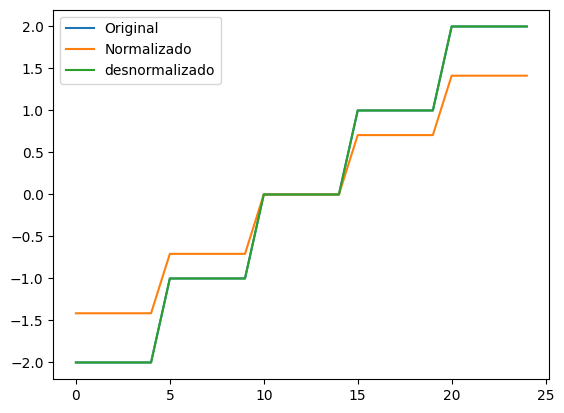

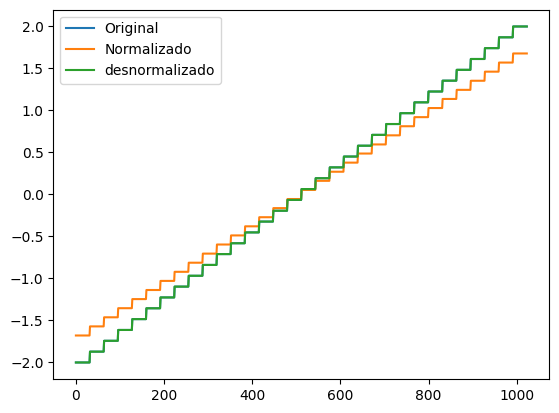

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Y"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [5]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [6]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-04 02:34:49.931302: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 02:34:49.989721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 02:34:49.989774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 02:34:49.991196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 02:34:49.999970: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 02:34:50.000975: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [7]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [8]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [9]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse_sup',
            boundarie = 0.25,
            hidden_sizes = [[40, 39], [20, 4], [15, 14], [26,18], [33, 21], [21, 12], [30, 21], [15, 2], [24, 7], [30, 16]],
            regularizers=[0.2, 0.0, 0.02, 0.5],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[40, 39], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_8_21  0.953838  0.825620  0.983050  0.821155  0.915645  0.065521   
model_1_8_20  0.953482  0.825619  0.983382  0.822833  0.916532  0.066026   
model_1_8_19  0.953115  0.825612  0.983713  0.824519  0.917420  0.066546   
model_1_8_18  0.952737  0.825598  0.984041  0.826213  0.918310  0.067083   
model_1_8_17  0.952348  0.825578  0.984366  0.827914  0.919202  0.067635   
model_1_8_16  0.951947  0.825552  0.984688  0.829621  0.920095  0.068204   
model_1_8_15  0.951534  0.825518  0.985007  0.831333  0.920988  0.068790   
model_1_8_14  0.951109  0.825478  0.985322  0.833049  0.921881  0.069394   
model_1_8_13  0.950670  0.825430  0.985633  0.834770  0.922774  0.070017   
model_1_8_12  0.950219  0.825375  0.985941  0.836494  0.923665  0.070658   
model_1_8_11  0.949753  0.825312  0.986243  0.838218  0.924555  0.071318   
model_1_8_10  0.949274  0.825240  0.986541  0.839944  0.925442  0.071998   
model_1_8_9   0.948780  0.825160  0.986834  0.841669  0.926327  0.072699   
model_1_8_8   0.948272  0.825072  0.987121  0.843392  0.927207  0.073421   
model_1_8_7   0.947748  0.824974  0.987402  0.845111  0.928082  0.074165   
model_1_8_6   0.947208  0.824867  0.987677  0.846826  0.928952  0.074931   
model_1_8_5   0.946651  0.824751  0.987945  0.848533  0.929816  0.075721   
model_1_8_4   0.946078  0.824624  0.988205  0.850232  0.930671  0.076535   
model_1_8_3   0.945487  0.824487  0.988458  0.851920  0.931518  0.077373   
model_1_8_2   0.944878  0.824339  0.988703  0.853596  0.932356  0.078238   
model_1_8_1   0.944250  0.824179  0.988938  0.855257  0.933182  0.079128   
model_1_8_0   0.943604  0.824008  0.989164  0.856901  0.933995  0.080047   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_8_21  0.247507  0.018403  0.149136  0.083770  1.011865  0.255971   
model_1_8_20  0.247509  0.018042  0.147737  0.082889  1.020397  0.256955   
model_1_8_19  0.247519  0.017683  0.146331  0.082007  1.029011  0.257966   
model_1_8_18  0.247538  0.017327  0.144918  0.081123  1.037704  0.259003   
model_1_8_17  0.247566  0.016974  0.143500  0.080237  1.046476  0.260067   
model_1_8_16  0.247604  0.016624  0.142077  0.079351  1.055328  0.261159   
model_1_8_15  0.247651  0.016278  0.140649  0.078464  1.064260  0.262279   
model_1_8_14  0.247709  0.015936  0.139218  0.077577  1.073276  0.263428   
model_1_8_13  0.247777  0.015598  0.137783  0.076690  1.082371  0.264606   
model_1_8_12  0.247855  0.015265  0.136346  0.075805  1.091549  0.265815   
model_1_8_11  0.247945  0.014936  0.134907  0.074922  1.100805  0.267054   
model_1_8_10  0.248046  0.014613  0.133468  0.074040  1.110148  0.268325   
model_1_8_9   0.248159  0.014295  0.132030  0.073162  1.119568  0.269627   
model_1_8_8   0.248285  0.013983  0.130593  0.072288  1.129076  0.270963   
model_1_8_7   0.248423  0.013678  0.129159  0.071419  1.138662  0.272332   
model_1_8_6   0.248575  0.013379  0.127730  0.070555  1.148338  0.273736   
model_1_8_5   0.248741  0.013089  0.126306  0.069697  1.158094  0.275174   
model_1_8_4   0.248921  0.012806  0.124889  0.068848  1.167935  0.276649   
model_1_8_3   0.249116  0.012531  0.123481  0.068006  1.177860  0.278161   
model_1_8_2   0.249326  0.012266  0.122084  0.067175  1.187868  0.279710   
model_1_8_1   0.249552  0.012010  0.120699  0.066355  1.197965  0.281298   
model_1_8_0   0.249795  0.011765  0.119328  0.065547  1.208143  0.282925   

                r2_adj       rsd          aic          bic  
model_1_8_21  1.000639  0.266868  3523.450771  5667.453346  
model_1_8_20  1.000643  0.267894  3523.435414  5667.437990  
model_1_8_19  1.000649  0.268948  3523.419712  5667.422288  
model_1_8_18  1.000654  0.270029  3523.403663  5667.406239  
model_1_8_17  1.000659  0.271139  3523.387263  5667.389839  
model_1_8_16  1.000665  0.272277  3523.370503  5667.373079  
model_1_8_15  1.000670  0.273445  3523.353384  5667.355960  
model_1_8_14  1.000676  0.274643  

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_9_24  0.961713  0.830100  0.535468  0.969732  0.920902  0.054342   
model_1_9_23  0.961529  0.830076  0.537452  0.970087  0.921409  0.054604   
model_1_9_22  0.961336  0.830043  0.539404  0.970436  0.921908  0.054879   
model_1_9_21  0.961133  0.829999  0.541324  0.970780  0.922398  0.055166   
model_1_9_20  0.960921  0.829944  0.543212  0.971117  0.922880  0.055466   
model_1_9_19  0.960700  0.829877  0.545065  0.971448  0.923353  0.055781   
model_1_9_18  0.960469  0.829799  0.546882  0.971772  0.923817  0.056109   
model_1_9_17  0.960228  0.829710  0.548664  0.972088  0.924271  0.056451   
model_1_9_16  0.959976  0.829608  0.550409  0.972398  0.924714  0.056808   
model_1_9_15  0.959714  0.829493  0.552115  0.972699  0.925147  0.057180   
model_1_9_14  0.959441  0.829365  0.553782  0.972992  0.925569  0.057568   
model_1_9_13  0.959157  0.829224  0.555409  0.973276  0.925979  0.057971   
model_1_9_12  0.958861  0.829069  0.556995  0.973551  0.926378  0.058391   
model_1_9_11  0.958554  0.828900  0.558540  0.973816  0.926764  0.058827   
model_1_9_10  0.958234  0.828717  0.560041  0.974071  0.927138  0.059280   
model_1_9_9   0.957903  0.828518  0.561499  0.974316  0.927498  0.059751   
model_1_9_8   0.957558  0.828304  0.562912  0.974549  0.927845  0.060240   
model_1_9_7   0.957201  0.828075  0.564279  0.974771  0.928177  0.060747   
model_1_9_6   0.956831  0.827829  0.565599  0.974981  0.928495  0.061273   
model_1_9_5   0.956447  0.827567  0.566873  0.975179  0.928798  0.061818   
model_1_9_4   0.956049  0.827287  0.568099  0.975363  0.929084  0.062383   
model_1_9_3   0.955636  0.826991  0.569273  0.975533  0.929355  0.062968   
model_1_9_2   0.955209  0.826676  0.570401  0.975689  0.929609  0.063574   
model_1_9_1   0.954768  0.826343  0.571476  0.975830  0.929845  0.064201   
model_1_9_0   0.954310  0.825991  0.572500  0.975956  0.930064  0.064850   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_9_24  0.241149  0.140434  0.056452  0.098443  0.873183  0.233115   
model_1_9_23  0.241182  0.139834  0.055790  0.097812  0.877817  0.233675   
model_1_9_22  0.241230  0.139243  0.055138  0.097191  0.882491  0.234262   
model_1_9_21  0.241292  0.138663  0.054498  0.096580  0.887209  0.234874   
model_1_9_20  0.241370  0.138092  0.053869  0.095981  0.891964  0.235513   
model_1_9_19  0.241465  0.137532  0.053252  0.095392  0.896758  0.236179   
model_1_9_18  0.241575  0.136983  0.052647  0.094815  0.901597  0.236873   
model_1_9_17  0.241702  0.136444  0.052057  0.094250  0.906477  0.237594   
model_1_9_16  0.241847  0.135917  0.051480  0.093698  0.911397  0.238344   
model_1_9_15  0.242010  0.135401  0.050918  0.093159  0.916356  0.239124   
model_1_9_14  0.242191  0.134897  0.050372  0.092634  0.921361  0.239933   
model_1_9_13  0.242392  0.134405  0.049842  0.092124  0.926406  0.240772   
model_1_9_12  0.242612  0.133925  0.049329  0.091627  0.931491  0.241642   
model_1_9_11  0.242851  0.133459  0.048835  0.091147  0.936623  0.242542   
model_1_9_10  0.243112  0.133005  0.048359  0.090682  0.941799  0.243475   
model_1_9_9   0.243394  0.132564  0.047903  0.090233  0.947013  0.244440   
model_1_9_8   0.243697  0.132137  0.047467  0.089802  0.952276  0.245438   
model_1_9_7   0.244023  0.131723  0.047053  0.089388  0.957580  0.246468   
model_1_9_6   0.244372  0.131324  0.046662  0.088993  0.962927  0.247533   
model_1_9_5   0.244744  0.130939  0.046293  0.088616  0.968324  0.248632   
model_1_9_4   0.245140  0.130569  0.045950  0.088259  0.973759  0.249765   
model_1_9_3   0.245562  0.130214  0.045632  0.087923  0.979241  0.250934   
model_1_9_2   0.246008  0.129873  0.045341  0.087607  0.987062  0.252138   
model_1_9_1   0.246481  0.129548  0.045078  0.087313  0.995241  0.253379   
model_1_9_0   0.246980  0.129238  0.044843  0.087041  1.003509  0.254656   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[40, 39], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_4_15  0.982573  0.833649  0.370647  0.865195  0.823754  0.024735   
model_2_4_16  0.982221  0.833644  0.367889  0.861075  0.819777  0.025235   
model_2_4_14  0.982950  0.833639  0.373322  0.869683  0.828058  0.024201   
model_2_4_17  0.981892  0.833630  0.365118  0.857300  0.816112  0.025702   
model_2_4_13  0.983348  0.833610  0.375810  0.874559  0.832698  0.023635   
model_2_4_18  0.981586  0.833608  0.362395  0.853850  0.812746  0.026136   
model_2_4_19  0.981304  0.833581  0.359751  0.850700  0.809660  0.026537   
model_2_4_12  0.983767  0.833555  0.377981  0.879840  0.837679  0.023040   
model_2_4_20  0.981043  0.833551  0.357223  0.847830  0.806837  0.026907   
model_2_4_21  0.980804  0.833519  0.354820  0.845218  0.804260  0.027246   
model_2_4_11  0.984204  0.833467  0.379662  0.885541  0.843000  0.022421   
model_2_4_10  0.984652  0.833336  0.380635  0.891671  0.848650  0.021784   
model_2_4_9   0.985107  0.833149  0.380612  0.898232  0.854605  0.021138   
model_2_4_8   0.985558  0.832892  0.379234  0.905216  0.860829  0.020499   
model_2_4_7   0.985992  0.832544  0.376048  0.912602  0.867264  0.019882   
model_2_4_6   0.986394  0.832082  0.370480  0.920353  0.873826  0.019312   
model_2_4_5   0.986741  0.831477  0.361814  0.928409  0.880399  0.018820   
model_2_4_4   0.987004  0.830693  0.349163  0.936683  0.886830  0.018446   
model_2_4_3   0.987148  0.829685  0.331430  0.945054  0.892915  0.018241   
model_2_4_2   0.987128  0.828399  0.307268  0.953358  0.898388  0.018270   
model_2_4_1   0.986885  0.826768  0.275035  0.961378  0.902914  0.018615   
model_2_4_0   0.986348  0.824712  0.232739  0.968831  0.906063  0.019377   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_4_15  0.236111  0.046705  0.106195  0.076450  0.619707  0.157273   
model_2_4_16  0.236117  0.046910  0.109441  0.078175  0.610270  0.158856   
model_2_4_14  0.236125  0.046507  0.102659  0.074583  0.630211  0.155566   
model_2_4_17  0.236138  0.047115  0.112414  0.079765  0.601792  0.160320   
model_2_4_13  0.236167  0.046322  0.098818  0.072570  0.641906  0.153736   
model_2_4_18  0.236169  0.047318  0.115132  0.081225  0.594175  0.161666   
model_2_4_19  0.236208  0.047514  0.117613  0.082563  0.587326  0.162902   
model_2_4_12  0.236244  0.046161  0.094658  0.070410  0.654932  0.151790   
model_2_4_20  0.236250  0.047701  0.119874  0.083788  0.581166  0.164032   
model_2_4_21  0.236295  0.047880  0.121932  0.084906  0.575634  0.165065   
model_2_4_11  0.236369  0.046036  0.090167  0.068102  0.669445  0.149735   
model_2_4_10  0.236555  0.045964  0.085338  0.065651  0.685615  0.147593   
model_2_4_9   0.236820  0.045966  0.080170  0.063068  0.703640  0.145391   
model_2_4_8   0.237186  0.046068  0.074668  0.060368  0.723743  0.143173   
model_2_4_7   0.237680  0.046304  0.068849  0.057577  0.746166  0.141003   
model_2_4_6   0.238335  0.046718  0.062743  0.054730  0.771202  0.138967   
model_2_4_5   0.239194  0.047361  0.056397  0.051879  0.799156  0.137186   
model_2_4_4   0.240307  0.048300  0.049879  0.049089  0.830397  0.135816   
model_2_4_3   0.241738  0.049616  0.043285  0.046450  0.865328  0.135060   
model_2_4_2   0.243563  0.051409  0.036743  0.044076  0.904418  0.135168   
model_2_4_1   0.245877  0.053801  0.030425  0.042113  0.948192  0.136438   
model_2_4_0   0.248795  0.056940  0.024554  0.040747  0.997252  0.139203   

                r2_adj       rsd          aic          bic  
model_2_4_15  1.000241  0.163968  3525.399101  5669.401677  
model_2_4_16  1.000246  0.165619  3525.359020  5669.361596  
model_2_4_14  1.000236  0.162188  3525.442751  5669.445327  
model_2_4_17  1.000250  0.167145  3525.322344  5669.324920  
model_2_4_13  1.000230  0.160281  3525.490066  5669.492642  
model_2_4_18  1.000255  0.168548  3525.288892  5669.291467  
model_2_4_19  1.000259  0.169837  3525.258435  5669.261011  
model_2_4_12  1.000225  0.158252  

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_5_0   0.982931  0.832829  0.989071  0.762100  0.855491  0.024227   
model_2_5_1   0.984627  0.832023  0.984695  0.771039  0.858951  0.021819   
model_2_5_2   0.985977  0.831148  0.979957  0.778515  0.861402  0.019904   
model_2_5_3   0.987048  0.830239  0.975030  0.784775  0.863058  0.018384   
model_2_5_4   0.987895  0.829324  0.970047  0.790023  0.864097  0.017181   
model_2_5_5   0.988562  0.828421  0.965110  0.794429  0.864659  0.016234   
model_2_5_6   0.989086  0.827544  0.960293  0.798134  0.864857  0.015491   
model_2_5_7   0.989494  0.826702  0.955649  0.801253  0.864783  0.014911   
model_2_5_8   0.989811  0.825902  0.951217  0.803886  0.864508  0.014461   
model_2_5_9   0.990055  0.825147  0.947019  0.806110  0.864090  0.014115   
model_2_5_10  0.990241  0.824439  0.943070  0.807994  0.863574  0.013851   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_5_0   0.237275  0.002580  0.080345  0.041463  0.590655  0.155650   
model_2_5_1   0.238420  0.003614  0.077326  0.040470  0.604609  0.147713   
model_2_5_2   0.239662  0.004732  0.074801  0.039767  0.617556  0.141080   
model_2_5_3   0.240951  0.005896  0.072687  0.039292  0.629549  0.135586   
model_2_5_4   0.242250  0.007072  0.070915  0.038993  0.640642  0.131078   
model_2_5_5   0.243532  0.008238  0.069427  0.038832  0.650879  0.127414   
model_2_5_6   0.244777  0.009375  0.068176  0.038775  0.660313  0.124463   
model_2_5_7   0.245972  0.010472  0.067122  0.038797  0.668980  0.122111   
model_2_5_8   0.247107  0.011518  0.066233  0.038876  0.676932  0.120256   
model_2_5_9   0.248179  0.012509  0.065482  0.038996  0.684220  0.118808   
model_2_5_10  0.249183  0.013442  0.064845  0.039144  0.690874  0.117692   

                r2_adj       rsd          aic          bic  
model_2_5_0   1.000236  0.162276  3525.440582  5669.443158  
model_2_5_1   1.000213  0.154001  3525.649937  5669.652513  
model_2_5_2   1.000194  0.147086  3525.833719  5669.836295  
model_2_5_3   1.000179  0.141358  3525.992593  5669.995169  
model_2_5_4   1.000167  0.136658  3526.127846  5670.130422  
model_2_5_5   1.000158  0.132838  3526.241265  5670.243841  
model_2_5_6   1.000151  0.129762  3526.334978  5670.337554  
model_2_5_7   1.000145  0.127310  3526.411287  5670.413863  
model_2_5_8   1.000141  0.125375  3526.472544  5670.475120  
model_2_5_9   1.000138  0.123866  3526.520995  5670.523571  
model_2_5_10  1.000135  0.122702  3526.558751  5670.561327

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_6_23  0.995851  0.843437  0.970604  0.979618  0.976969  0.005889   
model_2_6_22  0.995915  0.843313  0.971159  0.979981  0.977393  0.005798   
model_2_6_21  0.995984  0.843174  0.971768  0.980379  0.977859  0.005700   
model_2_6_20  0.996058  0.843017  0.972436  0.980816  0.978369  0.005596   
model_2_6_19  0.996136  0.842840  0.973166  0.981295  0.978929  0.005484   
model_2_6_18  0.996219  0.842640  0.973964  0.981819  0.979540  0.005367   
model_2_6_17  0.996305  0.842413  0.974833  0.982392  0.980207  0.005245   
model_2_6_16  0.996394  0.842155  0.975778  0.983016  0.980932  0.005118   
model_2_6_15  0.996485  0.841863  0.976803  0.983694  0.981720  0.004989   
model_2_6_14  0.996576  0.841530  0.977910  0.984429  0.982572  0.004860   
model_2_6_13  0.996664  0.841150  0.979103  0.985223  0.983491  0.004735   
model_2_6_12  0.996747  0.840716  0.980383  0.986077  0.984478  0.004617   
model_2_6_11  0.996820  0.840219  0.981750  0.986993  0.985534  0.004513   
model_2_6_10  0.996879  0.839649  0.983201  0.987969  0.986657  0.004430   
model_2_6_9   0.996915  0.838994  0.984732  0.989004  0.987843  0.004379   
model_2_6_8   0.996921  0.838238  0.986334  0.990094  0.989089  0.004370   
model_2_6_7   0.996885  0.837365  0.987996  0.991231  0.990383  0.004421   
model_2_6_6   0.996793  0.836353  0.989700  0.992405  0.991715  0.004552   
model_2_6_5   0.996627  0.835178  0.991422  0.993604  0.993066  0.004787   
model_2_6_4   0.996366  0.833809  0.993130  0.994807  0.994413  0.005158   
model_2_6_3   0.995980  0.832210  0.994782  0.995989  0.995725  0.005705   
model_2_6_2   0.995437  0.830334  0.996327  0.997116  0.996962  0.006477   
model_2_6_1   0.994692  0.828129  0.997695  0.998146  0.998073  0.007534   
model_2_6_0   0.993692  0.825526  0.998806  0.999018  0.998991  0.008953   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_6_23  0.222219  0.021118  0.015264  0.018191  0.165968  0.076742   
model_2_6_22  0.222394  0.020719  0.014992  0.017856  0.169961  0.076145   
model_2_6_21  0.222592  0.020281  0.014694  0.017488  0.174417  0.075500   
model_2_6_20  0.222814  0.019802  0.014367  0.017084  0.179392  0.074803   
model_2_6_19  0.223066  0.019277  0.014008  0.016643  0.184951  0.074056   
model_2_6_18  0.223350  0.018704  0.013615  0.016160  0.191168  0.073260   
model_2_6_17  0.223672  0.018080  0.013186  0.015633  0.198120  0.072419   
model_2_6_16  0.224038  0.017401  0.012719  0.015060  0.205905  0.071540   
model_2_6_15  0.224453  0.016665  0.012211  0.014438  0.214625  0.070632   
model_2_6_14  0.224926  0.015869  0.011661  0.013765  0.224412  0.069714   
model_2_6_13  0.225465  0.015012  0.011067  0.013039  0.235397  0.068809   
model_2_6_12  0.226080  0.014092  0.010427  0.012259  0.247746  0.067949   
model_2_6_11  0.226786  0.013111  0.009741  0.011426  0.261639  0.067179   
model_2_6_10  0.227595  0.012068  0.009010  0.010539  0.277293  0.066561   
model_2_6_9   0.228525  0.010969  0.008234  0.009602  0.294958  0.066171   
model_2_6_8   0.229598  0.009818  0.007419  0.008618  0.314913  0.066109   
model_2_6_7   0.230837  0.008624  0.006567  0.007595  0.337484  0.066494   
model_2_6_6   0.232273  0.007400  0.005687  0.006544  0.363057  0.067468   
model_2_6_5   0.233941  0.006163  0.004790  0.005476  0.392056  0.069188   
model_2_6_4   0.235884  0.004936  0.003889  0.004412  0.424980  0.071822   
model_2_6_3   0.238154  0.003748  0.003004  0.003376  0.462375  0.075534   
model_2_6_2   0.240816  0.002639  0.002159  0.002399  0.504854  0.080480   
model_2_6_1   0.243946  0.001656  0.001389  0.001522  0.553085  0.086801   
model_2_6_0   0.247640  0.000858  0.000736  0.000797  0.607782  0.094620   

                r2_adj       rsd          aic          bic  
model_2_6_23  1.000057  0.080009  3528.269222  5672.271798  
model_2_6_22  1.000057  0.079387  3528.300439  5672.303015  
model_2_6_21  1.000056  0.078714  3

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  56
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 9 ++++++++++++++

2024-05-04 02:43:57.822430: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  252
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 9 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 4ms/step

2024-05-04 02:53:14.623617: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_3] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_3] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_3] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/ste

2024-05-04 03:03:32.052868: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_1_19  0.955220  0.833248 -0.328480  0.967759  0.902942  0.063559   
model_8_1_18  0.955205  0.833243 -0.331304  0.968028  0.903043  0.063580   
model_8_1_17  0.955178  0.833233 -0.334503  0.968322  0.903149  0.063619   
model_8_1_16  0.955135  0.833214 -0.338129  0.968646  0.903260  0.063680   
model_8_1_15  0.955072  0.833184 -0.342250  0.969002  0.903374  0.063769   
model_8_1_14  0.954982  0.833140 -0.346950  0.969391  0.903490  0.063897   
model_8_1_13  0.954859  0.833076 -0.352321  0.969817  0.903605  0.064072   
model_8_1_12  0.954692  0.832988 -0.358482  0.970283  0.903716  0.064308   
model_8_1_11  0.954470  0.832868 -0.365567  0.970790  0.903819  0.064623   
model_8_1_10  0.954178  0.832707 -0.373754  0.971343  0.903906  0.065037   
model_8_1_9   0.953798  0.832494 -0.383253  0.971944  0.903970  0.065577   
model_8_1_8   0.953306  0.832213 -0.394330  0.972595  0.904001  0.066275   
model_8_1_7   0.952674  0.831846 -0.407319  0.973301  0.903983  0.067173   
model_8_1_6   0.951864  0.831370 -0.422652  0.974064  0.903898  0.068322   
model_8_1_5   0.950831  0.830757 -0.440884  0.974889  0.903723  0.069788   
model_8_1_4   0.949519  0.829970 -0.462751  0.975782  0.903424  0.071650   
model_8_1_3   0.947855  0.828966 -0.489241  0.976751  0.902959  0.074012   
model_8_1_2   0.945749  0.827691 -0.521723  0.977811  0.902272  0.077001   
model_8_1_1   0.943083  0.826080 -0.562148  0.978982  0.901282  0.080785   
model_8_1_0   0.939701  0.824034 -0.613375  0.980290  0.899867  0.085586   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_1_19  0.236681  0.275239  0.119681  0.197460  0.253287  0.252109   
model_8_1_18  0.236687  0.275824  0.118685  0.197255  0.250159  0.252152   
model_8_1_17  0.236701  0.276487  0.117591  0.197039  0.246671  0.252228   
model_8_1_16  0.236728  0.277238  0.116388  0.196813  0.242778  0.252349   
model_8_1_15  0.236771  0.278092  0.115069  0.196581  0.238431  0.252526   
model_8_1_14  0.236834  0.279066  0.113624  0.196345  0.233571  0.252778   
model_8_1_13  0.236924  0.280179  0.112042  0.196110  0.228135  0.253124   
model_8_1_12  0.237049  0.281455  0.110314  0.195884  0.222052  0.253591   
model_8_1_11  0.237219  0.282923  0.108429  0.195676  0.215235  0.254211   
model_8_1_10  0.237448  0.284619  0.106378  0.195498  0.207594  0.255024   
model_8_1_9   0.237751  0.286587  0.104148  0.195368  0.199020  0.256080   
model_8_1_8   0.238150  0.288882  0.101730  0.195306  0.189396  0.257439   
model_8_1_7   0.238670  0.291573  0.099110  0.195342  0.178586  0.259177   
model_8_1_6   0.239345  0.294750  0.096278  0.195514  0.168059  0.261385   
model_8_1_5   0.240216  0.298528  0.093215  0.195871  0.160056  0.264173   
model_8_1_4   0.241333  0.303058  0.089901  0.196480  0.194532  0.267675   
model_8_1_3   0.242759  0.308546  0.086303  0.197425  0.232658  0.272051   
model_8_1_2   0.244567  0.315276  0.082369  0.198822  0.274420  0.277491   
model_8_1_1   0.246854  0.323651  0.078022  0.200837  0.319388  0.284227   
model_8_1_0   0.249758  0.334265  0.073166  0.203715  0.366355  0.292551   

                r2_adj       rsd          aic          bic  
model_8_1_19  1.000619  0.262842  3523.511578  5667.514154  
model_8_1_18  1.000620  0.262886  3523.510899  5667.513475  
model_8_1_17  1.000620  0.262966  3523.509686  5667.512262  
model_8_1_16  1.000621  0.263092  3523.507777  5667.510353  
model_8_1_15  1.000621  0.263277  3523.504961  5667.507537  
model_8_1_14  1.000623  0.263539  3523.500976  5667.503552  
model_8_1_13  1.000624  0.263900  3523.495502  5667.498078  
model_8_1_12  1.000627  0.264387  3523.488128  5667.490704  
model_8_1_11  1.000630  0.265033  3523.478363  5667.480939  
model_8_1_10  1.000634  0.265881  3523.465590  5667.468166  
model_8_1_9   1.000639  0.266982  3523.449065  5667.451641  
model_8_1_8   1.000646  0.268399  3523.427886  5667.430462  
model_8_1_7   1.000655  0.270211 

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_2_3   0.973854  0.844377  0.900991  0.952139  0.977761  0.037111   
model_8_2_2   0.972055  0.844144  0.920027  0.965951  0.982366  0.039664   
model_8_2_4   0.974296  0.843520  0.874540  0.937319  0.971675  0.036484   
model_8_2_1   0.968575  0.842482  0.929982  0.977946  0.985115  0.044603   
model_8_2_5   0.973687  0.841867  0.842562  0.922119  0.964511  0.037348   
model_8_2_6   0.972300  0.839666  0.806876  0.906990  0.956647  0.039316   
model_8_2_0   0.963086  0.839010  0.929660  0.987139  0.985710  0.052394   
model_8_2_7   0.970364  0.837113  0.769076  0.892237  0.948407  0.042064   
model_8_2_8   0.968066  0.834364  0.730468  0.878056  0.940056  0.045326   
model_8_2_9   0.965552  0.831534  0.692073  0.864568  0.931794  0.048894   
model_8_2_10  0.962936  0.828707  0.654649  0.851836  0.923771  0.052607   
model_8_2_11  0.960302  0.825944  0.618734  0.839889  0.916090  0.056345   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_2_3   0.220884  0.072877  0.013233  0.043055  0.236357  0.192642   
model_8_2_2   0.221215  0.058865  0.009414  0.034140  0.239751  0.199159   
model_8_2_4   0.222101  0.092346  0.017330  0.054838  0.233118  0.191007   
model_8_2_1   0.223573  0.051537  0.006098  0.028818  0.243372  0.211195   
model_8_2_5   0.224447  0.115884  0.021533  0.068709  0.229992  0.193255   
model_8_2_6   0.227571  0.142151  0.025716  0.083934  0.226987  0.198284   
model_8_2_0   0.228502  0.051775  0.003556  0.027665  0.247283  0.228898   
model_8_2_7   0.231194  0.169975  0.029795  0.099885  0.224118  0.205096   
model_8_2_8   0.235096  0.198393  0.033716  0.116054  0.221414  0.212900   
model_8_2_9   0.239114  0.226654  0.037445  0.132050  0.218878  0.221119   
model_8_2_10  0.243126  0.254201  0.040965  0.147583  0.216526  0.229361   
model_8_2_11  0.247048  0.280636  0.044268  0.162452  0.214347  0.237371   

                r2_adj       rsd          aic          bic  
model_8_2_3   1.000362  0.200843  3524.587695  5668.590271  
model_8_2_2   1.000387  0.207637  3524.454610  5668.457186  
model_8_2_4   1.000356  0.199138  3524.621783  5668.624359  
model_8_2_1   1.000435  0.220186  3524.219896  5668.222472  
model_8_2_5   1.000364  0.201483  3524.574971  5668.577547  
model_8_2_6   1.000383  0.206725  3524.472226  5668.474802  
model_8_2_0   1.000511  0.238642  3523.897923  5667.900499  
model_8_2_7   1.000410  0.213827  3524.337118  5668.339694  
model_8_2_8   1.000442  0.221963  3524.187739  5668.190315  
model_8_2_9   1.000477  0.230533  3524.036214  5668.038790  
model_8_2_10  1.000513  0.239125  3523.889831  5667.892407  
model_8_2_11  1.000549  0.247476  3523.752527  5667.755103

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_3_9   0.974647  0.844194  0.978517  0.915121  0.957294  0.035985   
model_8_3_10  0.974139  0.844154  0.976520  0.909934  0.954279  0.036706   
model_8_3_8   0.975027  0.844075  0.980599  0.920698  0.960499  0.035445   
model_8_3_11  0.973548  0.843996  0.974620  0.905138  0.951458  0.037545   
model_8_3_12  0.972907  0.843754  0.972822  0.900725  0.948833  0.038454   
model_8_3_7   0.975223  0.843744  0.982754  0.926652  0.963879  0.035167   
model_8_3_13  0.972242  0.843452  0.971128  0.896680  0.946400  0.039398   
model_8_3_6   0.975161  0.843136  0.984960  0.932956  0.967413  0.035255   
model_8_3_14  0.971571  0.843113  0.969539  0.892984  0.944152  0.040350   
model_8_3_15  0.970909  0.842750  0.968055  0.889617  0.942082  0.041290   
model_8_3_16  0.970266  0.842377  0.966672  0.886557  0.940181  0.042203   
model_8_3_5   0.974749  0.842167  0.987191  0.939559  0.971068  0.035841   
model_8_3_17  0.969648  0.842002  0.965387  0.883780  0.938439  0.043080   
model_8_3_18  0.969061  0.841633  0.964197  0.881265  0.936845  0.043914   
model_8_3_19  0.968506  0.841275  0.963098  0.878991  0.935389  0.044701   
model_8_3_20  0.967987  0.840930  0.962084  0.876935  0.934062  0.045438   
model_8_3_4   0.973867  0.840735  0.989409  0.946387  0.974795  0.037092   
model_8_3_21  0.967502  0.840602  0.961152  0.875079  0.932853  0.046127   
model_8_3_22  0.967051  0.840292  0.960295  0.873405  0.931754  0.046766   
model_8_3_3   0.972367  0.838713  0.991572  0.953333  0.978529  0.039221   
model_8_3_2   0.970064  0.835945  0.993624  0.960249  0.982188  0.042490   
model_8_3_1   0.966728  0.832238  0.995504  0.966946  0.985668  0.047224   
model_8_3_0   0.962080  0.827359  0.997145  0.973191  0.988846  0.053822   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_3_9   0.221144  0.054114  0.127001  0.090557  0.259658  0.189698   
model_8_3_10  0.221201  0.059142  0.134761  0.096952  0.260935  0.191587   
model_8_3_8   0.221313  0.048868  0.118657  0.083762  0.258055  0.188270   
model_8_3_11  0.221425  0.063928  0.141937  0.102933  0.261959  0.193764   
model_8_3_12  0.221769  0.068458  0.148541  0.108499  0.262783  0.196098   
model_8_3_7   0.221782  0.043441  0.109748  0.076594  0.256043  0.187530   
model_8_3_13  0.222197  0.072725  0.154594  0.113659  0.263449  0.198491   
model_8_3_6   0.222646  0.037883  0.100316  0.069099  0.253528  0.187763   
model_8_3_14  0.222679  0.076726  0.160123  0.118425  0.264000  0.200874   
model_8_3_15  0.223193  0.080466  0.165161  0.122814  0.264456  0.203199   
model_8_3_16  0.223723  0.083949  0.169741  0.126845  0.264844  0.205434   
model_8_3_5   0.224021  0.032265  0.090435  0.061350  0.250399  0.189316   
model_8_3_17  0.224255  0.087185  0.173895  0.130540  0.265173  0.207557   
model_8_3_18  0.224779  0.090181  0.177658  0.133919  0.265466  0.209556   
model_8_3_19  0.225288  0.092951  0.181061  0.137006  0.265722  0.211425   
model_8_3_20  0.225777  0.095504  0.184137  0.139820  0.265951  0.213163   
model_8_3_4   0.226053  0.026676  0.080218  0.053447  0.246539  0.192594   
model_8_3_21  0.226243  0.097853  0.186914  0.142383  0.266157  0.214771   
model_8_3_22  0.226683  0.100011  0.189418  0.144715  0.266345  0.216254   
model_8_3_3   0.228923  0.021230  0.069827  0.045528  0.241846  0.198043   
model_8_3_2   0.232853  0.016060  0.059478  0.037769  0.236232  0.206131   
model_8_3_1   0.238114  0.011324  0.049457  0.030390  0.229680  0.217311   
model_8_3_0   0.245039  0.007192  0.040114  0.023653  0.222266  0.231996   

                r2_adj       rsd          aic          bic  
model_8_3_9   1.000351  0.197773  3524.649298  5668.651873  
model_8_3_10  1.000358  0.199744  3524.609646  5668.612222  
model_8_3_8   1.000345  0.196285  3524.679521  5668.682097  
model_8_3_11  1.000366  0.202013  3524.564450  5668.567026  
model_8_3_12  1.000375  0.204446  3524.516573  5668.519149  
mode

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_4_0  0.972595  0.838028  0.921058  0.995783  0.959903  0.038897   
model_8_4_1  0.976724  0.835152  0.928227  0.984925  0.960224  0.033036   
model_8_4_2  0.979735  0.831874  0.933187  0.969591  0.958137  0.028764   
model_8_4_3  0.981865  0.828360  0.936293  0.951408  0.954295  0.025740   
model_8_4_4  0.983310  0.824737  0.937881  0.931591  0.949224  0.023689   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_4_0  0.229896  0.049968  0.001602  0.025785  0.321937  0.197224   
model_8_4_1  0.233978  0.045431  0.005726  0.025578  0.372589  0.181759   
model_8_4_2  0.238630  0.042291  0.011551  0.026921  0.418086  0.169598   
model_8_4_3  0.243618  0.040325  0.018457  0.029391  0.459910  0.160436   
model_8_4_4  0.248761  0.039320  0.025985  0.032652  0.497941  0.153913   

               r2_adj       rsd          aic          bic  
model_8_4_0  1.000379  0.205620  3524.493669  5668.496245  
model_8_4_1  1.000322  0.189496  3524.820303  5668.822879  
model_8_4_2  1.000280  0.176819  3525.097287  5669.099863  
model_8_4_3  1.000251  0.167266  3525.319453  5669.322029  
model_8_4_4  1.000231  0.160465  3525.485484  5669.488060

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_5_2  0.994183  0.824239  0.899483  0.970925  0.987972  0.008257   
model_8_5_1  0.994200  0.824079  0.899088  0.971230  0.988022  0.008232   
model_8_5_0  0.994219  0.823901  0.898647  0.971567  0.988077  0.008206   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_5_2  0.249468  0.022583  0.028780  0.025681  0.086817  0.090867   
model_8_5_1  0.249694  0.022672  0.028477  0.025574  0.090323  0.090729   
model_8_5_0  0.249947  0.022771  0.028144  0.025457  0.094222  0.090585   

              r2_adj       rsd          aic          bic  
model_8_5_2  1.00008  0.094736  3527.593416  5671.595992  
model_8_5_1  1.00008  0.094592  3527.599498  5671.602074  
model_8_5_0  1.00008  0.094441  3527.605880  5671.608456

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_1_2  0.877117  0.845287  0.599643  0.598069  0.602452  0.174414   
model_12_1_3  0.879431  0.842896  0.554078  0.429076  0.502920  0.171130   
model_12_1_1  0.869825  0.841891  0.652788  0.728503  0.689174  0.184765   
model_12_1_4  0.878418  0.836620  0.516919  0.240036  0.399189  0.172568   
model_12_1_0  0.856321  0.830974  0.711528  0.814258  0.759300  0.203932   
model_12_1_5  0.875698  0.828261  0.489719  0.049985  0.300498  0.176429   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_1_2  0.219593  0.241077  0.193542  0.217309  0.730824  0.417629   
model_12_1_3  0.222987  0.268514  0.274918  0.271716  0.839141  0.413679   
model_12_1_1  0.224412  0.209075  0.130734  0.169905  0.637838  0.429842   
model_12_1_4  0.231894  0.290889  0.365947  0.328418  0.931554  0.415413   
model_12_1_0  0.239908  0.173704  0.089441  0.131572  0.629496  0.451588   
model_12_1_5  0.243759  0.307268  0.457462  0.382365  1.001648  0.420034   

                r2_adj       rsd         aic         bic  
model_12_1_2  1.023593  0.435408  301.492648  483.105145  
model_12_1_3  1.023149  0.431290  301.530662  483.143160  
model_12_1_1  1.024994  0.448142  301.377346  482.989844  
model_12_1_4  1.023344  0.433098  301.513929  483.126427  
model_12_1_0  1.027586  0.470813  301.179937  482.792435  
model_12_1_5  1.023866  0.437916  301.469677  483.082175

DataFrame salvo em ../results/metrics_12_1
+++++++++++ [12_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_2] | 9 ++++++

2024-05-04 03:25:04.900738: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_1] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_1] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_1] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_1] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_1] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_2] | 1 ++++++++++++++++++


2024-05-04 03:25:12.950915: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  44
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_2] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/st

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_6_11  0.945032  0.826236  0.706934  0.685883  0.712549  0.078019   
model_13_6_10  0.944958  0.826095  0.706830  0.688450  0.714278  0.078124   
model_13_6_9   0.944876  0.825944  0.706702  0.691010  0.715996  0.078241   
model_13_6_8   0.944786  0.825783  0.706548  0.693561  0.717702  0.078369   
model_13_6_7   0.944687  0.825611  0.706371  0.696103  0.719396  0.078508   
model_13_6_6   0.944581  0.825428  0.706169  0.698635  0.721077  0.078660   
model_13_6_5   0.944465  0.825234  0.705943  0.701155  0.722744  0.078824   
model_13_6_4   0.944340  0.825029  0.705693  0.703664  0.724398  0.079001   
model_13_6_3   0.944207  0.824812  0.705418  0.706161  0.726036  0.079190   
model_13_6_2   0.944064  0.824583  0.705119  0.708644  0.727660  0.079393   
model_13_6_1   0.943911  0.824342  0.704795  0.711114  0.729268  0.079609   
model_13_6_0   0.943749  0.824090  0.704447  0.713568  0.730859  0.079840   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_6_11  0.246633  0.088732  0.262143  0.175437  0.703908  0.279319   
model_13_6_10  0.246833  0.088763  0.260001  0.174382  0.708520  0.279507   
model_13_6_9   0.247047  0.088802  0.257864  0.173333  0.713181  0.279715   
model_13_6_8   0.247276  0.088849  0.255735  0.172292  0.717897  0.279944   
model_13_6_7   0.247520  0.088902  0.253614  0.171258  0.722667  0.280193   
model_13_6_6   0.247780  0.088963  0.251501  0.170232  0.727495  0.280464   
model_13_6_5   0.248055  0.089032  0.249398  0.169215  0.732378  0.280756   
model_13_6_4   0.248347  0.089108  0.247304  0.168206  0.737318  0.281071   
model_13_6_3   0.248654  0.089191  0.245220  0.167206  0.742315  0.281408   
model_13_6_2   0.248979  0.089282  0.243148  0.166215  0.748251  0.281768   
model_13_6_1   0.249320  0.089380  0.241087  0.165233  0.754278  0.282152   
model_13_6_0   0.249679  0.089485  0.239039  0.164262  0.760369  0.282559   

                 r2_adj       rsd         aic         bic  
model_13_6_11  1.010554  0.291210  303.101603  484.714101  
model_13_6_10  1.010568  0.291407  303.098906  484.711404  
model_13_6_9   1.010584  0.291624  303.095930  484.708428  
model_13_6_8   1.010601  0.291862  303.092662  484.705159  
model_13_6_7   1.010620  0.292122  303.089103  484.701601  
model_13_6_6   1.010641  0.292404  303.085243  484.697741  
model_13_6_5   1.010663  0.292708  303.081076  484.693574  
model_13_6_4   1.010687  0.293036  303.076598  484.689096  
model_13_6_3   1.010712  0.293388  303.071805  484.684303  
model_13_6_2   1.010740  0.293763  303.066688  484.679186  
model_13_6_1   1.010769  0.294163  303.061244  484.673742  
model_13_6_0   1.010800  0.294589  303.055465  484.667963

DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_7_24  0.961041  0.838441  0.908180  0.987796  0.962925  0.055296   
model_13_7_23  0.960640  0.838214  0.910311  0.988282  0.963893  0.055866   
model_13_7_22  0.960223  0.837971  0.912416  0.988759  0.964848  0.056457   
model_13_7_21  0.959791  0.837711  0.914494  0.989227  0.965789  0.057071   
model_13_7_20  0.959341  0.837433  0.916544  0.989686  0.966716  0.057709   
model_13_7_19  0.958875  0.837137  0.918562  0.990134  0.967626  0.058371   
model_13_7_18  0.958391  0.836823  0.920547  0.990570  0.968520  0.059058   
model_13_7_17  0.957889  0.836489  0.922498  0.990996  0.969395  0.059771   
model_13_7_16  0.957368  0.836135  0.924410  0.991409  0.970252  0.060510   
model_13_7_15  0.956828  0.835760  0.926283  0.991809  0.971088  0.061277   
model_13_7_14  0.956268  0.835363  0.928113  0.992195  0.971903  0.062071   
model_13_7_13  0.955688  0.834944  0.929899  0.992566  0.972696  0.062895   
model_13_7_12  0.955087  0.834502  0.931638  0.992922  0.973464  0.063748   
model_13_7_11  0.954464  0.834037  0.933326  0.993261  0.974207  0.064632   
model_13_7_10  0.953819  0.833546  0.934961  0.993583  0.974923  0.065547   
model_13_7_9   0.953151  0.833029  0.936540  0.993886  0.975610  0.066496   
model_13_7_8   0.952459  0.832486  0.938060  0.994170  0.976267  0.067478   
model_13_7_7   0.951743  0.831916  0.939519  0.994432  0.976892  0.068494   
model_13_7_6   0.951001  0.831317  0.940912  0.994671  0.977483  0.069547   
model_13_7_5   0.950234  0.830688  0.942237  0.994886  0.978039  0.070636   
model_13_7_4   0.949439  0.830029  0.943491  0.995074  0.978557  0.071764   
model_13_7_3   0.948617  0.829338  0.944669  0.995235  0.979035  0.072931   
model_13_7_2   0.947766  0.828615  0.945770  0.995365  0.979470  0.074138   
model_13_7_1   0.946886  0.827857  0.946788  0.995463  0.979862  0.075388   
model_13_7_0   0.945975  0.827065  0.947722  0.995524  0.980205  0.076681   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_7_24  0.229309  0.061651  0.013071  0.037361  0.324038  0.235152   
model_13_7_23  0.229632  0.060221  0.012551  0.036386  0.315882  0.236359   
model_13_7_22  0.229977  0.058807  0.012040  0.035423  0.329080  0.237607   
model_13_7_21  0.230346  0.057412  0.011538  0.034475  0.342503  0.238896   
model_13_7_20  0.230740  0.056036  0.011047  0.033542  0.356151  0.240228   
model_13_7_19  0.231160  0.054680  0.010568  0.032624  0.370030  0.241602   
model_13_7_18  0.231607  0.053347  0.010100  0.031724  0.384145  0.243019   
model_13_7_17  0.232081  0.052038  0.009644  0.030841  0.398497  0.244481   
model_13_7_16  0.232583  0.050754  0.009202  0.029978  0.413082  0.245988   
model_13_7_15  0.233115  0.049496  0.008774  0.029135  0.427908  0.247541   
model_13_7_14  0.233678  0.048267  0.008360  0.028314  0.442971  0.249141   
model_13_7_13  0.234272  0.047068  0.007962  0.027515  0.458281  0.250788   
model_13_7_12  0.234900  0.045901  0.007581  0.026741  0.473837  0.252483   
model_13_7_11  0.235561  0.044768  0.007217  0.025993  0.489635  0.254228   
model_13_7_10  0.236258  0.043670  0.006873  0.025271  0.506025  0.256022   
model_13_7_9   0.236991  0.042609  0.006548  0.024579  0.522742  0.257868   
model_13_7_8   0.237761  0.041589  0.006245  0.023917  0.539711  0.259765   
model_13_7_7   0.238571  0.040609  0.005964  0.023287  0.556925  0.261714   
model_13_7_6   0.239421  0.039674  0.005708  0.022691  0.574383  0.263717   
model_13_7_5   0.240314  0.038784  0.005478  0.022131  0.592078  0.265775   
model_13_7_4   0.241249  0.037942  0.005276  0.021609  0.610012  0.267888   
model_13_7_3   0.242230  0.037151  0.005103  0.021127  0.628174  0.270057   
model_13_7_2   0.243257  0.036412  0.004964  0.020688  0.646638  0.272284   
model_13_7_1   0.244332  0.035728  0.004860  0.020294  0.665528  0.274569   
model_13_7_0   0.245457  0.035101  0.004794  0.019948  0.684620  0.276914   

               

DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_8_24  0.972194  0.850336  0.899233  0.966394  0.970698  0.039466   
model_13_8_23  0.971886  0.849989  0.900861  0.967518  0.971345  0.039904   
model_13_8_22  0.971568  0.849634  0.902490  0.968633  0.971989  0.040355   
model_13_8_21  0.971240  0.849269  0.904122  0.969737  0.972630  0.040821   
model_13_8_20  0.970902  0.848896  0.905756  0.970831  0.973269  0.041300   
model_13_8_19  0.970554  0.848513  0.907391  0.971914  0.973904  0.041794   
model_13_8_18  0.970196  0.848120  0.909027  0.972985  0.974536  0.042303   
model_13_8_17  0.969827  0.847717  0.910663  0.974045  0.975165  0.042827   
model_13_8_16  0.969447  0.847305  0.912299  0.975091  0.975790  0.043366   
model_13_8_15  0.969055  0.846881  0.913936  0.976125  0.976411  0.043921   
model_13_8_14  0.968653  0.846447  0.915571  0.977146  0.977028  0.044493   
model_13_8_13  0.968238  0.846002  0.917205  0.978152  0.977641  0.045081   
model_13_8_12  0.967812  0.845546  0.918838  0.979144  0.978249  0.045686   
model_13_8_11  0.967373  0.845078  0.920469  0.980121  0.978852  0.046309   
model_13_8_10  0.966922  0.844599  0.922096  0.981082  0.979450  0.046949   
model_13_8_9   0.966458  0.844107  0.923720  0.982027  0.980042  0.047608   
model_13_8_8   0.965981  0.843603  0.925341  0.982956  0.980629  0.048285   
model_13_8_7   0.965491  0.843086  0.926956  0.983867  0.981210  0.048981   
model_13_8_6   0.964986  0.842555  0.928566  0.984759  0.981784  0.049697   
model_13_8_5   0.964468  0.842011  0.930169  0.985634  0.982351  0.050433   
model_13_8_4   0.963935  0.841453  0.931765  0.986488  0.982911  0.051189   
model_13_8_3   0.963387  0.840881  0.933354  0.987323  0.983464  0.051967   
model_13_8_2   0.962824  0.840294  0.934933  0.988138  0.984009  0.052766   
model_13_8_1   0.962246  0.839692  0.936503  0.988930  0.984546  0.053586   
model_13_8_0   0.961652  0.839075  0.938061  0.989701  0.985073  0.054430   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_8_24  0.212427  0.035353  0.018336  0.026844  0.276868  0.198660   
model_13_8_23  0.212919  0.034782  0.017722  0.026252  0.277902  0.199760   
model_13_8_22  0.213423  0.034210  0.017114  0.025662  0.278925  0.200887   
model_13_8_21  0.213940  0.033637  0.016512  0.025075  0.279925  0.202041   
model_13_8_20  0.214471  0.033064  0.015915  0.024490  0.280904  0.203224   
model_13_8_19  0.215014  0.032491  0.015324  0.023907  0.281863  0.204436   
model_13_8_18  0.215572  0.031917  0.014739  0.023328  0.282800  0.205676   
model_13_8_17  0.216143  0.031343  0.014161  0.022752  0.283715  0.206946   
model_13_8_16  0.216729  0.030769  0.013590  0.022179  0.284606  0.208245   
model_13_8_15  0.217330  0.030195  0.013026  0.021610  0.285473  0.209574   
model_13_8_14  0.217946  0.029621  0.012469  0.021045  0.286310  0.210933   
model_13_8_13  0.218577  0.029047  0.011920  0.020484  0.287124  0.212323   
model_13_8_12  0.219225  0.028475  0.011379  0.019927  0.287905  0.213743   
model_13_8_11  0.219889  0.027903  0.010846  0.019374  0.288662  0.215194   
model_13_8_10  0.220569  0.027332  0.010322  0.018827  0.289384  0.216677   
model_13_8_9   0.221267  0.026762  0.009806  0.018284  0.290266  0.218192   
model_13_8_8   0.221983  0.026193  0.009299  0.017746  0.291681  0.219738   
model_13_8_7   0.222717  0.025627  0.008803  0.017215  0.294453  0.221317   
model_13_8_6   0.223470  0.025062  0.008315  0.016689  0.297906  0.222928   
model_13_8_5   0.224242  0.024499  0.007838  0.016169  0.301425  0.224573   
model_13_8_4   0.225034  0.023939  0.007372  0.015656  0.305014  0.226251   
model_13_8_3   0.225846  0.023382  0.006917  0.015149  0.308673  0.227962   
model_13_8_2   0.226679  0.022828  0.006472  0.014650  0.312400  0.229708   
model_13_8_1   0.227533  0.022277  0.006040  0.014158  0.316204  0.231487   
model_13_8_0   0.228410  0.021730  0.005619  0.013675  0.320082  0.233302   

               

DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_9_24  0.979048  0.853016  0.873913  0.988973  0.980857  0.029738   
model_13_9_23  0.978883  0.853001  0.876746  0.989151  0.981232  0.029972   
model_13_9_22  0.978711  0.852979  0.879548  0.989327  0.981602  0.030217   
model_13_9_21  0.978531  0.852951  0.882315  0.989500  0.981967  0.030472   
model_13_9_20  0.978343  0.852917  0.885048  0.989670  0.982328  0.030739   
model_13_9_19  0.978147  0.852875  0.887746  0.989838  0.982683  0.031017   
model_13_9_18  0.977943  0.852827  0.890405  0.990003  0.983033  0.031306   
model_13_9_17  0.977731  0.852773  0.893025  0.990165  0.983377  0.031608   
model_13_9_16  0.977509  0.852710  0.895605  0.990324  0.983716  0.031922   
model_13_9_15  0.977279  0.852641  0.898143  0.990480  0.984048  0.032249   
model_13_9_14  0.977040  0.852563  0.900637  0.990632  0.984375  0.032589   
model_13_9_13  0.976791  0.852478  0.903086  0.990781  0.984695  0.032942   
model_13_9_12  0.976533  0.852385  0.905489  0.990926  0.985008  0.033308   
model_13_9_11  0.976265  0.852284  0.907844  0.991068  0.985314  0.033688   
model_13_9_10  0.975987  0.852174  0.910148  0.991205  0.985613  0.034083   
model_13_9_9   0.975699  0.852055  0.912401  0.991339  0.985904  0.034492   
model_13_9_8   0.975400  0.851928  0.914601  0.991468  0.986188  0.034916   
model_13_9_7   0.975090  0.851791  0.916746  0.991593  0.986463  0.035355   
model_13_9_6   0.974770  0.851645  0.918834  0.991713  0.986731  0.035810   
model_13_9_5   0.974438  0.851489  0.920862  0.991829  0.986990  0.036282   
model_13_9_4   0.974095  0.851323  0.922831  0.991939  0.987240  0.036769   
model_13_9_3   0.973739  0.851147  0.924737  0.992045  0.987480  0.037273   
model_13_9_2   0.973372  0.850961  0.926578  0.992145  0.987712  0.037794   
model_13_9_1   0.972992  0.850764  0.928353  0.992240  0.987933  0.038333   
model_13_9_0   0.972600  0.850555  0.930059  0.992330  0.988144  0.038890   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_9_24  0.208622  0.031367  0.026572  0.028970  0.256022  0.172448   
model_13_9_23  0.208644  0.030662  0.026143  0.028403  0.256374  0.173124   
model_13_9_22  0.208675  0.029965  0.025720  0.027842  0.256733  0.173829   
model_13_9_21  0.208715  0.029277  0.025302  0.027289  0.257097  0.174562   
model_13_9_20  0.208764  0.028597  0.024891  0.026744  0.257462  0.175324   
model_13_9_19  0.208822  0.027926  0.024487  0.026206  0.257832  0.176116   
model_13_9_18  0.208890  0.027264  0.024089  0.025677  0.258207  0.176936   
model_13_9_17  0.208968  0.026612  0.023699  0.025156  0.258580  0.177787   
model_13_9_16  0.209056  0.025971  0.023316  0.024643  0.258959  0.178668   
model_13_9_15  0.209155  0.025339  0.022940  0.024140  0.259347  0.179580   
model_13_9_14  0.209265  0.024719  0.022573  0.023646  0.259737  0.180523   
model_13_9_13  0.209385  0.024109  0.022215  0.023162  0.260128  0.181498   
model_13_9_12  0.209518  0.023512  0.021865  0.022688  0.260534  0.182505   
model_13_9_11  0.209662  0.022926  0.021524  0.022225  0.260941  0.183544   
model_13_9_10  0.209818  0.022353  0.021193  0.021773  0.261357  0.184616   
model_13_9_9   0.209986  0.021792  0.020871  0.021332  0.262003  0.185721   
model_13_9_8   0.210167  0.021245  0.020560  0.020902  0.263429  0.186859   
model_13_9_7   0.210361  0.020711  0.020259  0.020485  0.264866  0.188031   
model_13_9_6   0.210568  0.020192  0.019969  0.020080  0.266315  0.189236   
model_13_9_5   0.210790  0.019687  0.019691  0.019689  0.267782  0.190477   
model_13_9_4   0.211025  0.019197  0.019424  0.019311  0.269259  0.191752   
model_13_9_3   0.211275  0.018723  0.019169  0.018946  0.270750  0.193062   
model_13_9_2   0.211539  0.018265  0.018927  0.018596  0.272256  0.194408   
model_13_9_1   0.211819  0.017824  0.018698  0.018261  0.273778  0.195789   
model_13_9_0   0.212115  0.017399  0.018483  0.017941  0.275314  0.197207   

               

DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[20, 4], regularizer=0.02, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

2024-05-04 03:36:19.668212: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 03:36:48.649918: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
Testando combinacao16: Hidden Size=[20, 4], regularizer=0.5, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 5 +++++++++

2024-05-04 03:37:44.081499: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [16_2] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_2] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_6_24  0.964653  0.831435  0.975285  0.976985  0.988004  0.050170   
model_17_6_23  0.963969  0.831270  0.975510  0.976527  0.987936  0.051140   
model_17_6_22  0.963270  0.831095  0.975697  0.976056  0.987856  0.052133   
model_17_6_21  0.962554  0.830909  0.975843  0.975571  0.987762  0.053150   
model_17_6_20  0.961821  0.830714  0.975947  0.975072  0.987655  0.054190   
model_17_6_19  0.961071  0.830507  0.976008  0.974560  0.987533  0.055255   
model_17_6_18  0.960303  0.830290  0.976022  0.974032  0.987397  0.056345   
model_17_6_17  0.959517  0.830061  0.975990  0.973490  0.987246  0.057460   
model_17_6_16  0.958712  0.829820  0.975909  0.972933  0.987078  0.058602   
model_17_6_15  0.957889  0.829568  0.975776  0.972360  0.986895  0.059771   
model_17_6_14  0.957046  0.829303  0.975591  0.971772  0.986695  0.060967   
model_17_6_13  0.956183  0.829025  0.975350  0.971167  0.986477  0.062192   
model_17_6_12  0.955300  0.828734  0.975051  0.970545  0.986241  0.063445   
model_17_6_11  0.954397  0.828430  0.974694  0.969906  0.985986  0.064727   
model_17_6_10  0.953472  0.828112  0.974273  0.969250  0.985712  0.066040   
model_17_6_9   0.952525  0.827780  0.973789  0.968575  0.985417  0.067384   
model_17_6_8   0.951556  0.827433  0.973237  0.967882  0.985102  0.068759   
model_17_6_7   0.950565  0.827071  0.972616  0.967170  0.984765  0.070166   
model_17_6_6   0.949550  0.826694  0.971922  0.966438  0.984406  0.071607   
model_17_6_5   0.948511  0.826301  0.971153  0.965686  0.984023  0.073081   
model_17_6_4   0.947448  0.825892  0.970305  0.964914  0.983616  0.074590   
model_17_6_3   0.946360  0.825466  0.969376  0.964120  0.983184  0.076134   
model_17_6_2   0.945246  0.825023  0.968362  0.963304  0.982726  0.077715   
model_17_6_1   0.944107  0.824562  0.967260  0.962466  0.982241  0.079333   
model_17_6_0   0.942940  0.824083  0.966066  0.961605  0.981728  0.080988   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_6_24  0.239254  0.010351  0.010714  0.010532  0.289444  0.223987   
model_17_6_23  0.239488  0.010256  0.010927  0.010592  0.292132  0.226142   
model_17_6_22  0.239737  0.010178  0.011147  0.010662  0.294847  0.228327   
model_17_6_21  0.240000  0.010117  0.011372  0.010745  0.297913  0.230542   
model_17_6_20  0.240277  0.010073  0.011604  0.010839  0.301047  0.232787   
model_17_6_19  0.240570  0.010048  0.011843  0.010946  0.304216  0.235063   
model_17_6_18  0.240879  0.010042  0.012089  0.011065  0.307414  0.237370   
model_17_6_17  0.241204  0.010055  0.012341  0.011198  0.310646  0.239709   
model_17_6_16  0.241546  0.010090  0.012600  0.011345  0.313913  0.242079   
model_17_6_15  0.241904  0.010145  0.012867  0.011506  0.317213  0.244481   
model_17_6_14  0.242280  0.010223  0.013141  0.011682  0.320545  0.246916   
model_17_6_13  0.242674  0.010324  0.013422  0.011873  0.323914  0.249383   
model_17_6_12  0.243087  0.010449  0.013712  0.012080  0.327315  0.251882   
model_17_6_11  0.243519  0.010599  0.014009  0.012304  0.330755  0.254416   
model_17_6_10  0.243970  0.010775  0.014315  0.012545  0.334227  0.256983   
model_17_6_9   0.244441  0.010977  0.014629  0.012803  0.337738  0.259584   
model_17_6_8   0.244934  0.011208  0.014952  0.013080  0.341284  0.262219   
model_17_6_7   0.245447  0.011469  0.015283  0.013376  0.344864  0.264889   
model_17_6_6   0.245982  0.011759  0.015624  0.013691  0.348483  0.267594   
model_17_6_5   0.246540  0.012081  0.015974  0.014028  0.352137  0.270335   
model_17_6_4   0.247121  0.012436  0.016333  0.014385  0.355828  0.273111   
model_17_6_3   0.247725  0.012825  0.016703  0.014764  0.359557  0.275924   
model_17_6_2   0.248355  0.013250  0.017083  0.015166  0.363323  0.278774   
model_17_6_1   0.249009  0.013712  0.017473  0.015592  0.367130  0.281660   
model_17_6_0   0.249689  0.014212  0.017874  0.016043  0.370972  0.284585   

               

DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_7_24  0.976143  0.836451  0.969300  0.981805  0.972576  0.033861   
model_17_7_23  0.975819  0.836358  0.969518  0.982774  0.972918  0.034321   
model_17_7_22  0.975485  0.836257  0.969729  0.983726  0.973251  0.034795   
model_17_7_21  0.975142  0.836148  0.969932  0.984659  0.973576  0.035282   
model_17_7_20  0.974789  0.836033  0.970129  0.985574  0.973891  0.035783   
model_17_7_19  0.974426  0.835909  0.970317  0.986468  0.974197  0.036298   
model_17_7_18  0.974053  0.835777  0.970498  0.987342  0.974493  0.036828   
model_17_7_17  0.973669  0.835638  0.970670  0.988194  0.974779  0.037373   
model_17_7_16  0.973275  0.835489  0.970834  0.989024  0.975053  0.037933   
model_17_7_15  0.972869  0.835333  0.970988  0.989830  0.975317  0.038509   
model_17_7_14  0.972452  0.835167  0.971134  0.990613  0.975569  0.039100   
model_17_7_13  0.972024  0.834992  0.971269  0.991370  0.975809  0.039708   
model_17_7_12  0.971584  0.834807  0.971395  0.992101  0.976036  0.040333   
model_17_7_11  0.971131  0.834614  0.971510  0.992805  0.976250  0.040975   
model_17_7_10  0.970667  0.834410  0.971614  0.993481  0.976452  0.041634   
model_17_7_9   0.970190  0.834196  0.971708  0.994128  0.976639  0.042312   
model_17_7_8   0.969699  0.833971  0.971789  0.994745  0.976811  0.043007   
model_17_7_7   0.969196  0.833736  0.971859  0.995331  0.976969  0.043722   
model_17_7_6   0.968679  0.833490  0.971916  0.995884  0.977112  0.044456   
model_17_7_5   0.968148  0.833233  0.971961  0.996404  0.977238  0.045209   
model_17_7_4   0.967603  0.832964  0.971992  0.996890  0.977348  0.045983   
model_17_7_3   0.967043  0.832683  0.972010  0.997340  0.977441  0.046777   
model_17_7_2   0.966469  0.832390  0.972014  0.997753  0.977516  0.047592   
model_17_7_1   0.965879  0.832084  0.972002  0.998128  0.977573  0.048429   
model_17_7_0   0.965274  0.831766  0.971976  0.998463  0.977611  0.049288   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_7_24  0.232134  0.038323  0.005050  0.021687  0.236650  0.184013   
model_17_7_23  0.232267  0.038051  0.004781  0.021416  0.238652  0.185260   
model_17_7_22  0.232410  0.037788  0.004517  0.021152  0.240667  0.186534   
model_17_7_21  0.232563  0.037533  0.004258  0.020896  0.242694  0.187835   
model_17_7_20  0.232728  0.037288  0.004004  0.020646  0.244731  0.189164   
model_17_7_19  0.232903  0.037053  0.003756  0.020404  0.246775  0.190521   
model_17_7_18  0.233090  0.036827  0.003513  0.020170  0.248832  0.191906   
model_17_7_17  0.233288  0.036612  0.003277  0.019945  0.250898  0.193321   
model_17_7_16  0.233499  0.036408  0.003047  0.019727  0.252973  0.194764   
model_17_7_15  0.233722  0.036215  0.002823  0.019519  0.255056  0.196236   
model_17_7_14  0.233957  0.036034  0.002606  0.019320  0.257147  0.197738   
model_17_7_13  0.234205  0.035865  0.002395  0.019130  0.259248  0.199269   
model_17_7_12  0.234467  0.035708  0.002193  0.018950  0.261358  0.200830   
model_17_7_11  0.234742  0.035564  0.001997  0.018781  0.263470  0.202422   
model_17_7_10  0.235031  0.035434  0.001809  0.018622  0.265591  0.204045   
model_17_7_9   0.235335  0.035317  0.001630  0.018474  0.267720  0.205698   
model_17_7_8   0.235654  0.035216  0.001459  0.018337  0.269853  0.207382   
model_17_7_7   0.235987  0.035128  0.001296  0.018212  0.271993  0.209098   
model_17_7_6   0.236337  0.035057  0.001142  0.018100  0.274134  0.210845   
model_17_7_5   0.236702  0.035001  0.000998  0.017999  0.276282  0.212625   
model_17_7_4   0.237084  0.034962  0.000863  0.017912  0.278434  0.214436   
model_17_7_3   0.237482  0.034940  0.000738  0.017839  0.280587  0.216280   
model_17_7_2   0.237898  0.034935  0.000624  0.017780  0.282740  0.218157   
model_17_7_1   0.238332  0.034949  0.000520  0.017735  0.284899  0.220067   
model_17_7_0   0.238783  0.034982  0.000427  0.017704  0.287145  0.222010   

               

DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_8_10  0.979150  0.836789  0.926297  0.965749  0.943166  0.029593   
model_17_8_9   0.978918  0.836789  0.927373  0.965294  0.943723  0.029922   
model_17_8_11  0.979374  0.836784  0.925204  0.966189  0.942593  0.029275   
model_17_8_8   0.978679  0.836783  0.928431  0.964823  0.944265  0.030262   
model_17_8_12  0.979591  0.836774  0.924094  0.966614  0.942005  0.028968   
model_17_8_7   0.978432  0.836771  0.929469  0.964338  0.944790  0.030613   
model_17_8_13  0.979801  0.836758  0.922967  0.967025  0.941402  0.028670   
model_17_8_6   0.978176  0.836754  0.930488  0.963836  0.945298  0.030976   
model_17_8_14  0.980003  0.836738  0.921826  0.967422  0.940786  0.028383   
model_17_8_5   0.977912  0.836730  0.931487  0.963318  0.945788  0.031351   
model_17_8_15  0.980199  0.836712  0.920669  0.967804  0.940156  0.028105   
model_17_8_4   0.977640  0.836700  0.932464  0.962784  0.946261  0.031737   
model_17_8_16  0.980387  0.836682  0.919498  0.968173  0.939514  0.027837   
model_17_8_3   0.977359  0.836664  0.933419  0.962234  0.946714  0.032136   
model_17_8_17  0.980570  0.836648  0.918314  0.968528  0.938858  0.027579   
model_17_8_2   0.977069  0.836621  0.934351  0.961667  0.947148  0.032548   
model_17_8_18  0.980745  0.836609  0.917117  0.968870  0.938191  0.027329   
model_17_8_1   0.976770  0.836572  0.935260  0.961082  0.947562  0.032972   
model_17_8_19  0.980915  0.836565  0.915908  0.969199  0.937512  0.027088   
model_17_8_20  0.981078  0.836518  0.914686  0.969515  0.936822  0.026856   
model_17_8_0   0.976461  0.836515  0.936143  0.960480  0.947955  0.033410   
model_17_8_21  0.981236  0.836466  0.913454  0.969818  0.936121  0.026633   
model_17_8_22  0.981387  0.836411  0.912211  0.970109  0.935410  0.026418   
model_17_8_23  0.981533  0.836351  0.910958  0.970388  0.934689  0.026211   
model_17_8_24  0.981674  0.836288  0.909695  0.970654  0.933958  0.026012   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_8_10  0.231654  0.046706  0.009678  0.028192  0.226858  0.172027   
model_17_8_9   0.231655  0.046024  0.009807  0.027915  0.227644  0.172981   
model_17_8_11  0.231661  0.047399  0.009554  0.028476  0.226080  0.171100   
model_17_8_8   0.231663  0.045354  0.009940  0.027647  0.228438  0.173960   
model_17_8_12  0.231676  0.048102  0.009434  0.028768  0.225313  0.170199   
model_17_8_7   0.231679  0.044696  0.010077  0.027386  0.229242  0.174967   
model_17_8_13  0.231698  0.048816  0.009317  0.029067  0.224554  0.169323   
model_17_8_6   0.231704  0.044050  0.010219  0.027134  0.230057  0.176000   
model_17_8_14  0.231727  0.049540  0.009205  0.029372  0.223802  0.168472   
model_17_8_5   0.231738  0.043417  0.010365  0.026891  0.230881  0.177061   
model_17_8_15  0.231763  0.050272  0.009097  0.029685  0.223061  0.167646   
model_17_8_4   0.231780  0.042798  0.010516  0.026657  0.231714  0.178149   
model_17_8_16  0.231806  0.051014  0.008993  0.030004  0.222327  0.166845   
model_17_8_3   0.231832  0.042193  0.010671  0.026432  0.232558  0.179265   
model_17_8_17  0.231855  0.051765  0.008893  0.030329  0.221603  0.166068   
model_17_8_2   0.231892  0.041602  0.010832  0.026217  0.233457  0.180409   
model_17_8_18  0.231911  0.052523  0.008796  0.030660  0.220882  0.165315   
model_17_8_1   0.231963  0.041026  0.010997  0.026012  0.234508  0.181582   
model_17_8_19  0.231972  0.053290  0.008703  0.030996  0.220172  0.164585   
model_17_8_20  0.232039  0.054064  0.008614  0.031339  0.219469  0.163879   
model_17_8_0   0.232043  0.040466  0.011167  0.025817  0.235572  0.182783   
model_17_8_21  0.232113  0.054845  0.008528  0.031686  0.218775  0.163196   
model_17_8_22  0.232191  0.055632  0.008446  0.032039  0.218085  0.162536   
model_17_8_23  0.232276  0.056426  0.008367  0.032397  0.217405  0.161898   
model_17_8_24  0.232365  0.057227  0.008292  0.032759  0.216734  0.161282   

               

DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_9_22  0.987531  0.837737  0.974920  0.993171  0.977623  0.017697   
model_17_9_21  0.987366  0.837735  0.975703  0.992278  0.978158  0.017933   
model_17_9_23  0.987691  0.837734  0.974131  0.993938  0.977064  0.017471   
model_17_9_20  0.987193  0.837730  0.976478  0.991255  0.978668  0.018177   
model_17_9_24  0.987844  0.837727  0.973336  0.994584  0.976481  0.017254   
model_17_9_19  0.987014  0.837719  0.977245  0.990096  0.979151  0.018431   
model_17_9_18  0.986828  0.837705  0.978005  0.988795  0.979606  0.018695   
model_17_9_17  0.986635  0.837685  0.978756  0.987348  0.980032  0.018969   
model_17_9_16  0.986435  0.837660  0.979497  0.985748  0.980429  0.019254   
model_17_9_15  0.986227  0.837630  0.980230  0.983991  0.980794  0.019549   
model_17_9_14  0.986011  0.837595  0.980952  0.982068  0.981126  0.019855   
model_17_9_13  0.985787  0.837554  0.981664  0.979975  0.981424  0.020173   
model_17_9_12  0.985555  0.837508  0.982366  0.977705  0.981687  0.020502   
model_17_9_11  0.985315  0.837455  0.983055  0.975251  0.981912  0.020844   
model_17_9_10  0.985065  0.837397  0.983732  0.972605  0.982099  0.021198   
model_17_9_9   0.984807  0.837332  0.984397  0.969762  0.982246  0.021564   
model_17_9_8   0.984540  0.837260  0.985048  0.966712  0.982351  0.021944   
model_17_9_7   0.984263  0.837182  0.985686  0.963448  0.982413  0.022337   
model_17_9_6   0.983976  0.837097  0.986309  0.959962  0.982430  0.022743   
model_17_9_5   0.983680  0.837005  0.986917  0.956247  0.982400  0.023164   
model_17_9_4   0.983373  0.836906  0.987509  0.952292  0.982322  0.023600   
model_17_9_3   0.983055  0.836798  0.988084  0.948090  0.982192  0.024051   
model_17_9_2   0.982727  0.836683  0.988642  0.943630  0.982010  0.024517   
model_17_9_1   0.982387  0.836560  0.989183  0.938904  0.981774  0.024998   
model_17_9_0   0.982036  0.836429  0.989704  0.933901  0.981480  0.025497   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_9_22  0.230309  0.016790  0.000791  0.008791  0.133799  0.133032   
model_17_9_21  0.230311  0.016266  0.000895  0.008580  0.132635  0.133913   
model_17_9_23  0.230313  0.017318  0.000702  0.009010  0.134945  0.132179   
model_17_9_20  0.230319  0.015747  0.001013  0.008380  0.131457  0.134822   
model_17_9_24  0.230323  0.017851  0.000628  0.009239  0.136076  0.131355   
model_17_9_19  0.230334  0.015234  0.001147  0.008191  0.130258  0.135761   
model_17_9_18  0.230355  0.014725  0.001298  0.008012  0.129043  0.136730   
model_17_9_17  0.230383  0.014222  0.001466  0.007844  0.127815  0.137729   
model_17_9_16  0.230418  0.013726  0.001651  0.007688  0.130768  0.138758   
model_17_9_15  0.230460  0.013235  0.001855  0.007545  0.135117  0.139818   
model_17_9_14  0.230511  0.012752  0.002077  0.007415  0.139519  0.140909   
model_17_9_13  0.230568  0.012275  0.002320  0.007297  0.143980  0.142032   
model_17_9_12  0.230635  0.011806  0.002583  0.007194  0.148500  0.143187   
model_17_9_11  0.230709  0.011344  0.002867  0.007106  0.153332  0.144374   
model_17_9_10  0.230792  0.010891  0.003174  0.007032  0.158240  0.145594   
model_17_9_9   0.230884  0.010446  0.003503  0.006974  0.163213  0.146847   
model_17_9_8   0.230985  0.010010  0.003857  0.006933  0.168258  0.148134   
model_17_9_7   0.231096  0.009583  0.004235  0.006909  0.173361  0.149454   
model_17_9_6   0.231217  0.009166  0.004639  0.006902  0.178535  0.150809   
model_17_9_5   0.231347  0.008759  0.005069  0.006914  0.183778  0.152198   
model_17_9_4   0.231489  0.008362  0.005527  0.006945  0.189089  0.153623   
model_17_9_3   0.231641  0.007977  0.006014  0.006996  0.194472  0.155082   
model_17_9_2   0.231804  0.007604  0.006531  0.007067  0.199925  0.156578   
model_17_9_1   0.231979  0.007242  0.007078  0.007160  0.205454  0.158109   
model_17_9_0   0.232166  0.006893  0.007658  0.007275  0.211055  0.159677   

               

DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[15, 14], regularizer=0.2, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [18_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-05-04 03:53:04.547100: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 04:02:32.843839: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3m

2024-05-04 04:04:15.012516: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_7] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_7] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_7] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 04:07:54.923896: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_6] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_6] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [23_6] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_4_0  0.955699  0.838925  0.971271  0.707625  0.940654  0.062878   
model_24_4_1  0.952389  0.835878  0.962204  0.618563  0.922297  0.067577   
model_24_4_2  0.948234  0.831938  0.952900  0.529269  0.903704  0.073475   
model_24_4_3  0.943550  0.827419  0.943578  0.441846  0.885313  0.080123   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_4_0  0.228623  0.089045  0.119308  0.104177  0.662634  0.250756   
model_24_4_1  0.232947  0.117150  0.155652  0.136401  0.741232  0.259956   
model_24_4_2  0.238539  0.145987  0.192090  0.169038  0.810164  0.271062   
model_24_4_3  0.244954  0.174882  0.227764  0.201323  0.870582  0.283060   

                r2_adj       rsd         aic         bic  
model_24_4_0  1.004089  0.261431  573.533105  919.693839  
model_24_4_1  1.004395  0.271023  573.388965  919.549699  
model_24_4_2  1.004778  0.282602  573.221628  919.382362  
model_24_4_3  1.005211  0.295110  573.048392  919.209127

DataFrame salvo em ../results/metrics_24_4
+++++++++++ [24_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 9 ++++++

2024-05-04 04:14:32.574286: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_2] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [25_2] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_2] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_2] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_2] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_2] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_2] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_2] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_6_12  0.935395  0.830161  0.886408  0.793450  0.863118  0.091697   
model_25_6_13  0.934656  0.830141  0.887380  0.784135  0.857899  0.092746   
model_25_6_11  0.936075  0.830116  0.884957  0.802573  0.868151  0.090732   
model_25_6_14  0.933862  0.830059  0.887884  0.774645  0.852506  0.093874   
model_25_6_10  0.936693  0.830004  0.883011  0.811491  0.872988  0.089855   
model_25_6_15  0.933014  0.829917  0.887935  0.764994  0.846950  0.095077   
model_25_6_9   0.937246  0.829822  0.880561  0.820188  0.877619  0.089070   
model_25_6_16  0.932116  0.829719  0.887550  0.755201  0.841243  0.096351   
model_25_6_8   0.937732  0.829568  0.877597  0.828653  0.882036  0.088380   
model_25_6_17  0.931173  0.829467  0.886743  0.745280  0.835396  0.097690   
model_25_6_7   0.938148  0.829239  0.874109  0.836872  0.886229  0.087790   
model_25_6_18  0.930186  0.829164  0.885533  0.735249  0.829423  0.099091   
model_25_6_6   0.938493  0.828834  0.870091  0.844835  0.890191  0.087301   
model_25_6_19  0.929159  0.828814  0.883936  0.725122  0.823334  0.100548   
model_25_6_20  0.928096  0.828418  0.881969  0.714917  0.817142  0.102057   
model_25_6_5   0.938763  0.828350  0.865538  0.852531  0.893915  0.086917   
model_25_6_21  0.926999  0.827980  0.879650  0.704649  0.810858  0.103614   
model_25_6_4   0.938958  0.827786  0.860445  0.859951  0.897396  0.086640   
model_25_6_22  0.925873  0.827503  0.876998  0.694333  0.804495  0.105213   
model_25_6_3   0.939076  0.827141  0.854810  0.867088  0.900629  0.086473   
model_25_6_23  0.924718  0.826989  0.874027  0.683982  0.798062  0.106851   
model_25_6_2   0.939115  0.826413  0.848632  0.873935  0.903609  0.086417   
model_25_6_1   0.939075  0.825602  0.841911  0.880484  0.906333  0.086475   
model_25_6_0   0.938954  0.824705  0.834650  0.886733  0.908798  0.086646   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_6_12  0.241062  0.040166  0.268919  0.154543  0.559912  0.302815   
model_25_6_13  0.241090  0.039822  0.281047  0.160435  0.569775  0.304542   
model_25_6_11  0.241125  0.040679  0.257041  0.148860  0.550099  0.301218   
model_25_6_14  0.241207  0.039644  0.293403  0.166523  0.579691  0.306389   
model_25_6_10  0.241284  0.041367  0.245431  0.143399  0.540347  0.299758   
model_25_6_15  0.241408  0.039626  0.305967  0.172797  0.589834  0.308346   
model_25_6_9   0.241543  0.042233  0.234107  0.138170  0.530657  0.298446   
model_25_6_16  0.241689  0.039762  0.318718  0.179240  0.601725  0.310404   
model_25_6_8   0.241904  0.043282  0.223087  0.133184  0.521034  0.297288   
model_25_6_17  0.242047  0.040047  0.331634  0.185841  0.613622  0.312555   
model_25_6_7   0.242371  0.044515  0.212385  0.128450  0.511482  0.296293   
model_25_6_18  0.242476  0.040475  0.344695  0.192585  0.625519  0.314787   
model_25_6_6   0.242946  0.045936  0.202018  0.123977  0.502001  0.295467   
model_25_6_19  0.242974  0.041040  0.357879  0.199459  0.637410  0.317093   
model_25_6_20  0.243536  0.041736  0.371165  0.206450  0.649288  0.319464   
model_25_6_5   0.243632  0.047546  0.191998  0.119772  0.492596  0.294817   
model_25_6_21  0.244157  0.042555  0.384534  0.213545  0.661145  0.321891   
model_25_6_4   0.244432  0.049347  0.182337  0.115842  0.483271  0.294347   
model_25_6_22  0.244835  0.043494  0.397965  0.220729  0.672974  0.324366   
model_25_6_3   0.245348  0.051339  0.173045  0.112192  0.474030  0.294063   
model_25_6_23  0.245564  0.044544  0.411441  0.227992  0.684768  0.326881   
model_25_6_2   0.246381  0.053524  0.164132  0.108828  0.464874  0.293968   
model_25_6_1   0.247533  0.055900  0.155604  0.105752  0.455807  0.294066   
model_25_6_0   0.248806  0.058468  0.147469  0.102968  0.446835  0.294358   

                 r2_adj       rsd          aic          bic  
model_25_6_12  1.002774  0.315707  1170.778531  1881.383137  
model_25_6_13  1.002805  0.317507  1170.75578

DataFrame salvo em ../results/metrics_25_6
+++++++++++ [25_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_7_24  0.946057  0.853046  0.957764  0.752852  0.927809  0.076564   
model_25_7_23  0.945534  0.852368  0.958684  0.758150  0.929364  0.077307   
model_25_7_22  0.944989  0.851664  0.959592  0.763342  0.930892  0.078081   
model_25_7_21  0.944421  0.850935  0.960486  0.768421  0.932389  0.078886   
model_25_7_20  0.943830  0.850178  0.961365  0.773383  0.933855  0.079725   
model_25_7_19  0.943215  0.849395  0.962228  0.778224  0.935288  0.080598   
model_25_7_18  0.942576  0.848583  0.963074  0.782936  0.936686  0.081505   
model_25_7_17  0.941912  0.847743  0.963901  0.787516  0.938047  0.082448   
model_25_7_16  0.941221  0.846874  0.964707  0.791956  0.939369  0.083428   
model_25_7_15  0.940504  0.845975  0.965493  0.796252  0.940651  0.084446   
model_25_7_14  0.939760  0.845046  0.966256  0.800397  0.941891  0.085502   
model_25_7_13  0.938987  0.844086  0.966994  0.804385  0.943086  0.086599   
model_25_7_12  0.938185  0.843094  0.967707  0.808210  0.944234  0.087737   
model_25_7_11  0.937354  0.842069  0.968392  0.811864  0.945333  0.088917   
model_25_7_10  0.936491  0.841012  0.969048  0.815341  0.946382  0.090141   
model_25_7_9   0.935598  0.839921  0.969673  0.818634  0.947377  0.091410   
model_25_7_8   0.934671  0.838795  0.970265  0.821737  0.948316  0.092725   
model_25_7_7   0.933712  0.837634  0.970823  0.824640  0.949197  0.094087   
model_25_7_6   0.932718  0.836437  0.971345  0.827337  0.950017  0.095497   
model_25_7_5   0.931689  0.835204  0.971829  0.829820  0.950774  0.096958   
model_25_7_4   0.930623  0.833933  0.972273  0.832080  0.951464  0.098470   
model_25_7_3   0.929521  0.832624  0.972675  0.834109  0.952086  0.100035   
model_25_7_2   0.928380  0.831276  0.973033  0.835899  0.952636  0.101654   
model_25_7_1   0.927200  0.829888  0.973344  0.837440  0.953112  0.103329   
model_25_7_0   0.925980  0.828459  0.973608  0.838724  0.953510  0.105061   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_7_24  0.208581  0.037494  0.083634  0.060564  0.418925  0.276702   
model_25_7_23  0.209543  0.036677  0.081841  0.059259  0.428093  0.278041   
model_25_7_22  0.210541  0.035871  0.080084  0.057978  0.437389  0.279429   
model_25_7_21  0.211577  0.035077  0.078366  0.056722  0.446809  0.280867   
model_25_7_20  0.212650  0.034297  0.076686  0.055492  0.456350  0.282356   
model_25_7_19  0.213762  0.033531  0.075048  0.054290  0.466012  0.283897   
model_25_7_18  0.214914  0.032780  0.073454  0.053117  0.475789  0.285490   
model_25_7_17  0.216106  0.032046  0.071904  0.051975  0.485701  0.287137   
model_25_7_16  0.217340  0.031330  0.070401  0.050866  0.496126  0.288839   
model_25_7_15  0.218616  0.030633  0.068948  0.049790  0.506652  0.290595   
model_25_7_14  0.219934  0.029956  0.067545  0.048750  0.517282  0.292408   
model_25_7_13  0.221298  0.029300  0.066195  0.047748  0.528008  0.294277   
model_25_7_12  0.222706  0.028668  0.064901  0.046784  0.538822  0.296204   
model_25_7_11  0.224160  0.028059  0.063665  0.045862  0.549722  0.298190   
model_25_7_10  0.225661  0.027477  0.062488  0.044983  0.560702  0.300235   
model_25_7_9   0.227209  0.026922  0.061374  0.044148  0.571756  0.302341   
model_25_7_8   0.228807  0.026396  0.060324  0.043360  0.582876  0.304507   
model_25_7_7   0.230455  0.025901  0.059341  0.042621  0.594054  0.306736   
model_25_7_6   0.232154  0.025437  0.058429  0.041933  0.605285  0.309026   
model_25_7_5   0.233904  0.025008  0.057588  0.041298  0.616563  0.311381   
model_25_7_4   0.235708  0.024614  0.056824  0.040719  0.627879  0.313799   
model_25_7_3   0.237566  0.024257  0.056137  0.040197  0.639227  0.316283   
model_25_7_2   0.239480  0.023939  0.055531  0.039735  0.650598  0.318832   
model_25_7_1   0.241450  0.023663  0.055010  0.039336  0.661983  0.321448   
model_25_7_0   0.243478  0.023429  0.054575  0.039002  0.673377  0.324131   

               

DataFrame salvo em ../results/metrics_25_7
+++++++++++ [25_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_8_20  0.953402  0.854911  0.916464  0.953823  0.952614  0.066139   
model_25_8_21  0.953629  0.854910  0.914319  0.953838  0.952493  0.065817   
model_25_8_19  0.953166  0.854906  0.918611  0.953804  0.952730  0.066474   
model_25_8_22  0.953847  0.854903  0.912177  0.953848  0.952369  0.065507   
model_25_8_18  0.952921  0.854894  0.920760  0.953780  0.952842  0.066822   
model_25_8_23  0.954057  0.854889  0.910040  0.953854  0.952241  0.065210   
model_25_8_17  0.952666  0.854875  0.922909  0.953751  0.952949  0.067183   
model_25_8_24  0.954259  0.854870  0.907908  0.953855  0.952110  0.064923   
model_25_8_16  0.952402  0.854849  0.925057  0.953716  0.953052  0.067558   
model_25_8_15  0.952128  0.854816  0.927203  0.953677  0.953149  0.067948   
model_25_8_14  0.951843  0.854775  0.929344  0.953631  0.953241  0.068352   
model_25_8_13  0.951547  0.854725  0.931481  0.953580  0.953328  0.068772   
model_25_8_12  0.951240  0.854668  0.933610  0.953522  0.953408  0.069207   
model_25_8_11  0.950922  0.854602  0.935731  0.953459  0.953482  0.069659   
model_25_8_10  0.950592  0.854528  0.937840  0.953388  0.953549  0.070127   
model_25_8_9   0.950250  0.854444  0.939937  0.953311  0.953609  0.070613   
model_25_8_8   0.949895  0.854351  0.942018  0.953227  0.953662  0.071117   
model_25_8_7   0.949526  0.854248  0.944082  0.953135  0.953707  0.071640   
model_25_8_6   0.949145  0.854136  0.946126  0.953036  0.953744  0.072182   
model_25_8_5   0.948749  0.854013  0.948147  0.952928  0.953772  0.072743   
model_25_8_4   0.948339  0.853880  0.950144  0.952813  0.953791  0.073325   
model_25_8_3   0.947914  0.853736  0.952112  0.952689  0.953800  0.073928   
model_25_8_2   0.947474  0.853581  0.954050  0.952556  0.953800  0.074553   
model_25_8_1   0.947018  0.853414  0.955955  0.952414  0.953789  0.075200   
model_25_8_0   0.946546  0.853236  0.957822  0.952263  0.953767  0.075870   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_8_20  0.205932  0.030437  0.246496  0.138466  0.363599  0.257176   
model_25_8_21  0.205934  0.031218  0.246418  0.138818  0.361160  0.256549   
model_25_8_19  0.205940  0.029654  0.246598  0.138126  0.366056  0.257825   
model_25_8_22  0.205945  0.031999  0.246364  0.139181  0.358739  0.255944   
model_25_8_18  0.205957  0.028871  0.246727  0.137799  0.368529  0.258499   
model_25_8_23  0.205964  0.032777  0.246334  0.139555  0.356333  0.255362   
model_25_8_17  0.205983  0.028088  0.246882  0.137485  0.371021  0.259197   
model_25_8_24  0.205991  0.033554  0.246325  0.139939  0.353947  0.254801   
model_25_8_16  0.206020  0.027306  0.247065  0.137186  0.373532  0.259919   
model_25_8_15  0.206068  0.026524  0.247278  0.136901  0.376059  0.260668   
model_25_8_14  0.206126  0.025744  0.247520  0.136632  0.378606  0.261442   
model_25_8_13  0.206196  0.024965  0.247795  0.136380  0.381168  0.262244   
model_25_8_12  0.206278  0.024189  0.248101  0.136145  0.383746  0.263073   
model_25_8_11  0.206371  0.023417  0.248442  0.135929  0.386348  0.263930   
model_25_8_10  0.206477  0.022648  0.248817  0.135733  0.388962  0.264816   
model_25_8_9   0.206596  0.021884  0.249229  0.135557  0.391597  0.265732   
model_25_8_8   0.206728  0.021126  0.249679  0.135403  0.394249  0.266678   
model_25_8_7   0.206873  0.020374  0.250169  0.135271  0.396919  0.267657   
model_25_8_6   0.207033  0.019629  0.250699  0.135164  0.399604  0.268666   
model_25_8_5   0.207207  0.018893  0.251272  0.135082  0.402310  0.269709   
model_25_8_4   0.207397  0.018165  0.251888  0.135027  0.405034  0.270786   
model_25_8_3   0.207601  0.017448  0.252550  0.134999  0.407777  0.271897   
model_25_8_2   0.207821  0.016742  0.253259  0.135000  0.410536  0.273043   
model_25_8_1   0.208058  0.016048  0.254017  0.135032  0.413316  0.274226   
model_25_8_0   0.208311  0.015368  0.254825  0.135096  0.416111  0.275445   

               

DataFrame salvo em ../results/metrics_25_8
+++++++++++ [25_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [25_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_9_3   0.954619  0.855043  0.975790  0.942036  0.947947  0.064411   
model_25_9_4   0.954668  0.855042  0.975999  0.941725  0.947726  0.064342   
model_25_9_2   0.954555  0.855027  0.975564  0.942330  0.948150  0.064503   
model_25_9_5   0.954701  0.855025  0.976191  0.941397  0.947488  0.064295   
model_25_9_1   0.954473  0.854993  0.975320  0.942605  0.948334  0.064619   
model_25_9_6   0.954719  0.854991  0.976366  0.941052  0.947234  0.064269   
model_25_9_7   0.954723  0.854942  0.976525  0.940692  0.946964  0.064264   
model_25_9_0   0.954375  0.854941  0.975057  0.942861  0.948500  0.064758   
model_25_9_8   0.954713  0.854878  0.976669  0.940317  0.946680  0.064279   
model_25_9_9   0.954689  0.854800  0.976797  0.939927  0.946380  0.064313   
model_25_9_10  0.954652  0.854709  0.976910  0.939524  0.946067  0.064365   
model_25_9_11  0.954602  0.854603  0.977009  0.939108  0.945740  0.064435   
model_25_9_12  0.954541  0.854485  0.977095  0.938679  0.945401  0.064523   
model_25_9_13  0.954467  0.854355  0.977166  0.938238  0.945049  0.064627   
model_25_9_14  0.954383  0.854213  0.977224  0.937785  0.944686  0.064747   
model_25_9_15  0.954287  0.854060  0.977270  0.937322  0.944311  0.064883   
model_25_9_16  0.954181  0.853895  0.977303  0.936848  0.943925  0.065034   
model_25_9_17  0.954065  0.853720  0.977324  0.936364  0.943530  0.065199   
model_25_9_18  0.953938  0.853535  0.977333  0.935870  0.943124  0.065378   
model_25_9_19  0.953803  0.853340  0.977331  0.935367  0.942709  0.065570   
model_25_9_20  0.953658  0.853136  0.977318  0.934856  0.942284  0.065775   
model_25_9_21  0.953505  0.852923  0.977295  0.934337  0.941851  0.065993   
model_25_9_22  0.953343  0.852701  0.977261  0.933810  0.941410  0.066222   
model_25_9_23  0.953173  0.852471  0.977216  0.933275  0.940961  0.066463   
model_25_9_24  0.952996  0.852233  0.977162  0.932734  0.940505  0.066715   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_9_3   0.205745  0.025337  0.288771  0.157054  0.353345  0.253794   
model_25_9_4   0.205747  0.025118  0.290321  0.157720  0.353195  0.253658   
model_25_9_2   0.205768  0.025574  0.287308  0.156441  0.353496  0.253975   
model_25_9_5   0.205772  0.024917  0.291956  0.158437  0.353043  0.253565   
model_25_9_1   0.205816  0.025829  0.285938  0.155883  0.353647  0.254202   
model_25_9_6   0.205819  0.024734  0.293673  0.159203  0.352894  0.253514   
model_25_9_7   0.205889  0.024567  0.295467  0.160017  0.352744  0.253504   
model_25_9_0   0.205890  0.026104  0.284662  0.155383  0.353796  0.254476   
model_25_9_8   0.205979  0.024417  0.297336  0.160876  0.352590  0.253533   
model_25_9_9   0.206090  0.024283  0.299276  0.161780  0.352439  0.253599   
model_25_9_10  0.206220  0.024164  0.301285  0.162725  0.352287  0.253703   
model_25_9_11  0.206369  0.024061  0.303360  0.163710  0.352133  0.253841   
model_25_9_12  0.206537  0.023971  0.305497  0.164734  0.351977  0.254013   
model_25_9_13  0.206722  0.023897  0.307694  0.165795  0.351826  0.254218   
model_25_9_14  0.206923  0.023836  0.309948  0.166892  0.351671  0.254455   
model_25_9_15  0.207141  0.023788  0.312257  0.168023  0.351515  0.254721   
model_25_9_16  0.207374  0.023753  0.314619  0.169186  0.351359  0.255017   
model_25_9_17  0.207623  0.023731  0.317030  0.170381  0.351203  0.255340   
model_25_9_18  0.207886  0.023721  0.319489  0.171605  0.351046  0.255691   
model_25_9_19  0.208162  0.023724  0.321992  0.172858  0.350887  0.256066   
model_25_9_20  0.208452  0.023737  0.324539  0.174138  0.350730  0.256467   
model_25_9_21  0.208755  0.023762  0.327126  0.175444  0.350571  0.256891   
model_25_9_22  0.209070  0.023798  0.329753  0.176775  0.350412  0.257337   
model_25_9_23  0.209396  0.023844  0.332415  0.178130  0.350252  0.257805   
model_25_9_24  0.209734  0.023901  0.335113  0.179507  0.350091  0.258293   

               

DataFrame salvo em ../results/metrics_25_9
Testando combinacao26: Hidden Size=[26, 18], regularizer=0.2, learning_rate=0.1
+++++++++++ [26_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-05-04 04:33:11.030541: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_9] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_9] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
Testando combinacao30: Hidden Size=[26, 18], regularizer=0.02, learning_rate=0.1
+++++++++++ [30_0] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_0] | 6 +++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_1_3  0.937167  0.838736  0.933124  0.918949  0.953329  0.089182   
model_30_1_4  0.938467  0.837983  0.920039  0.904931  0.944649  0.087337   
model_30_1_2  0.934039  0.837839  0.946739  0.931476  0.961855  0.093623   
model_30_1_5  0.938455  0.836173  0.908057  0.889213  0.935993  0.087354   
model_30_1_1  0.928518  0.834439  0.960155  0.943471  0.970170  0.101458   
model_30_1_6  0.937622  0.833681  0.897395  0.872738  0.927680  0.088537   
model_30_1_7  0.936349  0.830776  0.887976  0.856759  0.919986  0.090343   
model_30_1_0  0.919996  0.827972  0.972988  0.955891  0.978356  0.113554   
model_30_1_8  0.934854  0.827647  0.879587  0.842001  0.913004  0.092465   
model_30_1_9  0.933241  0.824416  0.872021  0.828661  0.906699  0.094754   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_1_3  0.228891  0.145599  0.108274  0.126937  0.315238  0.298634   
model_30_1_4  0.229960  0.174088  0.127001  0.150544  0.336308  0.295528   
model_30_1_2  0.230164  0.115957  0.091540  0.103748  0.294512  0.305978   
model_30_1_5  0.232529  0.200175  0.147998  0.174086  0.355676  0.295557   
model_30_1_1  0.234990  0.086749  0.075516  0.081132  0.274893  0.318525   
model_30_1_6  0.236066  0.223387  0.170007  0.196697  0.371413  0.297552   
model_30_1_7  0.240188  0.243894  0.191353  0.217624  0.383018  0.300571   
model_30_1_0  0.244169  0.058809  0.058925  0.058867  0.255502  0.336978   
model_30_1_8  0.244630  0.262158  0.211068  0.236613  0.391152  0.304081   
model_30_1_9  0.249216  0.278632  0.228889  0.253760  0.396770  0.307822   

                r2_adj       rsd          aic          bic  
model_30_1_3  1.002698  0.311348  1170.834145  1881.438751  
model_30_1_4  1.002642  0.308109  1170.875970  1881.480576  
model_30_1_2  1.002832  0.319004  1170.736964  1881.341570  
model_30_1_5  1.002642  0.308140  1170.875569  1881.480175  
model_30_1_1  1.003069  0.332085  1170.576217  1881.180823  
model_30_1_6  1.002678  0.310219  1170.848670  1881.453276  
model_30_1_7  1.002733  0.313367  1170.808282  1881.412888  
model_30_1_0  1.003435  0.351324  1170.350949  1880.955555  
model_30_1_8  1.002797  0.317026  1170.761846  1881.366452  
model_30_1_9  1.002866  0.320927  1170.712933  1881.317539

DataFrame salvo em ../results/metrics_30_1
+++++++++++ [30_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_6_8   0.987541  0.829484  0.970390  0.708186  0.962317  0.017684   
model_30_6_7   0.987759  0.829466  0.973590  0.708276  0.963617  0.017375   
model_30_6_9   0.987307  0.829464  0.967371  0.708002  0.961081  0.018015   
model_30_6_10  0.987068  0.829419  0.964544  0.707753  0.959916  0.018355   
model_30_6_6   0.987950  0.829397  0.976950  0.708241  0.964972  0.017103   
model_30_6_11  0.986829  0.829355  0.961912  0.707459  0.958827  0.018695   
model_30_6_12  0.986594  0.829278  0.959474  0.707137  0.957814  0.019028   
model_30_6_5   0.988099  0.829261  0.980438  0.708037  0.966363  0.016892   
model_30_6_13  0.986368  0.829195  0.957224  0.706801  0.956875  0.019349   
model_30_6_14  0.986152  0.829107  0.955155  0.706461  0.956009  0.019656   
model_30_6_4   0.988184  0.829034  0.984000  0.707616  0.967765  0.016771   
model_30_6_15  0.985947  0.829019  0.953257  0.706122  0.955212  0.019946   
model_30_6_16  0.985755  0.828931  0.951520  0.705793  0.954482  0.020219   
model_30_6_17  0.985575  0.828846  0.949935  0.705474  0.953813  0.020474   
model_30_6_18  0.985408  0.828765  0.948489  0.705171  0.953202  0.020711   
model_30_6_3   0.988179  0.828688  0.987557  0.706920  0.969142  0.016778   
model_30_6_19  0.985254  0.828687  0.947173  0.704884  0.952645  0.020930   
model_30_6_20  0.985112  0.828613  0.945977  0.704615  0.952138  0.021132   
model_30_6_21  0.984981  0.828545  0.944891  0.704363  0.951677  0.021318   
model_30_6_22  0.984861  0.828480  0.943906  0.704130  0.951258  0.021488   
model_30_6_23  0.984751  0.828421  0.943013  0.703913  0.950879  0.021644   
model_30_6_24  0.984650  0.828366  0.942205  0.703713  0.950534  0.021786   
model_30_6_2   0.988049  0.828187  0.991000  0.705881  0.970441  0.016962   
model_30_6_1   0.987748  0.827484  0.994170  0.704419  0.971593  0.017391   
model_30_6_0   0.987215  0.826520  0.996850  0.702455  0.972503  0.018146   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_6_8   0.242023  0.032876  0.070674  0.051775  1.146911  0.132982   
model_30_6_7   0.242048  0.029323  0.070652  0.049988  1.200782  0.131813   
model_30_6_9   0.242050  0.036228  0.070718  0.053473  1.098652  0.134221   
model_30_6_10  0.242115  0.039366  0.070779  0.055073  1.055191  0.135481   
model_30_6_6   0.242146  0.025591  0.070661  0.048126  1.260698  0.130780   
model_30_6_11  0.242206  0.042288  0.070850  0.056569  1.016048  0.136729   
model_30_6_12  0.242315  0.044995  0.070928  0.057961  0.980799  0.137941   
model_30_6_5   0.242339  0.021719  0.070710  0.046215  1.327215  0.129970   
model_30_6_13  0.242433  0.047493  0.071009  0.059251  0.949052  0.139101   
model_30_6_14  0.242557  0.049790  0.071092  0.060441  0.920468  0.140200   
model_30_6_4   0.242662  0.017765  0.070812  0.044289  1.401063  0.129502   
model_30_6_15  0.242683  0.051898  0.071174  0.061536  0.894728  0.141232   
model_30_6_16  0.242807  0.053826  0.071254  0.062540  0.871548  0.142194   
model_30_6_17  0.242928  0.055587  0.071331  0.063459  0.850681  0.143087   
model_30_6_18  0.243044  0.057192  0.071404  0.064298  0.831893  0.143912   
model_30_6_3   0.243153  0.013815  0.070981  0.042398  1.483051  0.129528   
model_30_6_19  0.243154  0.058653  0.071474  0.065063  0.814975  0.144672   
model_30_6_20  0.243258  0.059980  0.071539  0.065760  0.799747  0.145368   
model_30_6_21  0.243356  0.061186  0.071600  0.066393  0.786035  0.146006   
model_30_6_22  0.243447  0.062280  0.071656  0.066968  0.773695  0.146588   
model_30_6_23  0.243532  0.063271  0.071709  0.067490  0.762585  0.147119   
model_30_6_24  0.243610  0.064169  0.071757  0.067963  0.752581  0.147602   
model_30_6_2   0.243864  0.009993  0.071232  0.040613  1.574079  0.130240   
model_30_6_1   0.244862  0.006473  0.071586  0.039030  1.675154  0.131873   
model_30_6_0   0.246230  0.003498  0.072062  0.037780  1.787406  0.134707   

               

DataFrame salvo em ../results/metrics_30_6
+++++++++++ [30_7] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_7_24  0.989546  0.842250  0.990528  0.741447  0.974487  0.014838   
model_30_7_23  0.989568  0.842241  0.990583  0.741733  0.974543  0.014807   
model_30_7_22  0.989592  0.842231  0.990644  0.742049  0.974604  0.014773   
model_30_7_21  0.989619  0.842219  0.990711  0.742399  0.974672  0.014735   
model_30_7_20  0.989648  0.842206  0.990786  0.742786  0.974747  0.014693   
model_30_7_19  0.989681  0.842192  0.990868  0.743212  0.974830  0.014647   
model_30_7_18  0.989716  0.842175  0.990958  0.743682  0.974921  0.014597   
model_30_7_17  0.989755  0.842156  0.991058  0.744200  0.975022  0.014542   
model_30_7_16  0.989797  0.842134  0.991167  0.744768  0.975132  0.014481   
model_30_7_15  0.989843  0.842109  0.991288  0.745394  0.975254  0.014416   
model_30_7_14  0.989894  0.842080  0.991420  0.746080  0.975388  0.014345   
model_30_7_13  0.989948  0.842048  0.991566  0.746833  0.975534  0.014267   
model_30_7_12  0.990007  0.842010  0.991725  0.747655  0.975695  0.014184   
model_30_7_11  0.990070  0.841967  0.991899  0.748553  0.975870  0.014094   
model_30_7_10  0.990138  0.841917  0.992090  0.749529  0.976061  0.013998   
model_30_7_9   0.990210  0.841860  0.992297  0.750590  0.976269  0.013896   
model_30_7_8   0.990286  0.841793  0.992522  0.751738  0.976495  0.013787   
model_30_7_7   0.990366  0.841716  0.992766  0.752975  0.976739  0.013674   
model_30_7_6   0.990449  0.841625  0.993029  0.754301  0.977001  0.013556   
model_30_7_5   0.990534  0.841520  0.993313  0.755717  0.977283  0.013435   
model_30_7_4   0.990620  0.841397  0.993617  0.757218  0.977584  0.013313   
model_30_7_3   0.990705  0.841254  0.993941  0.758796  0.977904  0.013193   
model_30_7_2   0.990786  0.841085  0.994286  0.760438  0.978240  0.013078   
model_30_7_1   0.990860  0.840887  0.994649  0.762126  0.978591  0.012974   
model_30_7_0   0.990922  0.840654  0.995029  0.763833  0.978955  0.012885   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_7_24  0.223903  0.021121  0.071593  0.046357  0.526545  0.121813   
model_30_7_23  0.223916  0.020998  0.071514  0.046256  0.526988  0.121684   
model_30_7_22  0.223930  0.020863  0.071426  0.046144  0.527482  0.121542   
model_30_7_21  0.223947  0.020713  0.071329  0.046021  0.528029  0.121386   
model_30_7_20  0.223965  0.020547  0.071222  0.045885  0.528637  0.121214   
model_30_7_19  0.223986  0.020365  0.071104  0.045734  0.529313  0.121024   
model_30_7_18  0.224010  0.020163  0.070974  0.045569  0.530068  0.120816   
model_30_7_17  0.224037  0.019941  0.070831  0.045386  0.530903  0.120588   
model_30_7_16  0.224068  0.019696  0.070673  0.045185  0.531836  0.120339   
model_30_7_15  0.224104  0.019427  0.070500  0.044964  0.532869  0.120066   
model_30_7_14  0.224144  0.019132  0.070310  0.044721  0.534022  0.119769   
model_30_7_13  0.224190  0.018808  0.070102  0.044455  0.535301  0.119446   
model_30_7_12  0.224243  0.018452  0.069874  0.044163  0.536725  0.119097   
model_30_7_11  0.224305  0.018064  0.069625  0.043845  0.538309  0.118719   
model_30_7_10  0.224375  0.017640  0.069355  0.043497  0.540075  0.118314   
model_30_7_9   0.224457  0.017178  0.069061  0.043119  0.542037  0.117880   
model_30_7_8   0.224552  0.016676  0.068743  0.042710  0.544227  0.117420   
model_30_7_7   0.224662  0.016132  0.068401  0.042266  0.546662  0.116935   
model_30_7_6   0.224790  0.015544  0.068034  0.041789  0.549378  0.116430   
model_30_7_5   0.224939  0.014912  0.067641  0.041277  0.552406  0.115910   
model_30_7_4   0.225113  0.014234  0.067226  0.040730  0.555778  0.115383   
model_30_7_3   0.225317  0.013510  0.066789  0.040150  0.559550  0.114861   
model_30_7_2   0.225557  0.012742  0.066334  0.039538  0.563759  0.114360   
model_30_7_1   0.225838  0.011933  0.065867  0.038900  0.568465  0.113902   
model_30_7_0   0.226168  0.011085  0.065394  0.038240  0.573732  0.113514   

               

DataFrame salvo em ../results/metrics_30_7
+++++++++++ [30_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_8_24  0.997981  0.849327  0.895037  0.997020  0.969520  0.002865   
model_30_8_23  0.997970  0.849291  0.894952  0.997008  0.969491  0.002882   
model_30_8_22  0.997955  0.849251  0.894858  0.996993  0.969459  0.002902   
model_30_8_21  0.997938  0.849205  0.894755  0.996976  0.969424  0.002927   
model_30_8_20  0.997917  0.849154  0.894640  0.996955  0.969384  0.002957   
model_30_8_19  0.997891  0.849097  0.894513  0.996931  0.969340  0.002994   
model_30_8_18  0.997859  0.849031  0.894372  0.996903  0.969290  0.003039   
model_30_8_17  0.997820  0.848957  0.894215  0.996868  0.969233  0.003094   
model_30_8_16  0.997773  0.848873  0.894042  0.996827  0.969169  0.003161   
model_30_8_15  0.997715  0.848777  0.893851  0.996778  0.969097  0.003244   
model_30_8_14  0.997643  0.848667  0.893641  0.996719  0.969016  0.003345   
model_30_8_13  0.997556  0.848542  0.893407  0.996648  0.968924  0.003469   
model_30_8_12  0.997449  0.848399  0.893149  0.996562  0.968820  0.003621   
model_30_8_11  0.997317  0.848235  0.892866  0.996457  0.968702  0.003808   
model_30_8_10  0.997155  0.848046  0.892553  0.996330  0.968567  0.004038   
model_30_8_9   0.996956  0.847828  0.892209  0.996176  0.968413  0.004320   
model_30_8_8   0.996712  0.847577  0.891831  0.995988  0.968237  0.004667   
model_30_8_7   0.996411  0.847285  0.891416  0.995759  0.968035  0.005094   
model_30_8_6   0.996041  0.846946  0.890963  0.995480  0.967803  0.005620   
model_30_8_5   0.995585  0.846552  0.890468  0.995138  0.967538  0.006267   
model_30_8_4   0.995024  0.846092  0.889930  0.994722  0.967231  0.007063   
model_30_8_3   0.994333  0.845553  0.889348  0.994213  0.966878  0.008044   
model_30_8_2   0.993482  0.844920  0.888722  0.993593  0.966471  0.009252   
model_30_8_1   0.992433  0.844175  0.888055  0.992838  0.966002  0.010740   
model_30_8_0   0.991140  0.843294  0.887354  0.991921  0.965463  0.012576   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_8_24  0.213859  0.016891  0.000641  0.008766  0.184318  0.053528   
model_30_8_23  0.213910  0.016905  0.000644  0.008774  0.187326  0.053683   
model_30_8_22  0.213967  0.016920  0.000647  0.008783  0.190664  0.053872   
model_30_8_21  0.214031  0.016936  0.000651  0.008793  0.194372  0.054101   
model_30_8_20  0.214104  0.016955  0.000655  0.008805  0.198485  0.054379   
model_30_8_19  0.214186  0.016975  0.000660  0.008818  0.203056  0.054716   
model_30_8_18  0.214278  0.016998  0.000666  0.008832  0.208125  0.055126   
model_30_8_17  0.214384  0.017023  0.000674  0.008848  0.213747  0.055623   
model_30_8_16  0.214503  0.017051  0.000682  0.008867  0.219987  0.056225   
model_30_8_15  0.214640  0.017082  0.000693  0.008887  0.226911  0.056954   
model_30_8_14  0.214795  0.017116  0.000706  0.008911  0.234586  0.057834   
model_30_8_13  0.214972  0.017153  0.000721  0.008937  0.243100  0.058897   
model_30_8_12  0.215175  0.017195  0.000740  0.008967  0.252543  0.060176   
model_30_8_11  0.215409  0.017240  0.000762  0.009001  0.263029  0.061710   
model_30_8_10  0.215677  0.017291  0.000789  0.009040  0.274713  0.063544   
model_30_8_9   0.215986  0.017346  0.000823  0.009084  0.287657  0.065728   
model_30_8_8   0.216343  0.017407  0.000863  0.009135  0.302013  0.068318   
model_30_8_7   0.216757  0.017474  0.000912  0.009193  0.317923  0.071375   
model_30_8_6   0.217237  0.017547  0.000972  0.009260  0.335557  0.074966   
model_30_8_5   0.217797  0.017626  0.001046  0.009336  0.355108  0.079162   
model_30_8_4   0.218450  0.017713  0.001135  0.009424  0.376781  0.084042   
model_30_8_3   0.219215  0.017807  0.001245  0.009526  0.400813  0.089686   
model_30_8_2   0.220114  0.017907  0.001378  0.009643  0.427476  0.096186   
model_30_8_1   0.221171  0.018014  0.001541  0.009778  0.457063  0.103636   
model_30_8_0   0.222421  0.018127  0.001738  0.009933  0.489937  0.112141   

               

DataFrame salvo em ../results/metrics_30_8
+++++++++++ [30_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [30_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_9_1   0.998643  0.849558  0.999611  0.998959  0.999464  0.001926   
model_30_9_2   0.998840  0.849555  0.999281  0.998900  0.999195  0.001647   
model_30_9_3   0.998975  0.849506  0.998878  0.998659  0.998829  0.001455   
model_30_9_0   0.998366  0.849491  0.999829  0.998740  0.999583  0.002320   
model_30_9_4   0.999063  0.849425  0.998434  0.998301  0.998404  0.001330   
model_30_9_5   0.999116  0.849323  0.997970  0.997872  0.997948  0.001255   
model_30_9_6   0.999143  0.849209  0.997501  0.997404  0.997479  0.001217   
model_30_9_7   0.999150  0.849088  0.997039  0.996921  0.997012  0.001206   
model_30_9_8   0.999143  0.848966  0.996590  0.996437  0.996555  0.001216   
model_30_9_9   0.999126  0.848845  0.996160  0.995963  0.996115  0.001241   
model_30_9_10  0.999102  0.848726  0.995752  0.995506  0.995697  0.001275   
model_30_9_11  0.999073  0.848613  0.995369  0.995071  0.995302  0.001316   
model_30_9_12  0.999041  0.848505  0.995010  0.994661  0.994931  0.001361   
model_30_9_13  0.999008  0.848403  0.994676  0.994277  0.994586  0.001407   
model_30_9_14  0.998975  0.848308  0.994367  0.993919  0.994266  0.001455   
model_30_9_15  0.998942  0.848219  0.994082  0.993588  0.993971  0.001502   
model_30_9_16  0.998910  0.848136  0.993820  0.993282  0.993699  0.001547   
model_30_9_17  0.998879  0.848060  0.993580  0.993000  0.993449  0.001591   
model_30_9_18  0.998850  0.847990  0.993360  0.992742  0.993220  0.001633   
model_30_9_19  0.998822  0.847926  0.993159  0.992505  0.993011  0.001672   
model_30_9_20  0.998796  0.847867  0.992975  0.992289  0.992821  0.001709   
model_30_9_21  0.998772  0.847813  0.992808  0.992092  0.992647  0.001743   
model_30_9_22  0.998750  0.847764  0.992656  0.991913  0.992489  0.001775   
model_30_9_23  0.998729  0.847719  0.992519  0.991750  0.992345  0.001804   
model_30_9_24  0.998710  0.847679  0.992393  0.991602  0.992215  0.001831   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_9_1   0.213531  0.000439  0.000343  0.000391  0.163000  0.043882   
model_30_9_2   0.213534  0.000813  0.000362  0.000587  0.154313  0.040580   
model_30_9_3   0.213604  0.001267  0.000442  0.000854  0.148903  0.038147   
model_30_9_0   0.213625  0.000193  0.000415  0.000304  0.173000  0.048163   
model_30_9_4   0.213720  0.001769  0.000560  0.001164  0.145609  0.036468   
model_30_9_5   0.213864  0.002293  0.000701  0.001497  0.142762  0.035420   
model_30_9_6   0.214026  0.002823  0.000855  0.001839  0.140819  0.034881   
model_30_9_7   0.214197  0.003345  0.001014  0.002179  0.139073  0.034734   
model_30_9_8   0.214371  0.003852  0.001173  0.002513  0.137503  0.034877   
model_30_9_9   0.214543  0.004338  0.001329  0.002833  0.136095  0.035224   
model_30_9_10  0.214711  0.004798  0.001479  0.003139  0.134835  0.035708   
model_30_9_11  0.214872  0.005231  0.001623  0.003427  0.133707  0.036275   
model_30_9_12  0.215026  0.005636  0.001758  0.003697  0.132698  0.036887   
model_30_9_13  0.215170  0.006013  0.001884  0.003949  0.131791  0.037516   
model_30_9_14  0.215305  0.006362  0.002002  0.004182  0.130981  0.038142   
model_30_9_15  0.215431  0.006684  0.002111  0.004398  0.130255  0.038751   
model_30_9_16  0.215548  0.006980  0.002212  0.004596  0.129608  0.039334   
model_30_9_17  0.215656  0.007252  0.002305  0.004778  0.129026  0.039887   
model_30_9_18  0.215756  0.007500  0.002390  0.004945  0.128508  0.040405   
model_30_9_19  0.215847  0.007728  0.002467  0.005098  0.128039  0.040888   
model_30_9_20  0.215931  0.007935  0.002539  0.005237  0.127623  0.041336   
model_30_9_21  0.216007  0.008123  0.002603  0.005363  0.127250  0.041748   
model_30_9_22  0.216077  0.008295  0.002662  0.005479  0.126912  0.042128   
model_30_9_23  0.216140  0.008451  0.002716  0.005583  0.126611  0.042476   
model_30_9_24  0.216198  0.008592  0.002765  0.005678  0.126336  0.042793   

               

DataFrame salvo em ../results/metrics_30_9
Testando combinacao31: Hidden Size=[26, 18], regularizer=0.5, learning_rate=0.01
+++++++++++ [31_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [31_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

2024-05-04 04:39:40.588825: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_5] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_5] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_5] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_5] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_5] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_5] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_5] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++

2024-05-04 04:41:38.396897: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_0] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_0] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_0] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_3_23  0.988671  0.846201  0.961156  0.976281  0.977613  0.016079   
model_32_3_22  0.988788  0.846176  0.961525  0.976619  0.977914  0.015914   
model_32_3_21  0.988911  0.846143  0.961934  0.976991  0.978245  0.015739   
model_32_3_20  0.989041  0.846100  0.962385  0.977399  0.978610  0.015555   
model_32_3_19  0.989177  0.846044  0.962883  0.977848  0.979009  0.015362   
model_32_3_18  0.989316  0.845971  0.963433  0.978339  0.979448  0.015164   
model_32_3_17  0.989459  0.845878  0.964039  0.978876  0.979927  0.014962   
model_32_3_16  0.989600  0.845759  0.964707  0.979462  0.980452  0.014761   
model_32_3_15  0.989737  0.845607  0.965442  0.980101  0.981024  0.014567   
model_32_3_14  0.989864  0.845416  0.966250  0.980796  0.981647  0.014386   
model_32_3_13  0.989975  0.845176  0.967136  0.981548  0.982323  0.014229   
model_32_3_12  0.990061  0.844873  0.968106  0.982362  0.983055  0.014107   
model_32_3_11  0.990110  0.844495  0.969165  0.983238  0.983844  0.014037   
model_32_3_10  0.990108  0.844022  0.970320  0.984178  0.984694  0.014040   
model_32_3_9   0.990036  0.843433  0.971574  0.985183  0.985603  0.014142   
model_32_3_8   0.989871  0.842700  0.972932  0.986250  0.986572  0.014377   
model_32_3_7   0.989581  0.841790  0.974395  0.987378  0.987598  0.014788   
model_32_3_6   0.989131  0.840663  0.975964  0.988561  0.988678  0.015426   
model_32_3_5   0.988473  0.839268  0.977634  0.989791  0.989805  0.016361   
model_32_3_4   0.987548  0.837546  0.979399  0.991059  0.990971  0.017674   
model_32_3_3   0.986282  0.835422  0.981245  0.992349  0.992162  0.019471   
model_32_3_2   0.984584  0.832805  0.983151  0.993643  0.993362  0.021881   
model_32_3_1   0.982341  0.829587  0.985086  0.994914  0.994547  0.025065   
model_32_3_0   0.979410  0.825633  0.987008  0.996132  0.995689  0.029224   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_3_23  0.218296  0.017055  0.082153  0.049604  0.351480  0.126805   
model_32_3_22  0.218331  0.016893  0.080981  0.048937  0.352998  0.126152   
model_32_3_21  0.218377  0.016714  0.079693  0.048203  0.354671  0.125456   
model_32_3_20  0.218439  0.016515  0.078277  0.047396  0.356521  0.124719   
model_32_3_19  0.218519  0.016297  0.076724  0.046511  0.358560  0.123945   
model_32_3_18  0.218622  0.016055  0.075023  0.045539  0.360806  0.123141   
model_32_3_17  0.218754  0.015789  0.073163  0.044476  0.363281  0.122320   
model_32_3_16  0.218923  0.015496  0.071132  0.043314  0.366005  0.121496   
model_32_3_15  0.219138  0.015173  0.068920  0.042046  0.368997  0.120693   
model_32_3_14  0.219409  0.014819  0.066515  0.040667  0.372287  0.119942   
model_32_3_13  0.219751  0.014430  0.063908  0.039169  0.375895  0.119283   
model_32_3_12  0.220180  0.014004  0.061090  0.037547  0.379849  0.118772   
model_32_3_11  0.220717  0.013538  0.058055  0.035797  0.384179  0.118478   
model_32_3_10  0.221388  0.013031  0.054799  0.033915  0.388914  0.118491   
model_32_3_9   0.222225  0.012481  0.051321  0.031901  0.394090  0.118921   
model_32_3_8   0.223265  0.011885  0.047623  0.029754  0.399742  0.119905   
model_32_3_7   0.224556  0.011242  0.043718  0.027480  0.405910  0.121604   
model_32_3_6   0.226156  0.010553  0.039621  0.025087  0.412646  0.124203   
model_32_3_5   0.228135  0.009820  0.035358  0.022589  0.419999  0.127909   
model_32_3_4   0.230580  0.009045  0.030967  0.020006  0.428040  0.132944   
model_32_3_3   0.233595  0.008235  0.026498  0.017366  0.436854  0.139538   
model_32_3_2   0.237308  0.007398  0.022019  0.014708  0.446556  0.147921   
model_32_3_1   0.241876  0.006548  0.017616  0.012082  0.457294  0.158319   
model_32_3_0   0.247488  0.005704  0.013398  0.009551  0.469269  0.170950   

                 r2_adj       rsd          aic          bic  
model_32_3_23  1.000486  0.132203  1174.260434  1884.865040  
model_32_3_22  1.000481  0.131523  1174.28106

DataFrame salvo em ../results/metrics_32_3
+++++++++++ [32_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [32_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_4_0   0.990057  0.844660  0.970800  0.928594  0.973461  0.014113   
model_32_4_1   0.991095  0.843053  0.969204  0.926675  0.972421  0.012639   
model_32_4_2   0.991859  0.841426  0.967586  0.922921  0.970992  0.011554   
model_32_4_3   0.992409  0.839817  0.965994  0.917895  0.969311  0.010774   
model_32_4_4   0.992793  0.838253  0.964458  0.912064  0.967486  0.010230   
model_32_4_5   0.993049  0.836754  0.962999  0.905790  0.965601  0.009867   
model_32_4_6   0.993208  0.835331  0.961629  0.899350  0.963717  0.009641   
model_32_4_7   0.993295  0.833992  0.960354  0.892941  0.961878  0.009517   
model_32_4_8   0.993327  0.832742  0.959176  0.886703  0.960113  0.009471   
model_32_4_9   0.993321  0.831580  0.958092  0.880730  0.958441  0.009480   
model_32_4_10  0.993287  0.830505  0.957100  0.875080  0.956873  0.009529   
model_32_4_11  0.993233  0.829515  0.956194  0.869784  0.955413  0.009605   
model_32_4_12  0.993166  0.828606  0.955369  0.864856  0.954061  0.009700   
model_32_4_13  0.993092  0.827773  0.954619  0.860297  0.952816  0.009806   
model_32_4_14  0.993013  0.827012  0.953940  0.856098  0.951674  0.009917   
model_32_4_15  0.992932  0.826318  0.953323  0.852245  0.950629  0.010031   
model_32_4_16  0.992853  0.825686  0.952765  0.848720  0.949675  0.010144   
model_32_4_17  0.992775  0.825111  0.952261  0.845504  0.948807  0.010255   
model_32_4_18  0.992700  0.824589  0.951805  0.842574  0.948017  0.010361   
model_32_4_19  0.992629  0.824115  0.951394  0.839910  0.947301  0.010462   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_4_0   0.220483  0.014381  0.018025  0.016203  0.325829  0.118799   
model_32_4_1   0.222764  0.015167  0.018509  0.016838  0.303035  0.112424   
model_32_4_2   0.225073  0.015964  0.019457  0.017710  0.282837  0.107491   
model_32_4_3   0.227356  0.016748  0.020725  0.018737  0.266839  0.103799   
model_32_4_4   0.229576  0.017504  0.022197  0.019851  0.252412  0.101143   
model_32_4_5   0.231704  0.018223  0.023781  0.021002  0.239387  0.099331   
model_32_4_6   0.233724  0.018897  0.025407  0.022152  0.227616  0.098186   
model_32_4_7   0.235624  0.019525  0.027024  0.023275  0.216973  0.097558   
model_32_4_8   0.237399  0.020105  0.028599  0.024352  0.207350  0.097318   
model_32_4_9   0.239048  0.020639  0.030107  0.025373  0.198652  0.097365   
model_32_4_10  0.240573  0.021128  0.031533  0.026330  0.190788  0.097615   
model_32_4_11  0.241978  0.021574  0.032870  0.027222  0.183681  0.098006   
model_32_4_12  0.243269  0.021980  0.034114  0.028047  0.177259  0.098487   
model_32_4_13  0.244451  0.022350  0.035265  0.028807  0.171455  0.099023   
model_32_4_14  0.245531  0.022684  0.036324  0.029504  0.166216  0.099586   
model_32_4_15  0.246516  0.022988  0.037297  0.030142  0.161483  0.100156   
model_32_4_16  0.247414  0.023263  0.038187  0.030725  0.157213  0.100720   
model_32_4_17  0.248230  0.023511  0.038999  0.031255  0.153362  0.101266   
model_32_4_18  0.248971  0.023736  0.039738  0.031737  0.149887  0.101789   
model_32_4_19  0.249643  0.023938  0.040410  0.032174  0.146753  0.102284   

                 r2_adj       rsd          aic          bic  
model_32_4_0   1.000427  0.123857  1174.521276  1885.125882  
model_32_4_1   1.000382  0.117210  1174.741900  1885.346506  
model_32_4_2   1.000350  0.112068  1174.921376  1885.525982  
model_32_4_3   1.000326  0.108218  1175.061198  1885.665804  
model_32_4_4   1.000309  0.105449  1175.164870  1885.769475  
model_32_4_5   1.000298  0.103559  1175.237205  1885.841811  
model_32_4_6   1.000292  0.102366  1175.283564  1885.888170  
model_32_4_7   1.000288  0.101711  1175.309252  1885.913858  
model_32_4_8   1.000286  0.101461  1175.319073  1885.923679  
model_32_4_9   1.000287  0.101510  1175.317157  1885.921763  
model_32_4_10  1.000288  0.101771  1175.306886  1885.911492  
model_32_4_11  1.000291  0.102178  1175.2

DataFrame salvo em ../results/metrics_32_4
+++++++++++ [32_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 9 ++++++

2024-05-04 04:44:10.246203: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_6] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_6] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_6] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_6_11  0.996053  0.825980  0.940498  0.980832  0.985394  0.005602   
model_32_6_10  0.996091  0.825885  0.940752  0.981145  0.985554  0.005548   
model_32_6_9   0.996133  0.825778  0.941030  0.981489  0.985730  0.005489   
model_32_6_8   0.996178  0.825659  0.941337  0.981869  0.985924  0.005425   
model_32_6_7   0.996226  0.825524  0.941673  0.982286  0.986137  0.005357   
model_32_6_6   0.996278  0.825374  0.942041  0.982743  0.986370  0.005284   
model_32_6_5   0.996333  0.825204  0.942444  0.983244  0.986626  0.005205   
model_32_6_4   0.996391  0.825013  0.942883  0.983793  0.986906  0.005123   
model_32_6_3   0.996452  0.824798  0.943361  0.984392  0.987211  0.005036   
model_32_6_2   0.996516  0.824555  0.943879  0.985044  0.987543  0.004945   
model_32_6_1   0.996581  0.824280  0.944441  0.985752  0.987904  0.004853   
model_32_6_0   0.996647  0.823969  0.945046  0.986520  0.988294  0.004760   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_6_11  0.246996  0.015523  0.019310  0.017417  0.083900  0.074848   
model_32_6_10  0.247131  0.015457  0.018995  0.017226  0.084339  0.074484   
model_32_6_9   0.247283  0.015384  0.018648  0.017016  0.084824  0.074088   
model_32_6_8   0.247452  0.015304  0.018266  0.016785  0.085364  0.073657   
model_32_6_7   0.247643  0.015216  0.017846  0.016531  0.085963  0.073191   
model_32_6_6   0.247857  0.015120  0.017385  0.016253  0.086631  0.072688   
model_32_6_5   0.248097  0.015015  0.016880  0.015947  0.087370  0.072148   
model_32_6_4   0.248368  0.014901  0.016327  0.015614  0.088195  0.071572   
model_32_6_3   0.248673  0.014776  0.015724  0.015250  0.089107  0.070962   
model_32_6_2   0.249018  0.014641  0.015067  0.014854  0.090122  0.070324   
model_32_6_1   0.249408  0.014494  0.014353  0.014424  0.091245  0.069663   
model_32_6_0   0.249850  0.014336  0.013580  0.013958  0.092494  0.068990   

                 r2_adj       rsd          aic          bic  
model_32_6_11  1.000169  0.078034  1176.369206  1886.973812  
model_32_6_10  1.000168  0.077655  1176.388676  1886.993282  
model_32_6_9   1.000166  0.077242  1176.410001  1887.014607  
model_32_6_8   1.000164  0.076793  1176.433322  1887.037928  
model_32_6_7   1.000162  0.076307  1176.458727  1887.063333  
model_32_6_6   1.000160  0.075782  1176.486318  1887.090924  
model_32_6_5   1.000157  0.075219  1176.516143  1887.120749  
model_32_6_4   1.000155  0.074619  1176.548202  1887.152808  
model_32_6_3   1.000152  0.073984  1176.582415  1887.187021  
model_32_6_2   1.000150  0.073318  1176.618580  1887.223186  
model_32_6_1   1.000147  0.072628  1176.656364  1887.260970  
model_32_6_0   1.000144  0.071927  1176.695162  1887.299768

DataFrame salvo em ../results/metrics_32_6
+++++++++++ [32_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [32_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_7_0  0.996627  0.825122  0.999696  0.996515  0.997086  0.004788   
model_32_7_1  0.997047  0.824263  0.999186  0.996446  0.996938  0.004192   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_7_0  0.248215  0.000152  0.007999  0.004075  0.080738  0.069192   
model_32_7_1  0.249433  0.000406  0.008158  0.004282  0.080572  0.064744   

                r2_adj       rsd          aic          bic  
model_32_7_0  1.000145  0.072138  1176.683479  1887.288084  
model_32_7_1  1.000127  0.067500  1176.949273  1887.553879

DataFrame salvo em ../results/metrics_32_7
+++++++++++ [32_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_8] | 9 ++++++

2024-05-04 04:45:49.261038: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_0] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0

2024-05-04 04:46:32.275474: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_1] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_1] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_1] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_2_5   0.951809  0.832213  0.611504  0.834518  0.758331  0.068400   
model_34_2_4   0.952220  0.832062  0.626765  0.855886  0.773069  0.067816   
model_34_2_6   0.951016  0.832016  0.596084  0.813336  0.743585  0.069526   
model_34_2_7   0.949954  0.831559  0.580816  0.792625  0.729076  0.071033   
model_34_2_3   0.952109  0.831456  0.641457  0.877088  0.787479  0.067974   
model_34_2_8   0.948711  0.830916  0.565931  0.772604  0.714991  0.072797   
model_34_2_2   0.951300  0.830268  0.655031  0.897711  0.801157  0.069123   
model_34_2_9   0.947359  0.830144  0.551597  0.753438  0.701468  0.074717   
model_34_2_10  0.945949  0.829292  0.537930  0.735237  0.688600  0.076717   
model_34_2_11  0.944524  0.828394  0.525005  0.718073  0.676448  0.078740   
model_34_2_1   0.949573  0.828352  0.666729  0.917305  0.813588  0.071573   
model_34_2_12  0.943114  0.827480  0.512866  0.701981  0.665044  0.080741   
model_34_2_13  0.941741  0.826571  0.501527  0.686971  0.654400  0.082689   
model_34_2_14  0.940422  0.825681  0.490987  0.673029  0.644510  0.084563   
model_34_2_0   0.946653  0.825551  0.675441  0.935461  0.824102  0.075718   
model_34_2_15  0.939165  0.824823  0.481230  0.660129  0.635356  0.086346   
model_34_2_16  0.937979  0.824004  0.472229  0.648232  0.626913  0.088030   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_2_5   0.238149  0.266629  0.084902  0.175765  0.307502  0.261534   
model_34_2_4   0.238363  0.256155  0.073939  0.165047  0.304823  0.260415   
model_34_2_6   0.238429  0.277212  0.095769  0.186491  0.310085  0.263677   
model_34_2_7   0.239077  0.287691  0.106395  0.197043  0.312544  0.266521   
model_34_2_3   0.239224  0.246072  0.063061  0.154567  0.302077  0.260718   
model_34_2_8   0.239991  0.297907  0.116667  0.207287  0.314870  0.269809   
model_34_2_2   0.240911  0.236756  0.052480  0.144618  0.299326  0.262912   
model_34_2_9   0.241086  0.307744  0.126500  0.217122  0.317059  0.273344   
model_34_2_10  0.242296  0.317124  0.135838  0.226481  0.319091  0.276979   
model_34_2_11  0.243569  0.325994  0.144645  0.235319  0.320966  0.280606   
model_34_2_1   0.243630  0.228728  0.042427  0.135577  0.296659  0.267532   
model_34_2_12  0.244867  0.334326  0.152901  0.243613  0.322685  0.284150   
model_34_2_13  0.246158  0.342108  0.160602  0.251355  0.324263  0.287558   
model_34_2_14  0.247420  0.349341  0.167755  0.258548  0.325699  0.290797   
model_34_2_0   0.247605  0.222749  0.033112  0.127930  0.294245  0.275168   
model_34_2_15  0.248638  0.356037  0.174373  0.265205  0.327011  0.293847   
model_34_2_16  0.249800  0.362215  0.180477  0.271346  0.328203  0.296699   

                 r2_adj       rsd          aic          bic  
model_34_2_5   1.001426  0.272668  1675.364762  2693.126076  
model_34_2_4   1.001414  0.271502  1675.381909  2693.143222  
model_34_2_6   1.001450  0.274902  1675.332119  2693.093433  
model_34_2_7   1.001481  0.277867  1675.289213  2693.050527  
model_34_2_3   1.001417  0.271817  1675.377264  2693.138578  
model_34_2_8   1.001518  0.281295  1675.240169  2693.001483  
model_34_2_2   1.001441  0.274104  1675.343749  2693.105063  
model_34_2_9   1.001558  0.284981  1675.188100  2692.949414  
model_34_2_10  1.001600  0.288770  1675.135258  2692.896572  
model_34_2_11  1.001642  0.292552  1675.083214  2692.844528  
model_34_2_1   1.001492  0.278922  1675.274062  2693.035375  
model_34_2_12  1.001683  0.296246  1675.033017  2692.794331  
model_34_2_13  1.001724  0.299800  1674.985325  2692.746639  
model_34_2_14  1.001763  0.303177  1674.940521  2692.701835  
model_34_2_0   1.001579  0.286883  1675.161487  2692.922801  
model_34_2_15  1.001800  0.306357  1674.898783  2692.660096  
model_34_2_16  1.001835  0.309330  1674.860155  2692.621468

DataFrame salvo em ../results/metrics_34_2
+++++++++++ [34_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [34_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_3_5   0.968091  0.842179  0.465730  0.885402  0.838394  0.045291   
model_34_3_6   0.969539  0.841999  0.470140  0.883481  0.837323  0.043235   
model_34_3_4   0.966134  0.841955  0.458139  0.886746  0.838591  0.048068   
model_34_3_7   0.970590  0.841532  0.472051  0.881184  0.835629  0.041744   
model_34_3_3   0.963532  0.841176  0.446598  0.887245  0.837595  0.051762   
model_34_3_8   0.971330  0.840871  0.472039  0.878659  0.833509  0.040693   
model_34_3_9   0.971829  0.840084  0.470584  0.876017  0.831115  0.039984   
model_34_3_2   0.960112  0.839648  0.430288  0.886542  0.835007  0.056616   
model_34_3_10  0.972144  0.839222  0.468078  0.873343  0.828565  0.039538   
model_34_3_11  0.972318  0.838325  0.464838  0.870697  0.825948  0.039291   
model_34_3_12  0.972386  0.837421  0.461109  0.868122  0.823330  0.039194   
model_34_3_1   0.955660  0.837136  0.408419  0.884155  0.830325  0.062934   
model_34_3_13  0.972375  0.836529  0.457087  0.865647  0.820761  0.039209   
model_34_3_14  0.972308  0.835665  0.452921  0.863293  0.818276  0.039305   
model_34_3_15  0.972200  0.834837  0.448725  0.861073  0.815899  0.039458   
model_34_3_16  0.972064  0.834052  0.444586  0.858991  0.813646  0.039651   
model_34_3_0   0.949912  0.833355  0.380360  0.879444  0.822934  0.071093   
model_34_3_17  0.971912  0.833314  0.440563  0.857051  0.811525  0.039867   
model_34_3_18  0.971749  0.832624  0.436699  0.855251  0.809542  0.040098   
model_34_3_19  0.971583  0.831982  0.433025  0.853587  0.807695  0.040334   
model_34_3_20  0.971416  0.831388  0.429558  0.852054  0.805984  0.040570   
model_34_3_21  0.971253  0.830840  0.426305  0.850645  0.804404  0.040802   
model_34_3_22  0.971096  0.830336  0.423272  0.849355  0.802950  0.041025   
model_34_3_23  0.970945  0.829873  0.420457  0.848174  0.801615  0.041239   
model_34_3_24  0.970803  0.829450  0.417853  0.847097  0.800392  0.041441   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_3_5   0.224004  0.084507  0.124101  0.104304  0.507484  0.212816   
model_34_3_6   0.224260  0.083810  0.126181  0.104995  0.519618  0.207930   
model_34_3_4   0.224321  0.085708  0.122646  0.104177  0.493194  0.219244   
model_34_3_7   0.224922  0.083507  0.128669  0.106088  0.529998  0.204313   
model_34_3_3   0.225428  0.087533  0.122105  0.104819  0.476269  0.227512   
model_34_3_8   0.225861  0.083509  0.131404  0.107457  0.538935  0.201726   
model_34_3_9   0.226978  0.083740  0.134264  0.109002  0.546694  0.199961   
model_34_3_2   0.227596  0.090113  0.122867  0.106490  0.456178  0.237940   
model_34_3_10  0.228201  0.084136  0.137160  0.110648  0.553468  0.198840   
model_34_3_11  0.229474  0.084648  0.140025  0.112337  0.559418  0.198218   
model_34_3_12  0.230758  0.085238  0.142815  0.114026  0.564676  0.197975   
model_34_3_1   0.231161  0.093572  0.125451  0.109512  0.432482  0.250866   
model_34_3_13  0.232023  0.085874  0.145494  0.115684  0.569336  0.198013   
model_34_3_14  0.233250  0.086533  0.148044  0.117288  0.573486  0.198255   
model_34_3_15  0.234425  0.087197  0.150448  0.118823  0.577191  0.198642   
model_34_3_16  0.235539  0.087852  0.152702  0.120277  0.580504  0.199125   
model_34_3_0   0.236529  0.098010  0.130554  0.114282  0.404393  0.266632   
model_34_3_17  0.236586  0.088488  0.154803  0.121646  0.583472  0.199668   
model_34_3_18  0.237566  0.089099  0.156753  0.122926  0.586133  0.200245   
model_34_3_19  0.238477  0.089680  0.158555  0.124118  0.588523  0.200834   
model_34_3_20  0.239320  0.090229  0.160215  0.125222  0.590671  0.201421   
model_34_3_21  0.240098  0.090743  0.161740  0.126242  0.592606  0.201994   
model_34_3_22  0.240814  0.091223  0.163138  0.127180  0.594345  0.202547   
model_34_3_23  0.241471  0.091668  0.164416  0.128042  0.595909  0.203073   
model_34_3_24  0.242071  0.092080  0.165582  0.128831  0.597317  0.203570   

               

DataFrame salvo em ../results/metrics_34_3
+++++++++++ [34_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_4_1   0.982714  0.831915  0.998633  0.523826  0.985107  0.024535   
model_34_4_2   0.985067  0.831883  0.998022  0.536479  0.984932  0.021195   
model_34_4_0   0.979673  0.831600  0.999179  0.499260  0.984882  0.028851   
model_34_4_3   0.986871  0.831595  0.997375  0.539803  0.984456  0.018634   
model_34_4_4   0.988237  0.831122  0.996712  0.535926  0.983761  0.016695   
model_34_4_5   0.989256  0.830520  0.996051  0.526610  0.982911  0.015250   
model_34_4_6   0.990000  0.829834  0.995404  0.513297  0.981957  0.014193   
model_34_4_7   0.990528  0.829098  0.994779  0.497162  0.980942  0.013444   
model_34_4_8   0.990888  0.828337  0.994182  0.479156  0.979898  0.012933   
model_34_4_9   0.991117  0.827573  0.993616  0.460036  0.978849  0.012608   
model_34_4_10  0.991246  0.826819  0.993084  0.440397  0.977816  0.012425   
model_34_4_11  0.991299  0.826087  0.992586  0.420705  0.976811  0.012350   
model_34_4_12  0.991295  0.825384  0.992124  0.401311  0.975846  0.012355   
model_34_4_13  0.991250  0.824716  0.991696  0.382472  0.974927  0.012419   
model_34_4_14  0.991175  0.824085  0.991300  0.364379  0.974058  0.012526   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_4_1   0.238573  0.003298  0.037449  0.020374  0.445448  0.156637   
model_34_4_2   0.238618  0.004772  0.036454  0.020613  0.409256  0.145585   
model_34_4_0   0.239019  0.001981  0.039381  0.020681  0.484923  0.169856   
model_34_4_3   0.239027  0.006334  0.036193  0.021263  0.376100  0.136508   
model_34_4_4   0.239698  0.007931  0.036498  0.022215  0.345762  0.129211   
model_34_4_5   0.240552  0.009525  0.037230  0.023378  0.318048  0.123489   
model_34_4_6   0.241525  0.011087  0.038277  0.024682  0.292757  0.119136   
model_34_4_7   0.242571  0.012595  0.039546  0.026071  0.269716  0.115947   
model_34_4_8   0.243650  0.014036  0.040963  0.027499  0.248751  0.113725   
model_34_4_9   0.244735  0.015401  0.042466  0.028934  0.229702  0.112286   
model_34_4_10  0.245805  0.016685  0.044011  0.030348  0.212412  0.111468   
model_34_4_11  0.246844  0.017884  0.045559  0.031722  0.196731  0.111130   
model_34_4_12  0.247842  0.019000  0.047085  0.033042  0.182527  0.111154   
model_34_4_13  0.248791  0.020034  0.048566  0.034300  0.169677  0.111442   
model_34_4_14  0.249686  0.020987  0.049989  0.035488  0.158449  0.111918   

                 r2_adj       rsd          aic          bic  
model_34_4_1   1.000512  0.163305  1677.415294  2695.176608  
model_34_4_2   1.000442  0.151783  1677.707985  2695.469299  
model_34_4_0   1.000602  0.177087  1677.091213  2694.852527  
model_34_4_3   1.000389  0.142320  1677.965485  2695.726798  
model_34_4_4   1.000348  0.134711  1678.185248  2695.946562  
model_34_4_5   1.000318  0.128746  1678.366413  2696.127727  
model_34_4_6   1.000296  0.124208  1678.509946  2696.271260  
model_34_4_7   1.000280  0.120884  1678.618473  2696.379787  
model_34_4_8   1.000270  0.118566  1678.695903  2696.457217  
model_34_4_9   1.000263  0.117066  1678.746832  2696.508146  
model_34_4_10  1.000259  0.116213  1678.776076  2696.537390  
model_34_4_11  1.000257  0.115861  1678.788220  2696.549534  
model_34_4_12  1.000258  0.115886  1678.787365  2696.548679  
model_34_4_13  1.000259  0.116187  1678.776987  2696.538300  
model_34_4_14  1.000261  0.116683  1678.759941  2696.521255

DataFrame salvo em ../results/metrics_34_4
+++++++++++ [34_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_1_0   0.944324  0.830701  0.895955 -2.921336  0.769087  0.079024   
model_35_1_1   0.944808  0.830583  0.895091 -2.921717  0.768281  0.078337   
model_35_1_2   0.945274  0.830448  0.894209 -2.923172  0.767420  0.077676   
model_35_1_3   0.945722  0.830297  0.893307 -2.925671  0.766505  0.077040   
model_35_1_4   0.946153  0.830129  0.892385 -2.929186  0.765536  0.076427   
model_35_1_5   0.946568  0.829946  0.891442 -2.933682  0.764515  0.075839   
model_35_1_6   0.946965  0.829747  0.890478 -2.939150  0.763440  0.075275   
model_35_1_7   0.947347  0.829533  0.889492 -2.945547  0.762314  0.074734   
model_35_1_8   0.947712  0.829305  0.888485 -2.952856  0.761136  0.074215   
model_35_1_9   0.948062  0.829062  0.887456 -2.961048  0.759908  0.073719   
model_35_1_10  0.948395  0.828806  0.886404 -2.970106  0.758629  0.073245   
model_35_1_11  0.948714  0.828537  0.885329 -2.979995  0.757300  0.072793   
model_35_1_12  0.949018  0.828255  0.884233 -2.990704  0.755923  0.072362   
model_35_1_13  0.949306  0.827960  0.883114 -3.002199  0.754498  0.071952   
model_35_1_14  0.949581  0.827654  0.881972 -3.014469  0.753025  0.071563   
model_35_1_15  0.949841  0.827335  0.880807 -3.027483  0.751506  0.071193   
model_35_1_16  0.950087  0.827006  0.879620 -3.041210  0.749942  0.070844   
model_35_1_17  0.950320  0.826665  0.878410 -3.055646  0.748332  0.070514   
model_35_1_18  0.950539  0.826314  0.877179 -3.070770  0.746678  0.070202   
model_35_1_19  0.950745  0.825952  0.875925 -3.086542  0.744982  0.069910   
model_35_1_20  0.950939  0.825581  0.874649 -3.102963  0.743243  0.069636   
model_35_1_21  0.951119  0.825200  0.873352 -3.120000  0.741463  0.069379   
model_35_1_22  0.951287  0.824811  0.872033 -3.137642  0.739642  0.069140   
model_35_1_23  0.951444  0.824412  0.870693 -3.155861  0.737783  0.068919   
model_35_1_24  0.951588  0.824005  0.869332 -3.174650  0.735884  0.068714   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_1_0   0.240296  0.097906  0.138567  0.118237  0.737270  0.281112   
model_35_1_1   0.240463  0.098719  0.138581  0.118650  0.745941  0.279888   
model_35_1_2   0.240654  0.099549  0.138632  0.119091  0.754482  0.278704   
model_35_1_3   0.240869  0.100398  0.138720  0.119559  0.762900  0.277560   
model_35_1_4   0.241107  0.101266  0.138845  0.120055  0.771192  0.276455   
model_35_1_5   0.241367  0.102153  0.139003  0.120578  0.779362  0.275389   
model_35_1_6   0.241650  0.103060  0.139197  0.121128  0.787417  0.274363   
model_35_1_7   0.241953  0.103987  0.139423  0.121705  0.795354  0.273374   
model_35_1_8   0.242277  0.104935  0.139681  0.122308  0.803175  0.272425   
model_35_1_9   0.242621  0.105904  0.139971  0.122937  0.810882  0.271513   
model_35_1_10  0.242984  0.106894  0.140291  0.123592  0.818480  0.270639   
model_35_1_11  0.243367  0.107905  0.140640  0.124272  0.825972  0.269802   
model_35_1_12  0.243767  0.108937  0.141018  0.124978  0.833356  0.269002   
model_35_1_13  0.244185  0.109990  0.141425  0.125707  0.840635  0.268239   
model_35_1_14  0.244621  0.111064  0.141858  0.126461  0.847810  0.267512   
model_35_1_15  0.245073  0.112160  0.142318  0.127239  0.854887  0.266821   
model_35_1_16  0.245541  0.113277  0.142803  0.128040  0.861863  0.266165   
model_35_1_17  0.246024  0.114416  0.143313  0.128864  0.868741  0.265544   
model_35_1_18  0.246522  0.115575  0.143848  0.129711  0.875525  0.264957   
model_35_1_19  0.247035  0.116754  0.144405  0.130580  0.882212  0.264405   
model_35_1_20  0.247562  0.117955  0.144985  0.131470  0.888808  0.263886   
model_35_1_21  0.248103  0.119176  0.145587  0.132382  0.895314  0.263399   
model_35_1_22  0.248656  0.120417  0.146211  0.133314  0.901734  0.262946   
model_35_1_23  0.249222  0.121678  0.146855  0.134266  0.908062  0.262524   
model_35_1_24  0.249800  0.122958  0.147519  0.135238  0.914305  0.262133   

               

DataFrame salvo em ../results/metrics_35_1
+++++++++++ [35_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [35_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_2_24  0.953960  0.828340  0.993559  0.142718  0.931812  0.065348   
model_35_2_23  0.953940  0.828264  0.993595  0.150331  0.932403  0.065376   
model_35_2_22  0.953915  0.828182  0.993631  0.157978  0.932997  0.065411   
model_35_2_21  0.953885  0.828092  0.993666  0.165659  0.933592  0.065453   
model_35_2_20  0.953850  0.827996  0.993700  0.173374  0.934190  0.065503   
model_35_2_19  0.953809  0.827892  0.993733  0.181120  0.934790  0.065561   
model_35_2_18  0.953763  0.827782  0.993766  0.188899  0.935392  0.065627   
model_35_2_17  0.953711  0.827663  0.993798  0.196710  0.935995  0.065700   
model_35_2_16  0.953653  0.827538  0.993830  0.204552  0.936601  0.065782   
model_35_2_15  0.953590  0.827404  0.993861  0.212423  0.937208  0.065873   
model_35_2_14  0.953520  0.827262  0.993890  0.220325  0.937816  0.065972   
model_35_2_13  0.953443  0.827112  0.993920  0.228254  0.938427  0.066081   
model_35_2_12  0.953360  0.826953  0.993948  0.236213  0.939039  0.066199   
model_35_2_11  0.953270  0.826785  0.993975  0.244198  0.939652  0.066326   
model_35_2_10  0.953173  0.826609  0.994002  0.252209  0.940267  0.066464   
model_35_2_9   0.953069  0.826423  0.994027  0.260246  0.940883  0.066611   
model_35_2_8   0.952958  0.826228  0.994052  0.268307  0.941500  0.066769   
model_35_2_7   0.952839  0.826023  0.994075  0.276391  0.942118  0.066938   
model_35_2_6   0.952712  0.825808  0.994098  0.284497  0.942737  0.067118   
model_35_2_5   0.952578  0.825583  0.994119  0.292625  0.943357  0.067309   
model_35_2_4   0.952435  0.825348  0.994139  0.300771  0.943978  0.067512   
model_35_2_3   0.952283  0.825102  0.994159  0.308935  0.944599  0.067727   
model_35_2_2   0.952123  0.824845  0.994177  0.317117  0.945221  0.067954   
model_35_2_1   0.951954  0.824576  0.994194  0.325312  0.945843  0.068194   
model_35_2_0   0.951776  0.824297  0.994209  0.333522  0.946465  0.068447   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_2_24  0.243646  0.017666  0.262430  0.140048  0.766874  0.255632   
model_35_2_23  0.243754  0.017567  0.260099  0.138833  0.772037  0.255687   
model_35_2_22  0.243871  0.017470  0.257758  0.137614  0.777250  0.255756   
model_35_2_21  0.243998  0.017374  0.255407  0.136391  0.782516  0.255839   
model_35_2_20  0.244135  0.017280  0.253045  0.135163  0.787836  0.255936   
model_35_2_19  0.244282  0.017188  0.250674  0.133931  0.793210  0.256049   
model_35_2_18  0.244439  0.017098  0.248293  0.132695  0.798636  0.256177   
model_35_2_17  0.244607  0.017010  0.245902  0.131456  0.804119  0.256321   
model_35_2_16  0.244785  0.016923  0.243501  0.130212  0.809655  0.256480   
model_35_2_15  0.244975  0.016839  0.241092  0.128966  0.815246  0.256657   
model_35_2_14  0.245177  0.016757  0.238673  0.127715  0.820895  0.256851   
model_35_2_13  0.245390  0.016678  0.236245  0.126461  0.826600  0.257062   
model_35_2_12  0.245615  0.016600  0.233809  0.125205  0.832361  0.257291   
model_35_2_11  0.245853  0.016525  0.231365  0.123945  0.838182  0.257539   
model_35_2_10  0.246104  0.016453  0.228912  0.122683  0.844057  0.257806   
model_35_2_9   0.246367  0.016383  0.226452  0.121417  0.849993  0.258092   
model_35_2_8   0.246644  0.016315  0.223985  0.120150  0.855988  0.258398   
model_35_2_7   0.246935  0.016251  0.221510  0.118880  0.862044  0.258724   
model_35_2_6   0.247240  0.016189  0.219028  0.117609  0.868158  0.259071   
model_35_2_5   0.247559  0.016130  0.216540  0.116335  0.874334  0.259440   
model_35_2_4   0.247893  0.016074  0.214047  0.115060  0.880572  0.259831   
model_35_2_3   0.248242  0.016022  0.211547  0.113785  0.886869  0.260244   
model_35_2_2   0.248607  0.015972  0.209043  0.112508  0.893229  0.260680   
model_35_2_1   0.248988  0.015926  0.206534  0.111230  0.899656  0.261140   
model_35_2_0   0.249386  0.015883  0.204021  0.109952  0.906863  0.261624   

               

DataFrame salvo em ../results/metrics_35_2
+++++++++++ [35_3] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_3_24  0.970072  0.850162  0.996690  0.807334  0.983340  0.042479   
model_35_3_23  0.969792  0.849708  0.996849  0.811330  0.983757  0.042875   
model_35_3_22  0.969500  0.849239  0.997006  0.815234  0.984165  0.043290   
model_35_3_21  0.969194  0.848756  0.997160  0.819041  0.984565  0.043724   
model_35_3_20  0.968875  0.848257  0.997312  0.822743  0.984954  0.044178   
model_35_3_19  0.968541  0.847742  0.997461  0.826334  0.985334  0.044652   
model_35_3_18  0.968192  0.847212  0.997607  0.829809  0.985703  0.045147   
model_35_3_17  0.967827  0.846664  0.997751  0.833159  0.986060  0.045664   
model_35_3_16  0.967447  0.846100  0.997892  0.836378  0.986406  0.046204   
model_35_3_15  0.967051  0.845519  0.998030  0.839458  0.986740  0.046766   
model_35_3_14  0.966638  0.844919  0.998164  0.842394  0.987060  0.047352   
model_35_3_13  0.966208  0.844302  0.998296  0.845177  0.987367  0.047963   
model_35_3_12  0.965760  0.843666  0.998424  0.847799  0.987660  0.048598   
model_35_3_11  0.965294  0.843010  0.998549  0.850254  0.987937  0.049260   
model_35_3_10  0.964809  0.842335  0.998670  0.852534  0.988199  0.049949   
model_35_3_9   0.964304  0.841640  0.998787  0.854630  0.988445  0.050665   
model_35_3_8   0.963780  0.840925  0.998900  0.856537  0.988673  0.051409   
model_35_3_7   0.963235  0.840188  0.999009  0.858244  0.988883  0.052183   
model_35_3_6   0.962668  0.839429  0.999113  0.859746  0.989075  0.052987   
model_35_3_5   0.962080  0.838647  0.999211  0.861033  0.989247  0.053822   
model_35_3_4   0.961469  0.837842  0.999304  0.862100  0.989398  0.054689   
model_35_3_3   0.960835  0.837014  0.999392  0.862936  0.989528  0.055589   
model_35_3_2   0.960177  0.836161  0.999472  0.863535  0.989635  0.056523   
model_35_3_1   0.959495  0.835282  0.999546  0.863889  0.989719  0.057492   
model_35_3_0   0.958786  0.834377  0.999612  0.863990  0.989779  0.058497   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_3_24  0.212674  0.010116  0.054324  0.032220  0.635481  0.206105   
model_35_3_23  0.213318  0.009630  0.053197  0.031413  0.638485  0.207063   
model_35_3_22  0.213983  0.009151  0.052096  0.030624  0.641510  0.208062   
model_35_3_21  0.214669  0.008679  0.051023  0.029851  0.644562  0.209103   
model_35_3_20  0.215377  0.008216  0.049979  0.029098  0.647636  0.210185   
model_35_3_19  0.216108  0.007761  0.048967  0.028364  0.650739  0.211310   
model_35_3_18  0.216861  0.007313  0.047987  0.027650  0.653861  0.212479   
model_35_3_17  0.217638  0.006874  0.047042  0.026958  0.657011  0.213692   
model_35_3_16  0.218439  0.006444  0.046135  0.026289  0.660183  0.214950   
model_35_3_15  0.219264  0.006022  0.045266  0.025644  0.663380  0.216254   
model_35_3_14  0.220115  0.005610  0.044438  0.025024  0.666603  0.217605   
model_35_3_13  0.220991  0.005208  0.043654  0.024431  0.669846  0.219004   
model_35_3_12  0.221894  0.004816  0.042914  0.023865  0.673115  0.220451   
model_35_3_11  0.222824  0.004434  0.042222  0.023328  0.676403  0.221946   
model_35_3_10  0.223782  0.004064  0.041579  0.022822  0.679720  0.223492   
model_35_3_9   0.224768  0.003706  0.040988  0.022347  0.683056  0.225088   
model_35_3_8   0.225784  0.003361  0.040451  0.021906  0.686416  0.226736   
model_35_3_7   0.226831  0.003029  0.039969  0.021499  0.689795  0.228436   
model_35_3_6   0.227908  0.002712  0.039546  0.021129  0.693200  0.230189   
model_35_3_5   0.229017  0.002410  0.039183  0.020797  0.696623  0.231996   
model_35_3_4   0.230159  0.002126  0.038882  0.020504  0.700068  0.233857   
model_35_3_3   0.231335  0.001860  0.038647  0.020253  0.703535  0.235773   
model_35_3_2   0.232546  0.001613  0.038477  0.020045  0.707609  0.237745   
model_35_3_1   0.233794  0.001387  0.038378  0.019882  0.713414  0.239774   
model_35_3_0   0.235078  0.001185  0.038349  0.019767  0.719256  0.241861   

               

DataFrame salvo em ../results/metrics_35_3
+++++++++++ [35_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [35_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_4_0   0.970467  0.849645  0.999398  0.990779  0.995191  0.041918   
model_35_4_1   0.970841  0.849120  0.999354  0.990420  0.994995  0.041387   
model_35_4_2   0.971195  0.848588  0.999306  0.990037  0.994786  0.040884   
model_35_4_3   0.971530  0.848049  0.999254  0.989631  0.994564  0.040409   
model_35_4_4   0.971846  0.847504  0.999200  0.989203  0.994329  0.039961   
model_35_4_5   0.972143  0.846953  0.999142  0.988754  0.994083  0.039539   
model_35_4_6   0.972423  0.846397  0.999081  0.988284  0.993826  0.039142   
model_35_4_7   0.972685  0.845836  0.999017  0.987795  0.993558  0.038769   
model_35_4_8   0.972931  0.845271  0.998950  0.987287  0.993279  0.038421   
model_35_4_9   0.973160  0.844701  0.998882  0.986761  0.992990  0.038095   
model_35_4_10  0.973374  0.844127  0.998810  0.986217  0.992692  0.037792   
model_35_4_11  0.973572  0.843550  0.998737  0.985657  0.992384  0.037510   
model_35_4_12  0.973756  0.842969  0.998662  0.985080  0.992068  0.037250   
model_35_4_13  0.973925  0.842386  0.998585  0.984488  0.991743  0.037010   
model_35_4_14  0.974080  0.841799  0.998506  0.983881  0.991411  0.036790   
model_35_4_15  0.974221  0.841211  0.998426  0.983259  0.991070  0.036589   
model_35_4_16  0.974349  0.840619  0.998344  0.982624  0.990722  0.036408   
model_35_4_17  0.974465  0.840026  0.998261  0.981976  0.990367  0.036244   
model_35_4_18  0.974567  0.839431  0.998177  0.981314  0.990005  0.036098   
model_35_4_19  0.974658  0.838834  0.998091  0.980640  0.989636  0.035969   
model_35_4_20  0.974737  0.838235  0.998005  0.979955  0.989261  0.035857   
model_35_4_21  0.974804  0.837635  0.997917  0.979258  0.988881  0.035761   
model_35_4_22  0.974861  0.837034  0.997829  0.978550  0.988494  0.035681   
model_35_4_23  0.974907  0.836432  0.997739  0.977832  0.988102  0.035617   
model_35_4_24  0.974942  0.835829  0.997649  0.977104  0.987705  0.035567   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_4_0   0.213408  0.001619  0.029603  0.015611  0.629920  0.204739   
model_35_4_1   0.214152  0.001737  0.030755  0.016246  0.624965  0.203437   
model_35_4_2   0.214908  0.001866  0.031984  0.016925  0.620127  0.202198   
model_35_4_3   0.215672  0.002004  0.033287  0.017646  0.615333  0.201020   
model_35_4_4   0.216446  0.002151  0.034661  0.018406  0.610726  0.199902   
model_35_4_5   0.217227  0.002307  0.036103  0.019205  0.606679  0.198843   
model_35_4_6   0.218017  0.002471  0.037611  0.020041  0.602663  0.197842   
model_35_4_7   0.218813  0.002643  0.039181  0.020912  0.598674  0.196899   
model_35_4_8   0.219616  0.002821  0.040812  0.021817  0.594713  0.196012   
model_35_4_9   0.220424  0.003006  0.042502  0.022754  0.590784  0.195179   
model_35_4_10  0.221239  0.003197  0.044247  0.023722  0.586883  0.194401   
model_35_4_11  0.222058  0.003394  0.046046  0.024720  0.583008  0.193676   
model_35_4_12  0.222882  0.003596  0.047897  0.025747  0.579167  0.193002   
model_35_4_13  0.223710  0.003803  0.049798  0.026801  0.575355  0.192380   
model_35_4_14  0.224543  0.004015  0.051747  0.027881  0.571572  0.191807   
model_35_4_15  0.225379  0.004231  0.053742  0.028986  0.567819  0.191284   
model_35_4_16  0.226218  0.004451  0.055781  0.030116  0.564099  0.190808   
model_35_4_17  0.227060  0.004674  0.057863  0.031269  0.560407  0.190378   
model_35_4_18  0.227905  0.004901  0.059986  0.032444  0.556744  0.189995   
model_35_4_19  0.228752  0.005131  0.062149  0.033640  0.553113  0.189656   
model_35_4_20  0.229602  0.005364  0.064350  0.034857  0.549512  0.189360   
model_35_4_21  0.230453  0.005599  0.066587  0.036093  0.545945  0.189107   
model_35_4_22  0.231306  0.005837  0.068859  0.037348  0.542405  0.188895   
model_35_4_23  0.232161  0.006076  0.071165  0.038621  0.538895  0.188724   
model_35_4_24  0.233017  0.006318  0.073503  0.039911  0.535417  0.188591   

               

DataFrame salvo em ../results/metrics_35_4
+++++++++++ [35_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_5_24  0.978220  0.838368  0.987266  0.959209  0.966249  0.030913   
model_35_5_23  0.978141  0.838317  0.987513  0.959526  0.966526  0.031026   
model_35_5_22  0.978058  0.838263  0.987759  0.959844  0.966803  0.031144   
model_35_5_21  0.977971  0.838206  0.988003  0.960163  0.967081  0.031267   
model_35_5_20  0.977881  0.838144  0.988245  0.960482  0.967360  0.031395   
model_35_5_19  0.977787  0.838079  0.988487  0.960802  0.967639  0.031529   
model_35_5_18  0.977689  0.838010  0.988726  0.961123  0.967918  0.031668   
model_35_5_17  0.977586  0.837937  0.988964  0.961445  0.968197  0.031813   
model_35_5_16  0.977480  0.837860  0.989200  0.961767  0.968477  0.031964   
model_35_5_15  0.977370  0.837779  0.989434  0.962089  0.968757  0.032120   
model_35_5_14  0.977255  0.837694  0.989666  0.962412  0.969037  0.032283   
model_35_5_13  0.977136  0.837604  0.989896  0.962736  0.969318  0.032452   
model_35_5_12  0.977012  0.837510  0.990124  0.963060  0.969599  0.032628   
model_35_5_11  0.976884  0.837411  0.990350  0.963384  0.969879  0.032810   
model_35_5_10  0.976751  0.837307  0.990573  0.963709  0.970160  0.032998   
model_35_5_9   0.976613  0.837199  0.990795  0.964033  0.970441  0.033194   
model_35_5_8   0.976471  0.837086  0.991013  0.964359  0.970721  0.033397   
model_35_5_7   0.976323  0.836968  0.991229  0.964684  0.971002  0.033607   
model_35_5_6   0.976170  0.836845  0.991442  0.965010  0.971282  0.033824   
model_35_5_5   0.976011  0.836716  0.991653  0.965335  0.971562  0.034049   
model_35_5_4   0.975847  0.836583  0.991860  0.965661  0.971842  0.034281   
model_35_5_3   0.975678  0.836443  0.992065  0.965987  0.972122  0.034522   
model_35_5_2   0.975503  0.836299  0.992267  0.966312  0.972401  0.034770   
model_35_5_1   0.975322  0.836148  0.992465  0.966638  0.972680  0.035027   
model_35_5_0   0.975135  0.835992  0.992660  0.966963  0.972959  0.035293   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_5_24  0.229413  0.004211  0.108644  0.056428  0.520261  0.175822   
model_35_5_23  0.229485  0.004129  0.107800  0.055964  0.520764  0.176142   
model_35_5_22  0.229562  0.004048  0.106953  0.055500  0.521275  0.176476   
model_35_5_21  0.229644  0.003967  0.106104  0.055035  0.521794  0.176824   
model_35_5_20  0.229731  0.003887  0.105253  0.054570  0.522321  0.177186   
model_35_5_19  0.229823  0.003807  0.104400  0.054104  0.522859  0.177563   
model_35_5_18  0.229921  0.003728  0.103546  0.053637  0.523406  0.177955   
model_35_5_17  0.230025  0.003649  0.102690  0.053170  0.523958  0.178361   
model_35_5_16  0.230134  0.003571  0.101832  0.052702  0.524524  0.178784   
model_35_5_15  0.230249  0.003494  0.100973  0.052233  0.525097  0.179221   
model_35_5_14  0.230371  0.003417  0.100113  0.051765  0.525678  0.179675   
model_35_5_13  0.230498  0.003341  0.099251  0.051296  0.526268  0.180145   
model_35_5_12  0.230632  0.003266  0.098389  0.050827  0.526868  0.180631   
model_35_5_11  0.230772  0.003191  0.097525  0.050358  0.527475  0.181134   
model_35_5_10  0.230919  0.003117  0.096660  0.049889  0.528091  0.181654   
model_35_5_9   0.231072  0.003044  0.095795  0.049419  0.528716  0.182192   
model_35_5_8   0.231233  0.002972  0.094928  0.048950  0.529350  0.182748   
model_35_5_7   0.231400  0.002900  0.094062  0.048481  0.529995  0.183321   
model_35_5_6   0.231575  0.002830  0.093195  0.048012  0.530642  0.183913   
model_35_5_5   0.231757  0.002760  0.092327  0.047544  0.531301  0.184523   
model_35_5_4   0.231947  0.002691  0.091460  0.047076  0.531967  0.185152   
model_35_5_3   0.232145  0.002624  0.090592  0.046608  0.532641  0.185800   
model_35_5_2   0.232351  0.002557  0.089725  0.046141  0.533324  0.186468   
model_35_5_1   0.232564  0.002492  0.088858  0.045675  0.534013  0.187156   
model_35_5_0   0.232786  0.002427  0.087991  0.045209  0.534711  0.187863   

               

DataFrame salvo em ../results/metrics_35_5
+++++++++++ [35_6] | 1 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_6_24  0.983173  0.848693  0.881168  0.996987  0.974643  0.023884   
model_35_6_23  0.983165  0.848573  0.881868  0.997039  0.974818  0.023895   
model_35_6_22  0.983154  0.848451  0.882566  0.997088  0.974991  0.023910   
model_35_6_21  0.983141  0.848325  0.883263  0.997136  0.975163  0.023929   
model_35_6_20  0.983125  0.848197  0.883959  0.997182  0.975333  0.023952   
model_35_6_19  0.983106  0.848067  0.884653  0.997226  0.975502  0.023979   
model_35_6_18  0.983084  0.847933  0.885345  0.997269  0.975669  0.024010   
model_35_6_17  0.983059  0.847796  0.886036  0.997310  0.975834  0.024045   
model_35_6_16  0.983032  0.847656  0.886724  0.997349  0.975997  0.024084   
model_35_6_15  0.983001  0.847513  0.887411  0.997385  0.976158  0.024128   
model_35_6_14  0.982967  0.847366  0.888096  0.997420  0.976318  0.024176   
model_35_6_13  0.982930  0.847217  0.888778  0.997453  0.976475  0.024229   
model_35_6_12  0.982889  0.847064  0.889458  0.997484  0.976631  0.024286   
model_35_6_11  0.982846  0.846908  0.890136  0.997512  0.976784  0.024348   
model_35_6_10  0.982798  0.846748  0.890811  0.997539  0.976935  0.024415   
model_35_6_9   0.982748  0.846585  0.891484  0.997563  0.977084  0.024487   
model_35_6_8   0.982693  0.846418  0.892154  0.997585  0.977231  0.024564   
model_35_6_7   0.982635  0.846248  0.892821  0.997604  0.977375  0.024647   
model_35_6_6   0.982573  0.846074  0.893485  0.997621  0.977516  0.024734   
model_35_6_5   0.982508  0.845896  0.894146  0.997635  0.977656  0.024828   
model_35_6_4   0.982438  0.845714  0.894804  0.997647  0.977792  0.024927   
model_35_6_3   0.982364  0.845528  0.895459  0.997656  0.977926  0.025031   
model_35_6_2   0.982286  0.845338  0.896110  0.997662  0.978057  0.025142   
model_35_6_1   0.982204  0.845144  0.896758  0.997666  0.978186  0.025258   
model_35_6_0   0.982118  0.844946  0.897402  0.997666  0.978311  0.025381   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_6_24  0.214759  0.098928  0.009865  0.054396  0.328922  0.154544   
model_35_6_23  0.214929  0.098346  0.009697  0.054022  0.328710  0.154581   
model_35_6_22  0.215102  0.097764  0.009535  0.053650  0.328504  0.154630   
model_35_6_21  0.215280  0.097184  0.009379  0.053281  0.328312  0.154691   
model_35_6_20  0.215462  0.096605  0.009228  0.052916  0.328134  0.154765   
model_35_6_19  0.215648  0.096027  0.009082  0.052555  0.327964  0.154852   
model_35_6_18  0.215838  0.095451  0.008943  0.052197  0.327806  0.154951   
model_35_6_17  0.216032  0.094876  0.008809  0.051843  0.327657  0.155064   
model_35_6_16  0.216230  0.094303  0.008682  0.051492  0.327525  0.155191   
model_35_6_15  0.216434  0.093731  0.008561  0.051146  0.327399  0.155331   
model_35_6_14  0.216641  0.093161  0.008447  0.050804  0.327287  0.155486   
model_35_6_13  0.216853  0.092593  0.008340  0.050466  0.327185  0.155655   
model_35_6_12  0.217070  0.092027  0.008239  0.050133  0.327100  0.155839   
model_35_6_11  0.217292  0.091462  0.008145  0.049804  0.327022  0.156039   
model_35_6_10  0.217519  0.090900  0.008059  0.049480  0.326961  0.156253   
model_35_6_9   0.217750  0.090340  0.007980  0.049160  0.326909  0.156484   
model_35_6_8   0.217987  0.089783  0.007909  0.048846  0.326868  0.156730   
model_35_6_7   0.218229  0.089227  0.007846  0.048537  0.326839  0.156993   
model_35_6_6   0.218476  0.088674  0.007791  0.048233  0.326822  0.157272   
model_35_6_5   0.218729  0.088124  0.007744  0.047934  0.328763  0.157568   
model_35_6_4   0.218987  0.087576  0.007706  0.047641  0.334111  0.157882   
model_35_6_3   0.219251  0.087031  0.007676  0.047353  0.339506  0.158213   
model_35_6_2   0.219520  0.086489  0.007655  0.047072  0.344943  0.158562   
model_35_6_1   0.219795  0.085950  0.007644  0.046797  0.350687  0.158929   
model_35_6_0   0.220076  0.085414  0.007641  0.046527  0.356517  0.159314   

               

DataFrame salvo em ../results/metrics_35_6
+++++++++++ [35_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_7_0   0.983222  0.848635  0.719238  0.993862  0.967469  0.023814   
model_35_7_1   0.983268  0.848576  0.718640  0.993808  0.967364  0.023748   
model_35_7_2   0.983313  0.848516  0.718033  0.993754  0.967258  0.023685   
model_35_7_3   0.983355  0.848454  0.717416  0.993699  0.967150  0.023625   
model_35_7_4   0.983395  0.848392  0.716792  0.993644  0.967041  0.023569   
model_35_7_5   0.983433  0.848328  0.716160  0.993588  0.966931  0.023515   
model_35_7_6   0.983469  0.848263  0.715520  0.993532  0.966821  0.023464   
model_35_7_7   0.983503  0.848198  0.714874  0.993475  0.966708  0.023415   
model_35_7_8   0.983535  0.848131  0.714220  0.993418  0.966595  0.023370   
model_35_7_9   0.983565  0.848063  0.713561  0.993361  0.966481  0.023327   
model_35_7_10  0.983594  0.847994  0.712895  0.993303  0.966367  0.023287   
model_35_7_11  0.983620  0.847925  0.712223  0.993245  0.966251  0.023249   
model_35_7_12  0.983645  0.847854  0.711546  0.993187  0.966135  0.023213   
model_35_7_13  0.983669  0.847783  0.710863  0.993128  0.966017  0.023180   
model_35_7_14  0.983690  0.847711  0.710176  0.993069  0.965899  0.023149   
model_35_7_15  0.983710  0.847638  0.709484  0.993010  0.965781  0.023121   
model_35_7_16  0.983729  0.847565  0.708787  0.992951  0.965662  0.023094   
model_35_7_17  0.983746  0.847491  0.708087  0.992892  0.965542  0.023070   
model_35_7_18  0.983762  0.847416  0.707383  0.992832  0.965422  0.023048   
model_35_7_19  0.983776  0.847341  0.706675  0.992772  0.965301  0.023028   
model_35_7_20  0.983789  0.847265  0.705963  0.992712  0.965180  0.023009   
model_35_7_21  0.983800  0.847189  0.705249  0.992652  0.965058  0.022993   
model_35_7_22  0.983811  0.847112  0.704532  0.992592  0.964936  0.022979   
model_35_7_23  0.983819  0.847034  0.703812  0.992532  0.964814  0.022966   
model_35_7_24  0.983827  0.846957  0.703090  0.992471  0.964692  0.022955   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_7_0   0.214841  0.092061  0.018162  0.055111  0.326622  0.154319   
model_35_7_1   0.214924  0.092257  0.018321  0.055289  0.324344  0.154105   
model_35_7_2   0.215010  0.092456  0.018482  0.055469  0.322089  0.153900   
model_35_7_3   0.215097  0.092658  0.018644  0.055651  0.319855  0.153706   
model_35_7_4   0.215186  0.092863  0.018808  0.055835  0.317647  0.153521   
model_35_7_5   0.215276  0.093070  0.018973  0.056021  0.315460  0.153345   
model_35_7_6   0.215368  0.093280  0.019139  0.056209  0.313293  0.153178   
model_35_7_7   0.215462  0.093492  0.019307  0.056399  0.311151  0.153021   
model_35_7_8   0.215556  0.093706  0.019475  0.056591  0.309031  0.152872   
model_35_7_9   0.215653  0.093922  0.019645  0.056784  0.306928  0.152731   
model_35_7_10  0.215750  0.094141  0.019816  0.056978  0.304848  0.152599   
model_35_7_11  0.215849  0.094361  0.019988  0.057174  0.302791  0.152475   
model_35_7_12  0.215949  0.094583  0.020160  0.057372  0.300751  0.152359   
model_35_7_13  0.216050  0.094807  0.020333  0.057570  0.298735  0.152250   
model_35_7_14  0.216152  0.095032  0.020507  0.057770  0.296738  0.152149   
model_35_7_15  0.216255  0.095259  0.020682  0.057971  0.294760  0.152055   
model_35_7_16  0.216360  0.095487  0.020858  0.058172  0.292802  0.151968   
model_35_7_17  0.216465  0.095717  0.021034  0.058375  0.290864  0.151888   
model_35_7_18  0.216571  0.095948  0.021210  0.058579  0.288945  0.151815   
model_35_7_19  0.216678  0.096180  0.021387  0.058784  0.287046  0.151749   
model_35_7_20  0.216785  0.096413  0.021564  0.058989  0.285164  0.151689   
model_35_7_21  0.216894  0.096648  0.021742  0.059195  0.283305  0.151635   
model_35_7_22  0.217003  0.096883  0.021920  0.059401  0.281462  0.151587   
model_35_7_23  0.217113  0.097119  0.022098  0.059608  0.279638  0.151545   
model_35_7_24  0.217223  0.097356  0.022276  0.059816  0.277876  0.151509   

               

DataFrame salvo em ../results/metrics_35_7
+++++++++++ [35_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [35_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_8_0   0.984030  0.846859  0.894687  0.993486  0.988925  0.022667   
model_35_8_1   0.984223  0.846757  0.887144  0.993417  0.988287  0.022394   
model_35_8_2   0.984406  0.846651  0.879375  0.993325  0.987622  0.022134   
model_35_8_3   0.984580  0.846541  0.871385  0.993212  0.986931  0.021887   
model_35_8_4   0.984744  0.846427  0.863183  0.993077  0.986214  0.021653   
model_35_8_5   0.984900  0.846309  0.854776  0.992921  0.985472  0.021432   
model_35_8_6   0.985047  0.846187  0.846173  0.992744  0.984706  0.021224   
model_35_8_7   0.985185  0.846061  0.837381  0.992547  0.983917  0.021027   
model_35_8_8   0.985316  0.845932  0.828406  0.992329  0.983105  0.020842   
model_35_8_9   0.985438  0.845799  0.819256  0.992093  0.982271  0.020669   
model_35_8_10  0.985552  0.845663  0.809940  0.991837  0.981417  0.020507   
model_35_8_11  0.985659  0.845524  0.800463  0.991563  0.980542  0.020356   
model_35_8_12  0.985758  0.845382  0.790832  0.991270  0.979648  0.020215   
model_35_8_13  0.985849  0.845237  0.781054  0.990960  0.978735  0.020085   
model_35_8_14  0.985934  0.845089  0.771136  0.990633  0.977804  0.019964   
model_35_8_15  0.986012  0.844938  0.761083  0.990289  0.976855  0.019854   
model_35_8_16  0.986083  0.844784  0.750903  0.989928  0.975890  0.019753   
model_35_8_17  0.986148  0.844628  0.740602  0.989552  0.974908  0.019661   
model_35_8_18  0.986206  0.844469  0.730184  0.989160  0.973912  0.019579   
model_35_8_19  0.986258  0.844307  0.719657  0.988753  0.972900  0.019505   
model_35_8_20  0.986304  0.844144  0.709026  0.988332  0.971874  0.019439   
model_35_8_21  0.986344  0.843978  0.698297  0.987896  0.970835  0.019382   
model_35_8_22  0.986379  0.843810  0.687474  0.987447  0.969783  0.019333   
model_35_8_23  0.986408  0.843640  0.676563  0.986985  0.968719  0.019292   
model_35_8_24  0.986432  0.843468  0.665570  0.986509  0.967643  0.019258   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_8_0   0.217361  0.010983  0.003279  0.007131  0.285251  0.150556   
model_35_8_1   0.217506  0.011769  0.003314  0.007542  0.292587  0.149645   
model_35_8_2   0.217656  0.012580  0.003360  0.007970  0.299891  0.148774   
model_35_8_3   0.217813  0.013413  0.003417  0.008415  0.307162  0.147942   
model_35_8_4   0.217975  0.014268  0.003485  0.008877  0.314397  0.147150   
model_35_8_5   0.218142  0.015145  0.003564  0.009354  0.321600  0.146398   
model_35_8_6   0.218316  0.016042  0.003653  0.009847  0.328770  0.145683   
model_35_8_7   0.218494  0.016959  0.003752  0.010356  0.335908  0.145007   
model_35_8_8   0.218677  0.017895  0.003862  0.010878  0.343016  0.144369   
model_35_8_9   0.218865  0.018849  0.003981  0.011415  0.350093  0.143767   
model_35_8_10  0.219058  0.019821  0.004109  0.011965  0.357138  0.143202   
model_35_8_11  0.219256  0.020809  0.004248  0.012528  0.364153  0.142673   
model_35_8_12  0.219458  0.021813  0.004395  0.013104  0.371137  0.142179   
model_35_8_13  0.219664  0.022833  0.004551  0.013692  0.378090  0.141720   
model_35_8_14  0.219874  0.023867  0.004716  0.014292  0.385016  0.141296   
model_35_8_15  0.220089  0.024916  0.004889  0.014902  0.391913  0.140904   
model_35_8_16  0.220307  0.025977  0.005070  0.015524  0.398779  0.140545   
model_35_8_17  0.220529  0.027052  0.005260  0.016156  0.405617  0.140219   
model_35_8_18  0.220754  0.028138  0.005457  0.016797  0.412429  0.139924   
model_35_8_19  0.220983  0.029236  0.005662  0.017449  0.419208  0.139659   
model_35_8_20  0.221215  0.030345  0.005874  0.018109  0.425961  0.139425   
model_35_8_21  0.221451  0.031463  0.006093  0.018778  0.432685  0.139220   
model_35_8_22  0.221689  0.032592  0.006319  0.019456  0.439381  0.139044   
model_35_8_23  0.221931  0.033730  0.006552  0.020141  0.446046  0.138895   
model_35_8_24  0.222175  0.034876  0.006792  0.020834  0.452760  0.138774   

               

DataFrame salvo em ../results/metrics_35_8
+++++++++++ [35_9] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [35_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_9_4   0.987961  0.845229  0.992045  0.999030  0.995348  0.017087   
model_35_9_3   0.987982  0.845226  0.992809  0.999097  0.995784  0.017058   
model_35_9_5   0.987924  0.845215  0.991244  0.998946  0.994885  0.017141   
model_35_9_2   0.987985  0.845207  0.993533  0.999149  0.996194  0.017054   
model_35_9_6   0.987870  0.845185  0.990406  0.998848  0.994396  0.017217   
model_35_9_1   0.987969  0.845170  0.994217  0.999184  0.996575  0.017076   
model_35_9_7   0.987800  0.845139  0.989533  0.998735  0.993883  0.017317   
model_35_9_0   0.987935  0.845116  0.994859  0.999201  0.996926  0.017124   
model_35_9_8   0.987714  0.845079  0.988626  0.998609  0.993347  0.017438   
model_35_9_9   0.987614  0.845005  0.987687  0.998469  0.992787  0.017580   
model_35_9_10  0.987499  0.844916  0.986716  0.998317  0.992206  0.017743   
model_35_9_11  0.987371  0.844814  0.985715  0.998153  0.991604  0.017925   
model_35_9_12  0.987229  0.844699  0.984684  0.997978  0.990982  0.018127   
model_35_9_13  0.987074  0.844572  0.983626  0.997791  0.990341  0.018347   
model_35_9_14  0.986907  0.844432  0.982541  0.997594  0.989682  0.018584   
model_35_9_15  0.986727  0.844281  0.981431  0.997388  0.989004  0.018839   
model_35_9_16  0.986536  0.844119  0.980296  0.997172  0.988310  0.019110   
model_35_9_17  0.986334  0.843945  0.979137  0.996947  0.987600  0.019396   
model_35_9_18  0.986122  0.843762  0.977956  0.996714  0.986874  0.019698   
model_35_9_19  0.985899  0.843568  0.976753  0.996472  0.986134  0.020014   
model_35_9_20  0.985666  0.843365  0.975530  0.996224  0.985380  0.020345   
model_35_9_21  0.985424  0.843153  0.974288  0.995968  0.984613  0.020688   
model_35_9_22  0.985173  0.842932  0.973027  0.995705  0.983833  0.021045   
model_35_9_23  0.984913  0.842702  0.971748  0.995437  0.983041  0.021414   
model_35_9_24  0.984645  0.842464  0.970453  0.995162  0.982238  0.021794   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_9_4   0.219675  0.018890  0.001673  0.010281  0.407559  0.130718   
model_35_9_3   0.219679  0.017077  0.001556  0.009316  0.409730  0.130607   
model_35_9_5   0.219695  0.020793  0.001816  0.011304  0.405409  0.130922   
model_35_9_2   0.219706  0.015357  0.001467  0.008412  0.411921  0.130592   
model_35_9_6   0.219738  0.022782  0.001986  0.012384  0.403275  0.131214   
model_35_9_1   0.219758  0.013733  0.001407  0.007570  0.414128  0.130675   
model_35_9_7   0.219802  0.024855  0.002180  0.013518  0.401159  0.131592   
model_35_9_0   0.219835  0.012208  0.001377  0.006792  0.416635  0.130860   
model_35_9_8   0.219888  0.027009  0.002398  0.014703  0.399061  0.132052   
model_35_9_9   0.219994  0.029240  0.002638  0.015939  0.396985  0.132590   
model_35_9_10  0.220119  0.031546  0.002900  0.017223  0.394919  0.133202   
model_35_9_11  0.220264  0.033923  0.003183  0.018553  0.392874  0.133886   
model_35_9_12  0.220427  0.036370  0.003486  0.019928  0.390846  0.134636   
model_35_9_13  0.220608  0.038883  0.003807  0.021345  0.388835  0.135450   
model_35_9_14  0.220806  0.041459  0.004146  0.022802  0.386840  0.136324   
model_35_9_15  0.221021  0.044096  0.004502  0.024299  0.384953  0.137255   
model_35_9_16  0.221251  0.046792  0.004874  0.025833  0.383137  0.138238   
model_35_9_17  0.221497  0.049543  0.005262  0.027402  0.381332  0.139271   
model_35_9_18  0.221757  0.052348  0.005664  0.029006  0.379543  0.140350   
model_35_9_19  0.222032  0.055204  0.006079  0.030641  0.377766  0.141472   
model_35_9_20  0.222320  0.058108  0.006508  0.032308  0.376001  0.142635   
model_35_9_21  0.222622  0.061058  0.006949  0.034004  0.374252  0.143834   
model_35_9_22  0.222936  0.064053  0.007401  0.035727  0.372515  0.145068   
model_35_9_23  0.223262  0.067089  0.007865  0.037477  0.370789  0.146334   
model_35_9_24  0.223599  0.070166  0.008338  0.039252  0.369077  0.147629   

               

DataFrame salvo em ../results/metrics_35_9
Testando combinacao36: Hidden Size=[33, 21], regularizer=0.0, learning_rate=0.1
+++++++++++ [36_0] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_0] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_0] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 8 ++++++++++++++++++
Stopped at epoch:  0
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_5_3  0.944756  0.825343  0.239479  0.634597  0.527737  0.078411   
model_36_5_2  0.945173  0.825038  0.241987  0.639012  0.531572  0.077818   
model_36_5_1  0.945636  0.824692  0.244915  0.643892  0.535855  0.077162   
model_36_5_0  0.946149  0.824298  0.248342  0.649282  0.540639  0.076434   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_36_5_3  0.247900  0.220487  0.268453  0.244470  0.611576  0.280020   
model_36_5_2  0.248333  0.219760  0.265209  0.242484  0.612665  0.278960   
model_36_5_1  0.248824  0.218911  0.261623  0.240267  0.613763  0.277780   
model_36_5_0  0.249383  0.217917  0.257664  0.237791  0.614848  0.276467   

                r2_adj       rsd          aic          bic  
model_36_5_3  1.001635  0.291941  1675.091574  2692.852887  
model_36_5_2  1.001622  0.290835  1675.106754  2692.868067  
model_36_5_1  1.001609  0.289605  1675.123708  2692.885022  
model_36_5_0  1.001594  0.288237  1675.142658  2692.903972

DataFrame salvo em ../results/metrics_36_5
+++++++++++ [36_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [36_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_6_0  0.988457  0.835579  0.984444  0.943927  0.977792  0.016383   
model_36_6_1  0.989402  0.834206  0.982993  0.943616  0.976629  0.015042   
model_36_6_2  0.989945  0.832753  0.981701  0.938731  0.974743  0.014272   
model_36_6_3  0.990185  0.831277  0.980551  0.930611  0.972367  0.013931   
model_36_6_4  0.990202  0.829817  0.979524  0.920315  0.969683  0.013907   
model_36_6_5  0.990056  0.828398  0.978607  0.908663  0.966831  0.014114   
model_36_6_6  0.989798  0.827039  0.977787  0.896281  0.963919  0.014481   
model_36_6_7  0.989462  0.825751  0.977053  0.883635  0.961022  0.014957   
model_36_6_8  0.989079  0.824539  0.976394  0.871064  0.958198  0.015501   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_36_6_0  0.233372  0.024512  0.021437  0.022975  0.276748  0.127996   
model_36_6_1  0.235321  0.026798  0.021557  0.024177  0.252945  0.122646   
model_36_6_2  0.237382  0.028833  0.023424  0.026129  0.236969  0.119463   
model_36_6_3  0.239477  0.030646  0.026528  0.028587  0.225419  0.118028   
model_36_6_4  0.241551  0.032263  0.030465  0.031364  0.215685  0.117929   
model_36_6_5  0.243564  0.033708  0.034920  0.034314  0.206859  0.118800   
model_36_6_6  0.245493  0.035001  0.039653  0.037327  0.198853  0.120337   
model_36_6_7  0.247322  0.036158  0.044488  0.040323  0.191586  0.122297   
model_36_6_8  0.249041  0.037196  0.049294  0.043245  0.184996  0.124502   

                r2_adj       rsd          aic          bic  
model_36_6_0  1.000342  0.133445  1678.223016  2695.984329  
model_36_6_1  1.000314  0.127867  1678.393822  2696.155136  
model_36_6_2  1.000298  0.124549  1678.498981  2696.260295  
model_36_6_3  1.000290  0.123053  1678.547328  2696.308642  
model_36_6_4  1.000290  0.122950  1678.550682  2696.311996  
model_36_6_5  1.000294  0.123858  1678.521246  2696.282560  
model_36_6_6  1.000302  0.125460  1678.469851  2696.231165  
model_36_6_7  1.000312  0.127504  1678.405204  2696.166517  
model_36_6_8  1.000323  0.129802  1678.333749  2696.095062

DataFrame salvo em ../results/metrics_36_6
+++++++++++ [36_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [36_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_7_22  0.988538  0.845119  0.914759  0.983827  0.971147  0.016269   
model_36_7_21  0.988625  0.844973  0.914897  0.984103  0.971397  0.016146   
model_36_7_20  0.988719  0.844809  0.915049  0.984407  0.971673  0.016012   
model_36_7_19  0.988820  0.844623  0.915214  0.984742  0.971975  0.015868   
model_36_7_18  0.988929  0.844412  0.915393  0.985109  0.972307  0.015714   
model_36_7_17  0.989044  0.844172  0.915588  0.985511  0.972671  0.015550   
model_36_7_16  0.989167  0.843899  0.915799  0.985951  0.973068  0.015376   
model_36_7_15  0.989296  0.843588  0.916026  0.986432  0.973501  0.015193   
model_36_7_14  0.989430  0.843232  0.916271  0.986956  0.973973  0.015002   
model_36_7_13  0.989568  0.842824  0.916531  0.987525  0.974485  0.014807   
model_36_7_12  0.989707  0.842356  0.916808  0.988143  0.975038  0.014609   
model_36_7_11  0.989844  0.841819  0.917099  0.988809  0.975635  0.014414   
model_36_7_10  0.989976  0.841200  0.917403  0.989526  0.976275  0.014228   
model_36_7_9   0.990096  0.840486  0.917717  0.990294  0.976958  0.014058   
model_36_7_8   0.990197  0.839660  0.918034  0.991111  0.977682  0.013915   
model_36_7_7   0.990269  0.838704  0.918349  0.991975  0.978443  0.013812   
model_36_7_6   0.990300  0.837595  0.918651  0.992880  0.979236  0.013767   
model_36_7_5   0.990275  0.836306  0.918928  0.993820  0.980053  0.013803   
model_36_7_4   0.990172  0.834806  0.919162  0.994784  0.980880  0.013949   
model_36_7_3   0.989967  0.833058  0.919331  0.995755  0.981702  0.014240   
model_36_7_2   0.989626  0.831017  0.919402  0.996713  0.982495  0.014724   
model_36_7_1   0.989109  0.828632  0.919337  0.997630  0.983230  0.015458   
model_36_7_0   0.988364  0.825841  0.919082  0.998469  0.983867  0.016516   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_36_7_22  0.219832  0.055018  0.046211  0.050615  0.090965  0.127551   
model_36_7_21  0.220038  0.054929  0.045421  0.050175  0.091335  0.127066   
model_36_7_20  0.220271  0.054832  0.044553  0.049692  0.091744  0.126540   
model_36_7_19  0.220535  0.054725  0.043598  0.049162  0.092202  0.125970   
model_36_7_18  0.220834  0.054609  0.042549  0.048579  0.092703  0.125356   
model_36_7_17  0.221175  0.054484  0.041400  0.047942  0.093259  0.124699   
model_36_7_16  0.221562  0.054347  0.040142  0.047245  0.093875  0.123998   
model_36_7_15  0.222005  0.054201  0.038769  0.046485  0.094560  0.123258   
model_36_7_14  0.222510  0.054043  0.037271  0.045657  0.095312  0.122483   
model_36_7_13  0.223089  0.053875  0.035644  0.044759  0.096148  0.121683   
model_36_7_12  0.223752  0.053696  0.033880  0.043788  0.097069  0.120869   
model_36_7_11  0.224515  0.053508  0.031975  0.042742  0.098085  0.120060   
model_36_7_10  0.225394  0.053312  0.029927  0.041619  0.099203  0.119281   
model_36_7_9   0.226407  0.053110  0.027733  0.040421  0.100437  0.118566   
model_36_7_8   0.227579  0.052905  0.025399  0.039152  0.101794  0.117960   
model_36_7_7   0.228936  0.052702  0.022931  0.037816  0.103284  0.117524   
model_36_7_6   0.230510  0.052506  0.020343  0.036425  0.104919  0.117334   
model_36_7_5   0.232339  0.052328  0.017657  0.034992  0.106714  0.117488   
model_36_7_4   0.234468  0.052176  0.014904  0.033540  0.109122  0.118105   
model_36_7_3   0.236950  0.052068  0.012130  0.032099  0.111804  0.119333   
model_36_7_2   0.239846  0.052022  0.009393  0.030707  0.114738  0.121343   
model_36_7_1   0.243232  0.052064  0.006773  0.029418  0.117942  0.124331   
model_36_7_0   0.247193  0.052228  0.004375  0.028302  0.121429  0.128513   

                 r2_adj       rsd          aic          bic  
model_36_7_22  1.000339  0.132981  1678.236948  2695.998262  
model_36_7_21  1.000337  0.132476  1678.252189  2696.013503  
model_36_7_20  1.000334  0.131927  1678.268799  2696.030113  
model_36_7_19  1.000331  0.131333  1678.286851  2696.048164  
model_36_7_18

DataFrame salvo em ../results/metrics_36_7
+++++++++++ [36_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [36_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 9 ++++++

2024-05-04 05:02:01.181011: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_8] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_8] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_8] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step


r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_8_0   0.990535  0.845410  0.995963  0.999423  0.998731  0.013435   
model_36_8_1   0.991934  0.845372  0.990341  0.997984  0.996464  0.011448   
model_36_8_2   0.992878  0.845100  0.983221  0.995969  0.993443  0.010108   
model_36_8_3   0.993477  0.844667  0.975205  0.993597  0.989961  0.009258   
model_36_8_4   0.993818  0.844127  0.966728  0.991032  0.986233  0.008774   
model_36_8_5   0.993967  0.843521  0.958107  0.988392  0.982419  0.008563   
model_36_8_6   0.993976  0.842882  0.949566  0.985763  0.978628  0.008551   
model_36_8_7   0.993884  0.842231  0.941259  0.983202  0.974938  0.008681   
model_36_8_8   0.993722  0.841585  0.933291  0.980748  0.971401  0.008911   
model_36_8_9   0.993513  0.840955  0.925727  0.978424  0.968048  0.009207   
model_36_8_10  0.993275  0.840351  0.918607  0.976244  0.964897  0.009546   
model_36_8_11  0.993020  0.839776  0.911948  0.974214  0.961957  0.009908   
model_36_8_12  0.992758  0.839234  0.905754  0.972334  0.959230  0.010279   
model_36_8_13  0.992496  0.838726  0.900018  0.970601  0.956709  0.010651   
model_36_8_14  0.992240  0.838254  0.894726  0.969009  0.954390  0.011015   
model_36_8_15  0.991992  0.837816  0.889858  0.967552  0.952262  0.011366   
model_36_8_16  0.991756  0.837412  0.885391  0.966221  0.950314  0.011701   
model_36_8_17  0.991533  0.837040  0.881304  0.965007  0.948535  0.012018   
model_36_8_18  0.991323  0.836699  0.877571  0.963903  0.946914  0.012316   
model_36_8_19  0.991127  0.836386  0.874166  0.962900  0.945438  0.012593   
model_36_8_20  0.990945  0.836100  0.871065  0.961989  0.944096  0.012852   
model_36_8_21  0.990777  0.835840  0.868246  0.961164  0.942878  0.013090   
model_36_8_22  0.990622  0.835603  0.865685  0.960416  0.941774  0.013311   
model_36_8_23  0.990479  0.835387  0.863361  0.959740  0.940773  0.013513   
model_36_8_24  0.990349  0.835191  0.861254  0.959128  0.939867  0.013699   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_36_8_0   0.219419  0.001156  0.000641  0.000898  0.141984  0.115908   
model_36_8_1   0.219472  0.002765  0.002238  0.002502  0.187474  0.106995   
model_36_8_2   0.219858  0.004803  0.004475  0.004639  0.227836  0.100539   
model_36_8_3   0.220473  0.007098  0.007109  0.007103  0.263470  0.096217   
model_36_8_4   0.221240  0.009524  0.009956  0.009740  0.294904  0.093672   
model_36_8_5   0.222099  0.011992  0.012887  0.012439  0.322722  0.092538   
model_36_8_6   0.223007  0.014437  0.015806  0.015121  0.347335  0.092471   
model_36_8_7   0.223931  0.016815  0.018649  0.017732  0.369129  0.093172   
model_36_8_8   0.224848  0.019096  0.021374  0.020235  0.388419  0.094397   
model_36_8_9   0.225741  0.021261  0.023954  0.022608  0.405510  0.095954   
model_36_8_10  0.226599  0.023299  0.026374  0.024837  0.420666  0.097702   
model_36_8_11  0.227415  0.025205  0.028628  0.026917  0.434116  0.099538   
model_36_8_12  0.228184  0.026979  0.030715  0.028847  0.446069  0.101388   
model_36_8_13  0.228904  0.028621  0.032639  0.030630  0.456702  0.103203   
model_36_8_14  0.229575  0.030136  0.034406  0.032271  0.466166  0.104951   
model_36_8_15  0.230196  0.031529  0.036024  0.033777  0.474602  0.106610   
model_36_8_16  0.230770  0.032808  0.037502  0.035155  0.482122  0.108171   
model_36_8_17  0.231298  0.033978  0.038849  0.036413  0.488835  0.109626   
model_36_8_18  0.231783  0.035046  0.040075  0.037561  0.494830  0.110976   
model_36_8_19  0.232226  0.036021  0.041189  0.038605  0.500190  0.112221   
model_36_8_20  0.232632  0.036908  0.042200  0.039554  0.504985  0.113365   
model_36_8_21  0.233002  0.037716  0.043116  0.040416  0.509276  0.114414   
model_36_8_22  0.233338  0.038449  0.043946  0.041197  0.513115  0.115372   
model_36_8_23  0.233645  0.039114  0.044697  0.041906  0.516557  0.116246   
model_36_8_24  0.233923  0.039717  0.045376  0.042547  0.519640  0.117041   

               

DataFrame salvo em ../results/metrics_36_8
+++++++++++ [36_9] | 1 ++++++++++++++++++
Stopped at epoch:  113
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 6 ++++++++++++++++++


2024-05-04 05:02:21.162324: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 9 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 10 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_9] | 11 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_9] | 12 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_9] | 13 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_9] | 14 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5m

2024-05-04 05:04:21.028611: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled
2024-05-04 05:04:25.107187: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  186
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_4] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/s

2024-05-04 05:12:24.206130: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_2] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_2] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_2] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_2] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_2] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_2] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_2] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_2] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 

2024-05-04 05:16:25.350600: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_1] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_1] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/s

2024-05-04 05:17:57.787031: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_5] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_5] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_5] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_5] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_5] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_5] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_5] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

2024-05-04 05:20:51.609248: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_2] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_2] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_2] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_2] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms

2024-05-04 05:22:31.376723: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/ste

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_41_8_22  0.957120  0.840849  0.855873  0.565531  0.851899  0.060862   
model_41_8_21  0.956688  0.840271  0.855289  0.572029  0.852005  0.061474   
model_41_8_20  0.956241  0.839676  0.854677  0.578243  0.852064  0.062109   
model_41_8_19  0.955778  0.839066  0.854037  0.584167  0.852077  0.062766   
model_41_8_18  0.955299  0.838439  0.853367  0.589791  0.852042  0.063447   
model_41_8_17  0.954803  0.837795  0.852667  0.595106  0.851956  0.064151   
model_41_8_16  0.954290  0.837135  0.851935  0.600104  0.851820  0.064879   
model_41_8_15  0.953760  0.836457  0.851172  0.604776  0.851631  0.065631   
model_41_8_14  0.953212  0.835761  0.850376  0.609112  0.851388  0.066409   
model_41_8_13  0.952645  0.835047  0.849547  0.613101  0.851090  0.067213   
model_41_8_12  0.952060  0.834315  0.848683  0.616738  0.850736  0.068043   
model_41_8_11  0.951456  0.833563  0.847785  0.620008  0.850323  0.068901   
model_41_8_10  0.950833  0.832793  0.846850  0.622905  0.849850  0.069786   
model_41_8_9   0.950189  0.832003  0.845878  0.625416  0.849316  0.070699   
model_41_8_8   0.949526  0.831193  0.844868  0.627531  0.848720  0.071641   
model_41_8_7   0.948841  0.830363  0.843820  0.629241  0.848058  0.072613   
model_41_8_6   0.948135  0.829512  0.842732  0.630532  0.847330  0.073615   
model_41_8_5   0.947407  0.828639  0.841603  0.631396  0.846535  0.074648   
model_41_8_4   0.946657  0.827745  0.840433  0.631820  0.845670  0.075713   
model_41_8_3   0.945884  0.826829  0.839220  0.631794  0.844734  0.076810   
model_41_8_2   0.945088  0.825891  0.837963  0.631303  0.843724  0.077940   
model_41_8_1   0.944268  0.824929  0.836662  0.630337  0.842639  0.079104   
model_41_8_0   0.943423  0.823944  0.835315  0.628882  0.841478  0.080302   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_41_8_22  0.225891  0.138740  0.046380  0.092560  0.802211  0.246702   
model_41_8_21  0.226713  0.139302  0.045686  0.092494  0.813277  0.247940   
model_41_8_20  0.227556  0.139891  0.045023  0.092457  0.824439  0.249217   
model_41_8_19  0.228423  0.140507  0.044390  0.092449  0.835701  0.250532   
model_41_8_18  0.229313  0.141152  0.043790  0.092471  0.847065  0.251886   
model_41_8_17  0.230226  0.141826  0.043223  0.092525  0.858532  0.253280   
model_41_8_16  0.231164  0.142531  0.042689  0.092610  0.870101  0.254713   
model_41_8_15  0.232126  0.143265  0.042190  0.092728  0.881780  0.256186   
model_41_8_14  0.233114  0.144031  0.041728  0.092879  0.893558  0.257700   
model_41_8_13  0.234127  0.144830  0.041302  0.093066  0.905445  0.259255   
model_41_8_12  0.235166  0.145661  0.040913  0.093287  0.917439  0.260851   
model_41_8_11  0.236233  0.146526  0.040564  0.093545  0.929543  0.262490   
model_41_8_10  0.237326  0.147426  0.040255  0.093841  0.941752  0.264170   
model_41_8_9   0.238447  0.148362  0.039987  0.094174  0.954077  0.265893   
model_41_8_8   0.239597  0.149333  0.039761  0.094547  0.966513  0.267659   
model_41_8_7   0.240776  0.150343  0.039579  0.094961  0.979059  0.269468   
model_41_8_6   0.241984  0.151390  0.039441  0.095416  0.991722  0.271321   
model_41_8_5   0.243222  0.152477  0.039349  0.095913  1.004502  0.273218   
model_41_8_4   0.244491  0.153603  0.039303  0.096453  1.017398  0.275159   
model_41_8_3   0.245791  0.154771  0.039306  0.097039  1.030409  0.277146   
model_41_8_2   0.247123  0.155981  0.039359  0.097670  1.043541  0.279177   
model_41_8_1   0.248488  0.157233  0.039462  0.098347  1.056792  0.281254   
model_41_8_0   0.249886  0.158530  0.039617  0.099073  1.070168  0.283377   

                 r2_adj       rsd         aic          bic  
model_41_8_22  1.003257  0.257204  685.598301  1100.016081  
model_41_8_21  1.003289  0.258496  685.578267  1099.996048  
model_41_8_20  1.003323  0.259827  685.557723  1099.975503  
model_41_8_19  1.003359  0.261198  685.536670  1099.954451  
model_41_8_18  1.0

DataFrame salvo em ../results/metrics_41_8
+++++++++++ [41_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [41_9] | 3 ++++++++++++++++++


2024-05-04 05:23:25.123576: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [41_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_9] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_9] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_9] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_41_9_8   0.962176  0.841264  0.971470  0.067666  0.957597  0.053686   
model_41_9_9   0.962661  0.841261  0.971809  0.048316  0.957570  0.052997   
model_41_9_7   0.961676  0.841258  0.971119  0.086824  0.957610  0.054395   
model_41_9_10  0.963133  0.841250  0.972137  0.028783  0.957530  0.052327   
model_41_9_6   0.961161  0.841243  0.970756  0.105785  0.957608  0.055126   
model_41_9_11  0.963591  0.841229  0.972454  0.009080  0.957476  0.051677   
model_41_9_5   0.960632  0.841218  0.970380  0.124532  0.957591  0.055877   
model_41_9_12  0.964035  0.841200  0.972760 -0.010786  0.957410  0.051047   
model_41_9_4   0.960087  0.841183  0.969993  0.143062  0.957559  0.056651   
model_41_9_13  0.964467  0.841164  0.973055 -0.030805  0.957331  0.050434   
model_41_9_3   0.959527  0.841138  0.969592  0.161362  0.957512  0.057446   
model_41_9_14  0.964886  0.841119  0.973340 -0.050970  0.957241  0.049840   
model_41_9_2   0.958950  0.841082  0.969179  0.179418  0.957448  0.058265   
model_41_9_15  0.965292  0.841067  0.973615 -0.071271  0.957138  0.049263   
model_41_9_1   0.958357  0.841016  0.968751  0.197222  0.957367  0.059106   
model_41_9_16  0.965686  0.841007  0.973880 -0.091701  0.957024  0.048704   
model_41_9_17  0.966068  0.840940  0.974135 -0.112252  0.956900  0.048161   
model_41_9_0   0.957747  0.840938  0.968311  0.214767  0.957269  0.059972   
model_41_9_18  0.966439  0.840867  0.974381 -0.132915  0.956765  0.047635   
model_41_9_19  0.966798  0.840786  0.974618 -0.153683  0.956619  0.047125   
model_41_9_20  0.967147  0.840699  0.974846 -0.174546  0.956464  0.046631   
model_41_9_21  0.967484  0.840606  0.975065 -0.195503  0.956299  0.046152   
model_41_9_22  0.967811  0.840507  0.975276 -0.216541  0.956125  0.045688   
model_41_9_23  0.968128  0.840402  0.975478 -0.237652  0.955942  0.045238   
model_41_9_24  0.968434  0.840291  0.975672 -0.258835  0.955750  0.044803   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_41_9_8   0.225302  0.071086  0.044243  0.057664  0.733076  0.231702   
model_41_9_9   0.225306  0.070240  0.045161  0.057701  0.725781  0.230210   
model_41_9_7   0.225311  0.071960  0.043334  0.057647  0.740446  0.233228   
model_41_9_10  0.225323  0.069423  0.046088  0.057756  0.718563  0.228752   
model_41_9_6   0.225333  0.072865  0.042434  0.057649  0.747891  0.234789   
model_41_9_11  0.225352  0.068634  0.047023  0.057828  0.711418  0.227327   
model_41_9_5   0.225368  0.073800  0.041544  0.057672  0.755416  0.236384   
model_41_9_12  0.225393  0.067871  0.047966  0.057919  0.704346  0.225935   
model_41_9_4   0.225418  0.074766  0.040665  0.057716  0.763018  0.238014   
model_41_9_13  0.225445  0.067135  0.048916  0.058026  0.697345  0.224575   
model_41_9_3   0.225482  0.075764  0.039797  0.057780  0.770696  0.239679   
model_41_9_14  0.225509  0.066425  0.049873  0.058149  0.690419  0.223248   
model_41_9_2   0.225561  0.076794  0.038940  0.057867  0.778455  0.241381   
model_41_9_15  0.225583  0.065740  0.050836  0.058288  0.683567  0.221953   
model_41_9_1   0.225655  0.077859  0.038095  0.057977  0.786294  0.243118   
model_41_9_16  0.225667  0.065080  0.051806  0.058443  0.676783  0.220689   
model_41_9_17  0.225762  0.064444  0.052781  0.058612  0.670068  0.219456   
model_41_9_0   0.225765  0.078957  0.037262  0.058110  0.794211  0.244891   
model_41_9_18  0.225867  0.063831  0.053761  0.058796  0.663424  0.218254   
model_41_9_19  0.225981  0.063241  0.054747  0.058994  0.656847  0.217083   
model_41_9_20  0.226104  0.062673  0.055737  0.059205  0.650341  0.215941   
model_41_9_21  0.226236  0.062127  0.056731  0.059429  0.643902  0.214830   
model_41_9_22  0.226377  0.061602  0.057730  0.059666  0.637526  0.213747   
model_41_9_23  0.226526  0.061098  0.058732  0.059915  0.631219  0.212693   
model_41_9_24  0.226684  0.060614  0.059737  0.060175  0.624980  0.211668   

               

DataFrame salvo em ../results/metrics_41_9
Testando combinacao42: Hidden Size=[21, 12], regularizer=0.2, learning_rate=0.1
+++++++++++ [42_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
1/1 [==============================] - 0s 25ms/step


2024-05-04 05:23:52.853023: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_0] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [42_0]

2024-05-04 05:26:08.200612: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_5] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_5] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_5] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [42_5] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_5] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_5] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_5] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 05:30:36.427898: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [43_6] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [43_6] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [43_6] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [43_6] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [43_6] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [43_6] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [43_6] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [43_6] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

2024-05-04 05:33:41.522573: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [44_4] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [44_4] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [44_4] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [44_4] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [44_4] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [44_4] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [44_4] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [44_4] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s